Ye ab tak ka code:

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


def process_image(frame):
    
    def cal_undistort(img):
        # Reads mtx and dist matrices, peforms image distortion correction and returns the undistorted image

        import pickle

        # Read in the saved matrices
        my_dist_pickle = pickle.load( open( "output_files/calib_pickle_files/dist_pickle.p", "rb" ) )
        mtx = my_dist_pickle["mtx"]
        dist = my_dist_pickle["dist"]

        img_size = (img.shape[1], img.shape[0])    

        undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
        #undistorted_img =  cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)   #Use if you use cv2 to import image. ax.imshow() needs RGB image
        return undistorted_img

    
    def yellow_threshold(img, sxbinary):
        # Convert to HLS color space and separate the S channel
        # Note: img is the undistorted image
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        h_channel = hls[:,:,0]
        # Threshold color channel
        s_thresh_min = 100
        s_thresh_max = 255
        
        #for 360 degree, my value for yellow ranged between 35 and 50. So uska half kar diya
        h_thresh_min = 10    
        h_thresh_max = 25

        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

        h_binary = np.zeros_like(h_channel)
        h_binary[(h_channel >= h_thresh_min) & (h_channel <= h_thresh_max)] = 1

        # Combine the two binary thresholds
        yellow_binary = np.zeros_like(s_binary)
        yellow_binary[(((s_binary == 1) | (sxbinary == 1) ) & (h_binary ==1))] = 1
        return yellow_binary
    
    def xgrad_binary(img, thresh_min=30, thresh_max=100):
        # Grayscale image
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Sobel x
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        # Threshold x gradient
        #thresh_min = 30    #Already given above
        #thresh_max = 100

        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
        return sxbinary
    
    def white_threshold(img, sxbinary, lower_white_thresh = 170):
        r_channel = img[:,:,0]
        g_channel = img[:,:,1]
        b_channel = img[:,:,2]
        # Threshold color channel
        r_thresh_min = lower_white_thresh
        r_thresh_max = 255
        r_binary = np.zeros_like(r_channel)
        r_binary[(r_channel >= r_thresh_min) & (r_channel <= r_thresh_max)] = 1
        
        g_thresh_min = lower_white_thresh
        g_thresh_max = 255
        g_binary = np.zeros_like(g_channel)
        g_binary[(g_channel >= g_thresh_min) & (g_channel <= g_thresh_max)] = 1

        b_thresh_min = lower_white_thresh
        b_thresh_max = 255
        b_binary = np.zeros_like(b_channel)
        b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1

        white_binary = np.zeros_like(r_channel)
        white_binary[((r_binary ==1) & (g_binary ==1) & (b_binary ==1) & (sxbinary==1))] = 1
        return white_binary
        
    def thresh_img(img):
                       
       
        #sxbinary = xgrad_binary(img, thresh_min=30, thresh_max=100)
        sxbinary = xgrad_binary(img, thresh_min=25, thresh_max=130)
        yellow_binary = yellow_threshold(img, sxbinary)     #(((s) | (sx)) & (h))
        white_binary = white_threshold(img, sxbinary, lower_white_thresh = 150)
        
        # Combine the two binary thresholds
        combined_binary = np.zeros_like(sxbinary)
        combined_binary[((yellow_binary == 1) | (white_binary == 1))] = 1
        
        out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
        
        return out_img
    
    def perspective_transform(img):
    
        # Define calibration box in source (original) and destination (desired or warped) coordinates

        img_size = (img.shape[1], img.shape[0])
        """Notice the format used for img_size. Yaha bhi ulta hai. x axis aur fir y axis chahiye. 
              Apne format mein rows(y axis) and columns (x axis) hain"""


        # Four source coordinates
        # Order of points: top left, top right, bottom right, bottom left
        
        src = np.array(
            [[435*img.shape[1]/960, 350*img.shape[0]/540],
             [530*img.shape[1]/960, 350*img.shape[0]/540],
             [885*img.shape[1]/960, img.shape[0]],
             [220*img.shape[1]/960, img.shape[0]]], dtype='f')
        

        # Next, we'll define a desired rectangle plane for the warped image.
        # We'll choose 4 points where we want source points to end up 
        # This time we'll choose our points by eyeballing a rectangle

        dst = np.array(
            [[290*img.shape[1]/960, 0],
             [740*img.shape[1]/960, 0],
             [740*img.shape[1]/960, img.shape[0]],
             [290*img.shape[1]/960, img.shape[0]]], dtype='f')


        #Compute the perspective transform, M, given source and destination points:
        M = cv2.getPerspectiveTransform(src, dst)

        #Warp an image using the perspective transform, M; using linear interpolation    
        #Interpolating points is just filling in missing points as it warps an image
        # The input image for this function can be a colored image too
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
              
        return warped, src, dst 

    def rev_perspective_transform(img, src, dst):

        img_size = (img.shape[1], img.shape[0])

        #Compute the perspective transform, M, given source and destination points:
        Minv = cv2.getPerspectiveTransform(dst, src)

        #Warp an image using the perspective transform, M; using linear interpolation    
        #Interpolating points is just filling in missing points as it warps an image
        # The input image for this function can be a colored image too
        un_warped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
              
        return un_warped, Minv 

    
    def draw_polygon(img1, img2, src, dst):
        src = src.astype(int)  #Very important step (Pixels cannot be in decimals)
        dst = dst.astype(int)
        cv2.polylines(img1, [src], True, (255,0,0), 3)
        cv2.polylines(img2, [dst], True, (255,0,0), 3)
    
    def histogram_bottom_peaks (warped_img):
        # This will detect the bottom point of our lane lines
        
        # Take a histogram of the bottom half of the image
        bottom_half = warped_img[((2*warped_img.shape[0])//5):,:,0]     # Collecting all pixels in the bottom half
        histogram = np.sum(bottom_half, axis=0)                         # Summing them along y axis (or along columns)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)        # 1D array hai histogram toh uska bas 0th index filled hoga 
        #print(np.shape(histogram))     #OUTPUT:(1280,)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        return leftx_base, rightx_base
    
    def find_lane_pixels(warped_img):
    
        leftx_base, rightx_base = histogram_bottom_peaks(warped_img)
   
        
        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin. So width = 2*margin 
        margin = 90
        # Set minimum number of pixels found to recenter window
        minpix = 1000    #I've changed this from 50 as given in lectures
    
        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(warped_img.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = warped_img.nonzero()  #pixel ke coordinates dega 2 seperate arrays mein
        nonzeroy = np.array(nonzero[0])    # Y coordinates milenge 1D array mein. They will we arranged in the order of pixels
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base         #initially set kar diya hai. For loop ke end mein change karenge
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []   # Ismein lane-pixels ke indices collect karenge. 
                              # 'nonzerox' array mein index daalke coordinate mil jaayega
        right_lane_inds = []  

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = warped_img.shape[0] - (window+1)*window_height
            win_y_high = warped_img.shape[0] - window*window_height
            """### TO-DO: Find the four below boundaries of the window ###"""
            win_xleft_low = leftx_current - margin  
            win_xleft_high = leftx_current + margin  
            win_xright_low = rightx_current - margin  
            win_xright_high = rightx_current + margin 
            
            """
            # Create an output image to draw on and visualize the result
            out_img = np.copy(warped_img)
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
            """

            ### TO-DO: Identify the nonzero pixels in x and y within the window ###
            #Iska poora explanation seperate page mein likha hai
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]

            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]


            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on the mean position of the pixels in your current window (re-centre)
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    
        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass
    
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        """return leftx, lefty, rightx, righty, out_img""" #agar rectangles bana rahe ho toh out_image rakhna
        return leftx, lefty, rightx, righty
        
    
    def fit_polynomial(warped_img, leftx, lefty, rightx, righty, right_fit_history, right_variance_history):
    
        #Fit a second order polynomial to each using `np.polyfit` ###
        left_fit = np.polyfit(lefty,leftx,2)
        right_fit = np.polyfit(righty,rightx,2)

        # Generate x and y values for plotting. 
        #NOTE: y is the independent variable. Refer "fit polynomial" notes for explanation
        # We'll plot x as a function of y
        ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
        
        # Eqn of parabola: a(x**2) + bx + c. Where a and b denote the shape of parabola. Shape of parabola will be amost constant inn our case 
        
        variance_new=0  #initializing the variable
        
        try:        
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            
            if(right_fit_history == None):
                a2 = (0.6*left_fit[0] + 0.4*right_fit[0])
                b2 = (0.6*left_fit[1] + 0.4*right_fit[1])
                c2 = (warped_img.shape[1] - (left_fit[0]*(warped_img.shape[0]-1)**2 + left_fit[1]*(warped_img.shape[0]-1) + left_fit[2]))*0.1 + 0.9*right_fit[2]
                
                for index in range(len(rightx)):
                    variance_new+= abs(rightx[index]-(a2*righty[index]**2 + b2*righty[index] + c2))
                variance_new=variance_new/len(rightx)
                print("variance_new",variance_new)
                
            else:
                a2_new = (0.6*left_fit[0] + 0.4*right_fit[0])
                b2_new = (0.6*left_fit[1] + 0.4*right_fit[1])  
                c2_new = (warped_img.shape[1] - (left_fit[0]*(warped_img.shape[0]-1)**2 + left_fit[1]*(warped_img.shape[0]-1) + left_fit[2]))*0.1 + 0.9*right_fit[2]
                
                # Finding weighted average for the previous elements data within right_fit_history
                a2_old= sum([(0.2*(index+1)*element[0]) for index,element in enumerate(right_fit_history)])/sum([0.2*(index+1) for index in range(0,5)])        
                b2_old= sum([(0.2*(index+1)*element[1]) for index,element in enumerate(right_fit_history)])/sum([0.2*(index+1) for index in range(0,5)])       
                c2_old= sum([(0.2*(index+1)*element[2]) for index,element in enumerate(right_fit_history)])/sum([0.2*(index+1) for index in range(0,5)])
                
                """Trying to find variance"""
                
                for index in range(len(rightx)):
                    variance_new+= abs(rightx[index]-(a2_new*righty[index]**2 + b2_new*righty[index] + c2_new))
                variance_new=variance_new/len(rightx)
                print("variance_new",variance_new)
                
                
                #variance_old = sum([(0.2*(index+1)*element) for index,element in enumerate(right_variance_history)])/sum([0.2*(index+1) for index in range(0,5)])
                variance_old = sum([(0.2*((5-index)**3)*element) for index,element in enumerate(right_variance_history)])/sum([0.2*((5-index)**3) for index in range(0,5)])
                #variance_old = right_variance_history[4]
                #variance_old = sum([element for element in right_variance_history])/5
                """yaha ke coefficients variance se aa sakte hain"""
                coeff_new=variance_old/(variance_new+variance_old)
                coeff_old=variance_new/(variance_new+variance_old)
                
                a2= a2_new*coeff_new + a2_old*coeff_old
                b2= b2_new*coeff_new + b2_old*coeff_old
                c2= c2_new*coeff_new + c2_old*coeff_old
            
            
            right_fitx = a2*ploty**2 + b2*ploty + c2
            
            status = True
        
        #try:
        #    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        #    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
                
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty
            status = False

        
        return left_fit, [a2,b2,c2], left_fitx, right_fitx, status, variance_new, ploty
        # out_img here has boxes drawn and the pixels are colored 
    
    def color_pixels_and_curve(out_img, leftx, lefty, rightx, righty, left_fitx, right_fitx):
        ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        
        # Converting the coordinates of our line into integer values as index of the image can't take decimals
        left_fitx_int = left_fitx.astype(np.int32)
        right_fitx_int = right_fitx.astype(np.int32)
        ploty_int = ploty.astype(np.int32)
        
        # Coloring the curve as yellow
        out_img[ploty_int,left_fitx_int] = [255,255,0]
        out_img[ploty_int,right_fitx_int] = [255,255,0]
        
        # To thicken the curve
        out_img[ploty_int,left_fitx_int+1] = [255,255,0]
        out_img[ploty_int,right_fitx_int+1] = [255,255,0]
        out_img[ploty_int,left_fitx_int-1] = [255,255,0]
        out_img[ploty_int,right_fitx_int-1] = [255,255,0]
        out_img[ploty_int,left_fitx_int+2] = [255,255,0]
        out_img[ploty_int,right_fitx_int+2] = [255,255,0]
        out_img[ploty_int,left_fitx_int-2] = [255,255,0]
        out_img[ploty_int,right_fitx_int-2] = [255,255,0]
        
        
        
    def search_around_poly(warped_img, left_fit, right_fit):
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        # The quiz grader expects 100 here, but feel free to tune on your own!
        margin = 100

        # Grab activated pixels
        nonzero = warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ### TO-DO: Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        ### Hint: consider the window areas for the similarly named variables ###
        ### in the previous quiz, but change the windows to our new search area ###
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        return leftx, lefty, rightx, righty

    def modify_array(array, new_value):
        if len(array)!=5:
            for i in range(0,5):
                array.append(new_value)

        else:
            dump_var=array[0]
            array[0]=array[1]
            array[1]=array[2]
            array[2]=array[3]
            array[3]=array[4]
            array[4]=new_value
        return array

    undist_img = cal_undistort(frame)
    thresh_img = thresh_img(undist_img)    # Note: This is not a binary iamge. It has been stacked already within the function
    warped_img, src, dst = perspective_transform(thresh_img)

    #draw_polygon(frame, warped_img, src, dst)   #the first image is the original image that you import into the system
    
    print("starting count",lane.count)
    if (lane.count == 0):
        leftx, lefty, rightx, righty = find_lane_pixels(warped_img)     # Find our lane pixels first
        left_fit, right_fit, left_fitx, right_fitx, status, variance_new, ploty = fit_polynomial(warped_img, leftx, lefty, rightx, righty, right_fit_history=None, right_variance_history=None)
        print("First case mein variance ye hai", variance_new)
    elif (lane.count > 0):
        
        left_fit_previous = [i[0] for i in lane.curve_fit] 
        right_fit_previous = [i[1] for i in lane.curve_fit]
        
        #print(left_fit_previous)
        #print(right_fit_previous)
        leftx, lefty, rightx, righty = search_around_poly(warped_img, left_fit_previous[4], right_fit_previous[4])
        left_fit, right_fit, left_fitx, right_fitx, status, variance_new, ploty = fit_polynomial(warped_img, leftx, lefty, rightx, righty, right_fit_history=right_fit_previous, right_variance_history=lane.right_variance)
        
    color_pixels_and_curve(warped_img, leftx, lefty, rightx, righty, left_fitx, right_fitx)
    
    lane.detected = status
    lane.curve_fit = modify_array(lane.curve_fit,[left_fit, right_fit])
    lane.right_variance = modify_array(lane.right_variance, variance_new)
    print(lane.right_variance)
        
    unwarped_img, Minv = rev_perspective_transform(warped_img, src, dst)
    
    lane.count = lane.count+1
    
    """green lane"""
    # Create an image to draw the lines on
    color_warp = np.zeros_like(warped_img).astype(np.uint8)
    
    print(np.shape(color_warp))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (frame.shape[1], frame.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    
    return result
    #return unwarped_img
    
    

Let's try classes

starting count value 0
starting count 0
variance_new 16.411728943874007
First case mein variance ye hai 16.411728943874007
[16.411728943874007, 16.411728943874007, 16.411728943874007, 16.411728943874007, 16.411728943874007]
(1080, 1920, 3)
starting count 1
variance_new 20.454135208135213
[16.411728943874007, 16.411728943874007, 16.411728943874007, 16.411728943874007, 20.454135208135213]
(1080, 1920, 3)
starting count 2
variance_new 14.975480798140142
[16.411728943874007, 16.411728943874007, 16.411728943874007, 20.454135208135213, 14.975480798140142]
(1080, 1920, 3)


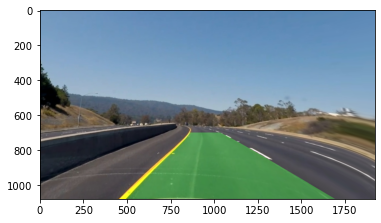

In [16]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        #Let's count the number of consecutive frames
        self.count = 0
        # was the line detected in the last iteration?
        self.detected = False  
        #polynomial coefficients for the most recent fit
        self.curve_fit = []  
        # Traking variance for the right lane
        self.right_variance = []
        # x values of the curve that we fit intially
        #self.current_xfitted = []
        # x values for detected line pixels
        #self.allx = []  
        # y values for detected line pixels
        #self.ally = []
        #store your image in this
        #self.image_output = []
        
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        
        
lane=Line()


frame1= mpimg.imread("my_test_images/Highway_snaps/image (1).jpg")
frame2= mpimg.imread("my_test_images/Highway_snaps/image (2).jpg")
frame3= mpimg.imread("my_test_images/Highway_snaps/image (3).jpg")


print("starting count value",lane.count)


(process_image(frame1))
(process_image(frame2))
plt.imshow(process_image(frame3))


Videoo test



In [13]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        #Let's count the number of consecutive frames
        self.count = 0
        # was the line detected in the last iteration?
        self.detected = False  
        #polynomial coefficients for the most recent fit
        self.curve_fit = []  
        # Traking variance for the right lane
        self.right_variance = []
        # x values of the curve that we fit intially
        #self.current_xfitted = []
        # x values for detected line pixels
        #self.allx = []  
        # y values for detected line pixels
        #self.ally = []
        #store your image in this
        #self.image_output = []
        
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')      
        
lane=Line()

project_output = 'output_files/video_clips/project_video_with_history.mp4'

clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(20,23)

project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images! 
%time project_clip.write_videofile(project_output, audio=False)

starting count 0


t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

variance_new 17.613366307454978
First case mein variance ye hai 17.613366307454978
[17.613366307454978, 17.613366307454978, 17.613366307454978, 17.613366307454978, 17.613366307454978]
(720, 1280, 3)
Moviepy - Building video output_files/video_clips/project_video_with_history.mp4.
Moviepy - Writing video output_files/video_clips/project_video_with_history.mp4

starting count 1


t:   0%|          | 2/1260 [00:00<09:28,  2.21it/s, now=None]

variance_new 17.613366307456523
[17.613366307454978, 17.613366307454978, 17.613366307454978, 17.613366307454978, 17.613366307456523]
(720, 1280, 3)
starting count 2


t:   0%|          | 3/1260 [00:01<09:47,  2.14it/s, now=None]

variance_new 18.9317300993645
[17.613366307454978, 17.613366307454978, 17.613366307454978, 17.613366307456523, 18.9317300993645]
(720, 1280, 3)
starting count 3


t:   0%|          | 4/1260 [00:01<09:13,  2.27it/s, now=None]

variance_new 17.821627970884833
[17.613366307454978, 17.613366307454978, 17.613366307456523, 18.9317300993645, 17.821627970884833]
(720, 1280, 3)
starting count 4


t:   0%|          | 5/1260 [00:02<09:13,  2.27it/s, now=None]

variance_new 14.466140377283912
[17.613366307454978, 17.613366307456523, 18.9317300993645, 17.821627970884833, 14.466140377283912]
(720, 1280, 3)
starting count 5


t:   0%|          | 6/1260 [00:02<08:39,  2.41it/s, now=None]

variance_new 14.719603972282455
[17.613366307456523, 18.9317300993645, 17.821627970884833, 14.466140377283912, 14.719603972282455]
(720, 1280, 3)
starting count 6


t:   1%|          | 7/1260 [00:02<08:07,  2.57it/s, now=None]

variance_new 14.262820113055101
[18.9317300993645, 17.821627970884833, 14.466140377283912, 14.719603972282455, 14.262820113055101]
(720, 1280, 3)
starting count 7


t:   1%|          | 8/1260 [00:03<07:38,  2.73it/s, now=None]

variance_new 11.84674286398799
[17.821627970884833, 14.466140377283912, 14.719603972282455, 14.262820113055101, 11.84674286398799]
(720, 1280, 3)
starting count 8


t:   1%|          | 9/1260 [00:03<07:24,  2.81it/s, now=None]

variance_new 11.574125756957503
[14.466140377283912, 14.719603972282455, 14.262820113055101, 11.84674286398799, 11.574125756957503]
(720, 1280, 3)
starting count 9


t:   1%|          | 10/1260 [00:03<07:17,  2.86it/s, now=None]

variance_new 11.383014550041159
[14.719603972282455, 14.262820113055101, 11.84674286398799, 11.574125756957503, 11.383014550041159]
(720, 1280, 3)
starting count 10


t:   1%|          | 11/1260 [00:04<07:14,  2.87it/s, now=None]

variance_new 11.999263814012307
[14.262820113055101, 11.84674286398799, 11.574125756957503, 11.383014550041159, 11.999263814012307]
(720, 1280, 3)
starting count 11


t:   1%|          | 12/1260 [00:04<07:18,  2.85it/s, now=None]

variance_new 12.395603106188856
[11.84674286398799, 11.574125756957503, 11.383014550041159, 11.999263814012307, 12.395603106188856]
(720, 1280, 3)
starting count 12


t:   1%|          | 13/1260 [00:04<07:32,  2.76it/s, now=None]

variance_new 15.874996021625403
[11.574125756957503, 11.383014550041159, 11.999263814012307, 12.395603106188856, 15.874996021625403]
(720, 1280, 3)
starting count 13


t:   1%|          | 14/1260 [00:05<07:47,  2.66it/s, now=None]

variance_new 17.941202621396503
[11.383014550041159, 11.999263814012307, 12.395603106188856, 15.874996021625403, 17.941202621396503]
(720, 1280, 3)
starting count 14


t:   1%|          | 15/1260 [00:05<07:46,  2.67it/s, now=None]

variance_new 21.214418485849038
[11.999263814012307, 12.395603106188856, 15.874996021625403, 17.941202621396503, 21.214418485849038]
(720, 1280, 3)
starting count 15


t:   1%|▏         | 16/1260 [00:08<21:13,  1.02s/it, now=None]

variance_new 23.47084678262781
[12.395603106188856, 15.874996021625403, 17.941202621396503, 21.214418485849038, 23.47084678262781]
(720, 1280, 3)
starting count 16


t:   1%|▏         | 17/1260 [00:08<17:03,  1.21it/s, now=None]

variance_new 13.668714049265137
[15.874996021625403, 17.941202621396503, 21.214418485849038, 23.47084678262781, 13.668714049265137]
(720, 1280, 3)
starting count 17


t:   1%|▏         | 18/1260 [00:08<13:59,  1.48it/s, now=None]

variance_new 15.304221976646236
[17.941202621396503, 21.214418485849038, 23.47084678262781, 13.668714049265137, 15.304221976646236]
(720, 1280, 3)
starting count 18


t:   2%|▏         | 19/1260 [00:09<11:41,  1.77it/s, now=None]

variance_new 14.493018882356715
[21.214418485849038, 23.47084678262781, 13.668714049265137, 15.304221976646236, 14.493018882356715]
(720, 1280, 3)
starting count 19


t:   2%|▏         | 20/1260 [00:09<09:57,  2.08it/s, now=None]

variance_new 13.159471561230562
[23.47084678262781, 13.668714049265137, 15.304221976646236, 14.493018882356715, 13.159471561230562]
(720, 1280, 3)
starting count 20


t:   2%|▏         | 21/1260 [00:09<08:44,  2.36it/s, now=None]

variance_new 10.498995614285759
[13.668714049265137, 15.304221976646236, 14.493018882356715, 13.159471561230562, 10.498995614285759]
(720, 1280, 3)
starting count 21


t:   2%|▏         | 22/1260 [00:10<07:55,  2.60it/s, now=None]

variance_new 10.939429814274968
[15.304221976646236, 14.493018882356715, 13.159471561230562, 10.498995614285759, 10.939429814274968]
(720, 1280, 3)
starting count 22


t:   2%|▏         | 23/1260 [00:10<07:25,  2.78it/s, now=None]

variance_new 11.467583175995019
[14.493018882356715, 13.159471561230562, 10.498995614285759, 10.939429814274968, 11.467583175995019]
(720, 1280, 3)
starting count 23


t:   2%|▏         | 24/1260 [00:10<07:13,  2.85it/s, now=None]

variance_new 12.82183378663497
[13.159471561230562, 10.498995614285759, 10.939429814274968, 11.467583175995019, 12.82183378663497]
(720, 1280, 3)
starting count 24


t:   2%|▏         | 25/1260 [00:11<07:08,  2.88it/s, now=None]

variance_new 13.550472751590542
[10.498995614285759, 10.939429814274968, 11.467583175995019, 12.82183378663497, 13.550472751590542]
(720, 1280, 3)
starting count 25
variance_new 14.620637486578504
[10.939429814274968, 11.467583175995019, 12.82183378663497, 13.550472751590542, 14.620637486578504]
(720, 1280, 3)


t:   2%|▏         | 26/1260 [00:13<22:11,  1.08s/it, now=None]

starting count 26


t:   2%|▏         | 27/1260 [00:14<19:23,  1.06it/s, now=None]

variance_new 16.65722267342241
[11.467583175995019, 12.82183378663497, 13.550472751590542, 14.620637486578504, 16.65722267342241]
(720, 1280, 3)
starting count 27


t:   2%|▏         | 28/1260 [00:14<15:46,  1.30it/s, now=None]

variance_new 18.37512065777636
[12.82183378663497, 13.550472751590542, 14.620637486578504, 16.65722267342241, 18.37512065777636]
(720, 1280, 3)
starting count 28


t:   2%|▏         | 29/1260 [00:15<13:13,  1.55it/s, now=None]

variance_new 18.042173107444327
[13.550472751590542, 14.620637486578504, 16.65722267342241, 18.37512065777636, 18.042173107444327]
(720, 1280, 3)
starting count 29


t:   2%|▏         | 30/1260 [00:15<11:27,  1.79it/s, now=None]

variance_new 18.521247995335102
[14.620637486578504, 16.65722267342241, 18.37512065777636, 18.042173107444327, 18.521247995335102]
(720, 1280, 3)
starting count 30


t:   2%|▏         | 31/1260 [00:15<10:00,  2.05it/s, now=None]

variance_new 15.773315655171363
[16.65722267342241, 18.37512065777636, 18.042173107444327, 18.521247995335102, 15.773315655171363]
(720, 1280, 3)
starting count 31


t:   3%|▎         | 32/1260 [00:16<08:52,  2.31it/s, now=None]

variance_new 14.459250851170395
[18.37512065777636, 18.042173107444327, 18.521247995335102, 15.773315655171363, 14.459250851170395]
(720, 1280, 3)
starting count 32


t:   3%|▎         | 33/1260 [00:16<07:56,  2.58it/s, now=None]

variance_new 11.156000526306936
[18.042173107444327, 18.521247995335102, 15.773315655171363, 14.459250851170395, 11.156000526306936]
(720, 1280, 3)
starting count 33


t:   3%|▎         | 34/1260 [00:16<07:19,  2.79it/s, now=None]

variance_new 11.470072460859452
[18.521247995335102, 15.773315655171363, 14.459250851170395, 11.156000526306936, 11.470072460859452]
(720, 1280, 3)
starting count 34


t:   3%|▎         | 35/1260 [00:17<06:58,  2.93it/s, now=None]

variance_new 11.225979857955329
[15.773315655171363, 14.459250851170395, 11.156000526306936, 11.470072460859452, 11.225979857955329]
(720, 1280, 3)
starting count 35


t:   3%|▎         | 36/1260 [00:17<06:50,  2.98it/s, now=None]

variance_new 10.958290614745875
[14.459250851170395, 11.156000526306936, 11.470072460859452, 11.225979857955329, 10.958290614745875]
(720, 1280, 3)
starting count 36


t:   3%|▎         | 37/1260 [00:18<14:07,  1.44it/s, now=None]

variance_new 11.537907137209892
[11.156000526306936, 11.470072460859452, 11.225979857955329, 10.958290614745875, 11.537907137209892]
(720, 1280, 3)
starting count 37


t:   3%|▎         | 38/1260 [00:20<19:03,  1.07it/s, now=None]

variance_new 15.139471110264257
[11.470072460859452, 11.225979857955329, 10.958290614745875, 11.537907137209892, 15.139471110264257]
(720, 1280, 3)
starting count 38


t:   3%|▎         | 39/1260 [00:20<15:36,  1.30it/s, now=None]

variance_new 17.67026245106021
[11.225979857955329, 10.958290614745875, 11.537907137209892, 15.139471110264257, 17.67026245106021]
(720, 1280, 3)
starting count 39


t:   3%|▎         | 40/1260 [00:21<12:59,  1.57it/s, now=None]

variance_new 19.13087811255835
[10.958290614745875, 11.537907137209892, 15.139471110264257, 17.67026245106021, 19.13087811255835]
(720, 1280, 3)
starting count 40


t:   3%|▎         | 41/1260 [00:21<11:07,  1.83it/s, now=None]

variance_new 15.898658676577623
[11.537907137209892, 15.139471110264257, 17.67026245106021, 19.13087811255835, 15.898658676577623]
(720, 1280, 3)
starting count 41


t:   3%|▎         | 42/1260 [00:21<09:54,  2.05it/s, now=None]

variance_new 13.113345701224448
[15.139471110264257, 17.67026245106021, 19.13087811255835, 15.898658676577623, 13.113345701224448]
(720, 1280, 3)
starting count 42


t:   3%|▎         | 43/1260 [00:22<08:54,  2.28it/s, now=None]

variance_new 15.04634679700178
[17.67026245106021, 19.13087811255835, 15.898658676577623, 13.113345701224448, 15.04634679700178]
(720, 1280, 3)
starting count 43


t:   3%|▎         | 44/1260 [00:22<08:33,  2.37it/s, now=None]

variance_new 16.646364341571285
[19.13087811255835, 15.898658676577623, 13.113345701224448, 15.04634679700178, 16.646364341571285]
(720, 1280, 3)
starting count 44


t:   4%|▎         | 45/1260 [00:22<07:49,  2.59it/s, now=None]

variance_new 18.944654913969522
[15.898658676577623, 13.113345701224448, 15.04634679700178, 16.646364341571285, 18.944654913969522]
(720, 1280, 3)
starting count 45


t:   4%|▎         | 46/1260 [00:23<12:00,  1.69it/s, now=None]

variance_new 15.999853872728018
[13.113345701224448, 15.04634679700178, 16.646364341571285, 18.944654913969522, 15.999853872728018]
(720, 1280, 3)
starting count 46


t:   4%|▎         | 47/1260 [00:26<21:04,  1.04s/it, now=None]

variance_new 11.568522427522357
[15.04634679700178, 16.646364341571285, 18.944654913969522, 15.999853872728018, 11.568522427522357]
(720, 1280, 3)
starting count 47


t:   4%|▍         | 48/1260 [00:26<16:35,  1.22it/s, now=None]

variance_new 12.557411428823059
[16.646364341571285, 18.944654913969522, 15.999853872728018, 11.568522427522357, 12.557411428823059]
(720, 1280, 3)
starting count 48


t:   4%|▍         | 49/1260 [00:26<13:45,  1.47it/s, now=None]

variance_new 13.977146433650447
[18.944654913969522, 15.999853872728018, 11.568522427522357, 12.557411428823059, 13.977146433650447]
(720, 1280, 3)
starting count 49


t:   4%|▍         | 50/1260 [00:27<11:44,  1.72it/s, now=None]

variance_new 16.141170509911316
[15.999853872728018, 11.568522427522357, 12.557411428823059, 13.977146433650447, 16.141170509911316]
(720, 1280, 3)
starting count 50


t:   4%|▍         | 51/1260 [00:27<10:29,  1.92it/s, now=None]

variance_new 16.530776189849682
[11.568522427522357, 12.557411428823059, 13.977146433650447, 16.141170509911316, 16.530776189849682]
(720, 1280, 3)
starting count 51


t:   4%|▍         | 52/1260 [00:27<09:40,  2.08it/s, now=None]

variance_new 20.471052179609046
[12.557411428823059, 13.977146433650447, 16.141170509911316, 16.530776189849682, 20.471052179609046]
(720, 1280, 3)
starting count 52


t:   4%|▍         | 53/1260 [00:28<09:04,  2.22it/s, now=None]

variance_new 24.87611902063849
[13.977146433650447, 16.141170509911316, 16.530776189849682, 20.471052179609046, 24.87611902063849]
(720, 1280, 3)
starting count 53


t:   4%|▍         | 54/1260 [00:28<08:29,  2.37it/s, now=None]

variance_new 20.583738926448227
[16.141170509911316, 16.530776189849682, 20.471052179609046, 24.87611902063849, 20.583738926448227]
(720, 1280, 3)
starting count 54


t:   4%|▍         | 55/1260 [00:28<07:57,  2.52it/s, now=None]

variance_new 14.739845257352544
[16.530776189849682, 20.471052179609046, 24.87611902063849, 20.583738926448227, 14.739845257352544]
(720, 1280, 3)
starting count 55
variance_new 16.061399701860882
[20.471052179609046, 24.87611902063849, 20.583738926448227, 14.739845257352544, 16.061399701860882]
(720, 1280, 3)


t:   4%|▍         | 56/1260 [00:31<19:12,  1.04it/s, now=None]

starting count 56
variance_new 14.744129821318172
[24.87611902063849, 20.583738926448227, 14.739845257352544, 16.061399701860882, 14.744129821318172]


t:   5%|▍         | 57/1260 [00:32<19:38,  1.02it/s, now=None]

(720, 1280, 3)
starting count 57


t:   5%|▍         | 58/1260 [00:32<15:35,  1.28it/s, now=None]

variance_new 15.158001128756865
[20.583738926448227, 14.739845257352544, 16.061399701860882, 14.744129821318172, 15.158001128756865]
(720, 1280, 3)
starting count 58


t:   5%|▍         | 59/1260 [00:32<12:41,  1.58it/s, now=None]

variance_new 10.53867445659137
[14.739845257352544, 16.061399701860882, 14.744129821318172, 15.158001128756865, 10.53867445659137]
(720, 1280, 3)
starting count 59


t:   5%|▍         | 60/1260 [00:33<10:45,  1.86it/s, now=None]

variance_new 10.936660512347347
[16.061399701860882, 14.744129821318172, 15.158001128756865, 10.53867445659137, 10.936660512347347]
(720, 1280, 3)
starting count 60


t:   5%|▍         | 61/1260 [00:33<09:42,  2.06it/s, now=None]

variance_new 12.163577258134493
[14.744129821318172, 15.158001128756865, 10.53867445659137, 10.936660512347347, 12.163577258134493]
(720, 1280, 3)
starting count 61


t:   5%|▍         | 62/1260 [00:33<09:05,  2.20it/s, now=None]

variance_new 12.53901548277991
[15.158001128756865, 10.53867445659137, 10.936660512347347, 12.163577258134493, 12.53901548277991]
(720, 1280, 3)
starting count 62


t:   5%|▌         | 63/1260 [00:34<08:30,  2.35it/s, now=None]

variance_new 12.837548953743804
[10.53867445659137, 10.936660512347347, 12.163577258134493, 12.53901548277991, 12.837548953743804]
(720, 1280, 3)
starting count 63


t:   5%|▌         | 64/1260 [00:34<08:03,  2.48it/s, now=None]

variance_new 16.26006324967067
[10.936660512347347, 12.163577258134493, 12.53901548277991, 12.837548953743804, 16.26006324967067]
(720, 1280, 3)
starting count 64
variance_new 13.448963129299313
[12.163577258134493, 12.53901548277991, 12.837548953743804, 16.26006324967067, 13.448963129299313]
(720, 1280, 3)


t:   5%|▌         | 65/1260 [00:35<08:44,  2.28it/s, now=None]

starting count 65


t:   5%|▌         | 66/1260 [00:37<20:26,  1.03s/it, now=None]

variance_new 13.2014471821325
[12.53901548277991, 12.837548953743804, 16.26006324967067, 13.448963129299313, 13.2014471821325]
(720, 1280, 3)
starting count 66


t:   5%|▌         | 67/1260 [00:37<16:20,  1.22it/s, now=None]

variance_new 11.382420264016604
[12.837548953743804, 16.26006324967067, 13.448963129299313, 13.2014471821325, 11.382420264016604]
(720, 1280, 3)
starting count 67


t:   5%|▌         | 68/1260 [00:38<13:16,  1.50it/s, now=None]

variance_new 12.78631924613369
[16.26006324967067, 13.448963129299313, 13.2014471821325, 11.382420264016604, 12.78631924613369]
(720, 1280, 3)
starting count 68


t:   5%|▌         | 69/1260 [00:38<11:09,  1.78it/s, now=None]

variance_new 14.64669999791269
[13.448963129299313, 13.2014471821325, 11.382420264016604, 12.78631924613369, 14.64669999791269]
(720, 1280, 3)
starting count 69


t:   6%|▌         | 70/1260 [00:38<09:34,  2.07it/s, now=None]

variance_new 10.437309255742708
[13.2014471821325, 11.382420264016604, 12.78631924613369, 14.64669999791269, 10.437309255742708]
(720, 1280, 3)
starting count 70


t:   6%|▌         | 71/1260 [00:39<08:26,  2.35it/s, now=None]

variance_new 10.135159413364914
[11.382420264016604, 12.78631924613369, 14.64669999791269, 10.437309255742708, 10.135159413364914]
(720, 1280, 3)
starting count 71


t:   6%|▌         | 72/1260 [00:39<07:42,  2.57it/s, now=None]

variance_new 11.216785626013147
[12.78631924613369, 14.64669999791269, 10.437309255742708, 10.135159413364914, 11.216785626013147]
(720, 1280, 3)
starting count 72


t:   6%|▌         | 73/1260 [00:39<07:34,  2.61it/s, now=None]

variance_new 12.820609784950852
[14.64669999791269, 10.437309255742708, 10.135159413364914, 11.216785626013147, 12.820609784950852]
(720, 1280, 3)
starting count 73


t:   6%|▌         | 74/1260 [00:40<07:24,  2.67it/s, now=None]

variance_new 13.016390381847861
[10.437309255742708, 10.135159413364914, 11.216785626013147, 12.820609784950852, 13.016390381847861]
(720, 1280, 3)
starting count 74
variance_new 13.369417893323387
[10.135159413364914, 11.216785626013147, 12.820609784950852, 13.016390381847861, 13.369417893323387]
(720, 1280, 3)


t:   6%|▌         | 75/1260 [00:41<12:50,  1.54it/s, now=None]

starting count 75


t:   6%|▌         | 76/1260 [00:43<21:08,  1.07s/it, now=None]

variance_new 15.596147380378158
[11.216785626013147, 12.820609784950852, 13.016390381847861, 13.369417893323387, 15.596147380378158]
(720, 1280, 3)
starting count 76


t:   6%|▌         | 77/1260 [00:43<16:56,  1.16it/s, now=None]

variance_new 15.375517933781131
[12.820609784950852, 13.016390381847861, 13.369417893323387, 15.596147380378158, 15.375517933781131]
(720, 1280, 3)
starting count 77


t:   6%|▌         | 78/1260 [00:44<14:01,  1.40it/s, now=None]

variance_new 17.445564021014697
[13.016390381847861, 13.369417893323387, 15.596147380378158, 15.375517933781131, 17.445564021014697]
(720, 1280, 3)
starting count 78


t:   6%|▋         | 79/1260 [00:44<11:50,  1.66it/s, now=None]

variance_new 19.640497935368995
[13.369417893323387, 15.596147380378158, 15.375517933781131, 17.445564021014697, 19.640497935368995]
(720, 1280, 3)
starting count 79


t:   6%|▋         | 80/1260 [00:44<10:18,  1.91it/s, now=None]

variance_new 19.2839522418797
[15.596147380378158, 15.375517933781131, 17.445564021014697, 19.640497935368995, 19.2839522418797]
(720, 1280, 3)
starting count 80


t:   6%|▋         | 81/1260 [00:45<09:24,  2.09it/s, now=None]

variance_new 17.681301369655824
[15.375517933781131, 17.445564021014697, 19.640497935368995, 19.2839522418797, 17.681301369655824]
(720, 1280, 3)
starting count 81


t:   7%|▋         | 82/1260 [00:45<08:26,  2.32it/s, now=None]

variance_new 16.3810808412801
[17.445564021014697, 19.640497935368995, 19.2839522418797, 17.681301369655824, 16.3810808412801]
(720, 1280, 3)
starting count 82


t:   7%|▋         | 83/1260 [00:45<07:42,  2.54it/s, now=None]

variance_new 15.208990427840735
[19.640497935368995, 19.2839522418797, 17.681301369655824, 16.3810808412801, 15.208990427840735]
(720, 1280, 3)
starting count 83


t:   7%|▋         | 84/1260 [00:46<07:09,  2.74it/s, now=None]

variance_new 11.509592307984715
[19.2839522418797, 17.681301369655824, 16.3810808412801, 15.208990427840735, 11.509592307984715]
(720, 1280, 3)
starting count 84
variance_new 10.80566281588382
[17.681301369655824, 16.3810808412801, 15.208990427840735, 11.509592307984715, 10.80566281588382]
(720, 1280, 3)


t:   7%|▋         | 85/1260 [00:47<15:45,  1.24it/s, now=None]

starting count 85


t:   7%|▋         | 86/1260 [00:49<19:25,  1.01it/s, now=None]

variance_new 10.110860998123613
[16.3810808412801, 15.208990427840735, 11.509592307984715, 10.80566281588382, 10.110860998123613]
(720, 1280, 3)
starting count 86


t:   7%|▋         | 87/1260 [00:49<15:30,  1.26it/s, now=None]

variance_new 11.768356268510967
[15.208990427840735, 11.509592307984715, 10.80566281588382, 10.110860998123613, 11.768356268510967]
(720, 1280, 3)
starting count 87


t:   7%|▋         | 88/1260 [00:50<12:51,  1.52it/s, now=None]

variance_new 11.081489065306881
[11.509592307984715, 10.80566281588382, 10.110860998123613, 11.768356268510967, 11.081489065306881]
(720, 1280, 3)
starting count 88


t:   7%|▋         | 89/1260 [00:50<11:13,  1.74it/s, now=None]

variance_new 12.115694341014978
[10.80566281588382, 10.110860998123613, 11.768356268510967, 11.081489065306881, 12.115694341014978]
(720, 1280, 3)
starting count 89


t:   7%|▋         | 90/1260 [00:50<09:47,  1.99it/s, now=None]

variance_new 13.424938046198255
[10.110860998123613, 11.768356268510967, 11.081489065306881, 12.115694341014978, 13.424938046198255]
(720, 1280, 3)
starting count 90


t:   7%|▋         | 91/1260 [00:51<08:48,  2.21it/s, now=None]

variance_new 10.355232188724846
[11.768356268510967, 11.081489065306881, 12.115694341014978, 13.424938046198255, 10.355232188724846]
(720, 1280, 3)
starting count 91


t:   7%|▋         | 92/1260 [00:51<08:12,  2.37it/s, now=None]

variance_new 10.867581235089176
[11.081489065306881, 12.115694341014978, 13.424938046198255, 10.355232188724846, 10.867581235089176]
(720, 1280, 3)
starting count 92


t:   7%|▋         | 93/1260 [00:51<07:45,  2.51it/s, now=None]

variance_new 11.721753407602638
[12.115694341014978, 13.424938046198255, 10.355232188724846, 10.867581235089176, 11.721753407602638]
(720, 1280, 3)
starting count 93


t:   7%|▋         | 94/1260 [00:52<07:27,  2.60it/s, now=None]

variance_new 10.6503150514839
[13.424938046198255, 10.355232188724846, 10.867581235089176, 11.721753407602638, 10.6503150514839]
(720, 1280, 3)
starting count 94


t:   8%|▊         | 95/1260 [00:54<20:28,  1.05s/it, now=None]

variance_new 11.405019141949516
[10.355232188724846, 10.867581235089176, 11.721753407602638, 10.6503150514839, 11.405019141949516]
(720, 1280, 3)


t:   8%|▊         | 96/1260 [00:55<17:55,  1.08it/s, now=None]

starting count 95
variance_new 10.297340583462018
[10.867581235089176, 11.721753407602638, 10.6503150514839, 11.405019141949516, 10.297340583462018]
(720, 1280, 3)
starting count 96
variance_new 10.426418296347581
[11.721753407602638, 10.6503150514839, 11.405019141949516, 10.297340583462018, 10.426418296347581]


t:   8%|▊         | 97/1260 [00:55<14:33,  1.33it/s, now=None]

(720, 1280, 3)
starting count 97


t:   8%|▊         | 98/1260 [00:56<12:11,  1.59it/s, now=None]

variance_new 10.898859234841657
[10.6503150514839, 11.405019141949516, 10.297340583462018, 10.426418296347581, 10.898859234841657]
(720, 1280, 3)
starting count 98


t:   8%|▊         | 99/1260 [00:56<10:31,  1.84it/s, now=None]

variance_new 11.242936102634872
[11.405019141949516, 10.297340583462018, 10.426418296347581, 10.898859234841657, 11.242936102634872]
(720, 1280, 3)
starting count 99


t:   8%|▊         | 100/1260 [00:56<09:27,  2.05it/s, now=None]

variance_new 11.198822007348774
[10.297340583462018, 10.426418296347581, 10.898859234841657, 11.242936102634872, 11.198822007348774]
(720, 1280, 3)
starting count 100


t:   8%|▊         | 101/1260 [00:57<08:44,  2.21it/s, now=None]

variance_new 11.89914972444309
[10.426418296347581, 10.898859234841657, 11.242936102634872, 11.198822007348774, 11.89914972444309]
(720, 1280, 3)
starting count 101


t:   8%|▊         | 102/1260 [00:57<08:12,  2.35it/s, now=None]

variance_new 11.71662096446439
[10.898859234841657, 11.242936102634872, 11.198822007348774, 11.89914972444309, 11.71662096446439]
(720, 1280, 3)
starting count 102


t:   8%|▊         | 103/1260 [00:57<07:32,  2.56it/s, now=None]

variance_new 10.52139737059142
[11.242936102634872, 11.198822007348774, 11.89914972444309, 11.71662096446439, 10.52139737059142]
(720, 1280, 3)
starting count 103
variance_new 12.642710658223157
[11.198822007348774, 11.89914972444309, 11.71662096446439, 10.52139737059142, 12.642710658223157]
(720, 1280, 3)


t:   8%|▊         | 104/1260 [00:58<10:33,  1.83it/s, now=None]

starting count 104


t:   8%|▊         | 105/1260 [01:01<21:10,  1.10s/it, now=None]

variance_new 11.270573680386422
[11.89914972444309, 11.71662096446439, 10.52139737059142, 12.642710658223157, 11.270573680386422]
(720, 1280, 3)
starting count 105


t:   8%|▊         | 106/1260 [01:01<16:46,  1.15it/s, now=None]

variance_new 16.093130953089254
[11.71662096446439, 10.52139737059142, 12.642710658223157, 11.270573680386422, 16.093130953089254]
(720, 1280, 3)
starting count 106


t:   8%|▊         | 107/1260 [01:01<13:40,  1.40it/s, now=None]

variance_new 17.119308221095146
[10.52139737059142, 12.642710658223157, 11.270573680386422, 16.093130953089254, 17.119308221095146]
(720, 1280, 3)
starting count 107


t:   9%|▊         | 108/1260 [01:02<11:20,  1.69it/s, now=None]

variance_new 17.967158362353867
[12.642710658223157, 11.270573680386422, 16.093130953089254, 17.119308221095146, 17.967158362353867]
(720, 1280, 3)
starting count 108


t:   9%|▊         | 109/1260 [01:02<09:44,  1.97it/s, now=None]

variance_new 11.723265231290439
[11.270573680386422, 16.093130953089254, 17.119308221095146, 17.967158362353867, 11.723265231290439]
(720, 1280, 3)
starting count 109


t:   9%|▊         | 110/1260 [01:02<08:35,  2.23it/s, now=None]

variance_new 10.91015971559005
[16.093130953089254, 17.119308221095146, 17.967158362353867, 11.723265231290439, 10.91015971559005]
(720, 1280, 3)
starting count 110


t:   9%|▉         | 111/1260 [01:03<07:49,  2.45it/s, now=None]

variance_new 11.464184545087972
[17.119308221095146, 17.967158362353867, 11.723265231290439, 10.91015971559005, 11.464184545087972]
(720, 1280, 3)
starting count 111


t:   9%|▉         | 112/1260 [01:03<07:28,  2.56it/s, now=None]

variance_new 12.498976103149053
[17.967158362353867, 11.723265231290439, 10.91015971559005, 11.464184545087972, 12.498976103149053]
(720, 1280, 3)
starting count 112


t:   9%|▉         | 113/1260 [01:03<07:25,  2.57it/s, now=None]

variance_new 14.29474317609833
[11.723265231290439, 10.91015971559005, 11.464184545087972, 12.498976103149053, 14.29474317609833]
(720, 1280, 3)
starting count 113
variance_new 13.436573585513603
[10.91015971559005, 11.464184545087972, 12.498976103149053, 14.29474317609833, 13.436573585513603]
(720, 1280, 3)


t:   9%|▉         | 114/1260 [01:05<13:24,  1.42it/s, now=None]

starting count 114


t:   9%|▉         | 115/1260 [01:06<17:52,  1.07it/s, now=None]

variance_new 14.214090632327332
[11.464184545087972, 12.498976103149053, 14.29474317609833, 13.436573585513603, 14.214090632327332]
(720, 1280, 3)
starting count 115


t:   9%|▉         | 116/1260 [01:07<14:24,  1.32it/s, now=None]

variance_new 14.796638609074755
[12.498976103149053, 14.29474317609833, 13.436573585513603, 14.214090632327332, 14.796638609074755]
(720, 1280, 3)
starting count 116


t:   9%|▉         | 117/1260 [01:07<12:37,  1.51it/s, now=None]

variance_new 13.617526897208963
[14.29474317609833, 13.436573585513603, 14.214090632327332, 14.796638609074755, 13.617526897208963]
(720, 1280, 3)
starting count 117


t:   9%|▉         | 118/1260 [01:07<10:46,  1.77it/s, now=None]

variance_new 12.140625008634107
[13.436573585513603, 14.214090632327332, 14.796638609074755, 13.617526897208963, 12.140625008634107]
(720, 1280, 3)
starting count 118


t:   9%|▉         | 119/1260 [01:08<09:17,  2.05it/s, now=None]

variance_new 11.640845129190659
[14.214090632327332, 14.796638609074755, 13.617526897208963, 12.140625008634107, 11.640845129190659]
(720, 1280, 3)
starting count 119


t:  10%|▉         | 120/1260 [01:08<08:13,  2.31it/s, now=None]

variance_new 12.624438944662527
[14.796638609074755, 13.617526897208963, 12.140625008634107, 11.640845129190659, 12.624438944662527]
(720, 1280, 3)
starting count 120


t:  10%|▉         | 121/1260 [01:08<07:34,  2.51it/s, now=None]

variance_new 10.022076250355934
[13.617526897208963, 12.140625008634107, 11.640845129190659, 12.624438944662527, 10.022076250355934]
(720, 1280, 3)
starting count 121


t:  10%|▉         | 122/1260 [01:09<07:01,  2.70it/s, now=None]

variance_new 10.257232810817252
[12.140625008634107, 11.640845129190659, 12.624438944662527, 10.022076250355934, 10.257232810817252]
(720, 1280, 3)
starting count 122


t:  10%|▉         | 123/1260 [01:09<06:36,  2.87it/s, now=None]

variance_new 10.33359348593046
[11.640845129190659, 12.624438944662527, 10.022076250355934, 10.257232810817252, 10.33359348593046]
(720, 1280, 3)
starting count 123
variance_new 9.883795456086785
[12.624438944662527, 10.022076250355934, 10.257232810817252, 10.33359348593046, 9.883795456086785]
(720, 1280, 3)


t:  10%|▉         | 124/1260 [01:11<18:06,  1.05it/s, now=None]

starting count 124
variance_new 10.103742204147336


t:  10%|▉         | 125/1260 [01:12<18:00,  1.05it/s, now=None]

[10.022076250355934, 10.257232810817252, 10.33359348593046, 9.883795456086785, 10.103742204147336]
(720, 1280, 3)
starting count 125


t:  10%|█         | 126/1260 [01:13<14:34,  1.30it/s, now=None]

variance_new 9.747119917886744
[10.257232810817252, 10.33359348593046, 9.883795456086785, 10.103742204147336, 9.747119917886744]
(720, 1280, 3)
starting count 126


t:  10%|█         | 127/1260 [01:13<12:15,  1.54it/s, now=None]

variance_new 10.40371033888129
[10.33359348593046, 9.883795456086785, 10.103742204147336, 9.747119917886744, 10.40371033888129]
(720, 1280, 3)
starting count 127


t:  10%|█         | 128/1260 [01:13<10:27,  1.80it/s, now=None]

variance_new 9.976367181331051
[9.883795456086785, 10.103742204147336, 9.747119917886744, 10.40371033888129, 9.976367181331051]
(720, 1280, 3)
starting count 128


t:  10%|█         | 129/1260 [01:14<09:25,  2.00it/s, now=None]

variance_new 10.7660945492661
[10.103742204147336, 9.747119917886744, 10.40371033888129, 9.976367181331051, 10.7660945492661]
(720, 1280, 3)
starting count 129


t:  10%|█         | 130/1260 [01:14<08:58,  2.10it/s, now=None]

variance_new 11.143539317737664
[9.747119917886744, 10.40371033888129, 9.976367181331051, 10.7660945492661, 11.143539317737664]
(720, 1280, 3)
starting count 130


t:  10%|█         | 131/1260 [01:14<08:44,  2.15it/s, now=None]

variance_new 11.734606596009925
[10.40371033888129, 9.976367181331051, 10.7660945492661, 11.143539317737664, 11.734606596009925]
(720, 1280, 3)
starting count 131
variance_new 12.684675702261753
[9.976367181331051, 10.7660945492661, 11.143539317737664, 11.734606596009925, 12.684675702261753]
(720, 1280, 3)


t:  10%|█         | 132/1260 [01:15<08:31,  2.21it/s, now=None]

starting count 132
variance_new 9.756743909558349
[10.7660945492661, 11.143539317737664, 11.734606596009925, 12.684675702261753, 9.756743909558349]
(720, 1280, 3)


t:  11%|█         | 133/1260 [01:18<24:22,  1.30s/it, now=None]

starting count 133
variance_new 12.078246304759496


t:  11%|█         | 134/1260 [01:19<18:57,  1.01s/it, now=None]

[11.143539317737664, 11.734606596009925, 12.684675702261753, 9.756743909558349, 12.078246304759496]
(720, 1280, 3)
starting count 134


t:  11%|█         | 135/1260 [01:19<15:19,  1.22it/s, now=None]

variance_new 13.694761400775802
[11.734606596009925, 12.684675702261753, 9.756743909558349, 12.078246304759496, 13.694761400775802]
(720, 1280, 3)
starting count 135


t:  11%|█         | 136/1260 [01:19<12:56,  1.45it/s, now=None]

variance_new 13.763774040357944
[12.684675702261753, 9.756743909558349, 12.078246304759496, 13.694761400775802, 13.763774040357944]
(720, 1280, 3)
starting count 136


t:  11%|█         | 137/1260 [01:20<11:08,  1.68it/s, now=None]

variance_new 13.525046176286889
[9.756743909558349, 12.078246304759496, 13.694761400775802, 13.763774040357944, 13.525046176286889]
(720, 1280, 3)
starting count 137


t:  11%|█         | 138/1260 [01:20<10:02,  1.86it/s, now=None]

variance_new 12.592792526627376
[12.078246304759496, 13.694761400775802, 13.763774040357944, 13.525046176286889, 12.592792526627376]
(720, 1280, 3)
starting count 138


t:  11%|█         | 139/1260 [01:20<09:03,  2.06it/s, now=None]

variance_new 13.139720898769681
[13.694761400775802, 13.763774040357944, 13.525046176286889, 12.592792526627376, 13.139720898769681]
(720, 1280, 3)
starting count 139


t:  11%|█         | 140/1260 [01:21<08:22,  2.23it/s, now=None]

variance_new 12.888166376490549
[13.763774040357944, 13.525046176286889, 12.592792526627376, 13.139720898769681, 12.888166376490549]
(720, 1280, 3)
starting count 140


t:  11%|█         | 141/1260 [01:23<20:14,  1.09s/it, now=None]

variance_new 15.275814016368766
[13.525046176286889, 12.592792526627376, 13.139720898769681, 12.888166376490549, 15.275814016368766]
(720, 1280, 3)
starting count 141


t:  11%|█▏        | 142/1260 [01:24<16:04,  1.16it/s, now=None]

variance_new 17.658209757225524
[12.592792526627376, 13.139720898769681, 12.888166376490549, 15.275814016368766, 17.658209757225524]
(720, 1280, 3)
starting count 142


t:  11%|█▏        | 143/1260 [01:24<13:16,  1.40it/s, now=None]

variance_new 16.480685972700734
[13.139720898769681, 12.888166376490549, 15.275814016368766, 17.658209757225524, 16.480685972700734]
(720, 1280, 3)
starting count 143


t:  11%|█▏        | 144/1260 [01:24<11:10,  1.66it/s, now=None]

variance_new 13.121029340974028
[12.888166376490549, 15.275814016368766, 17.658209757225524, 16.480685972700734, 13.121029340974028]
(720, 1280, 3)
starting count 144


t:  12%|█▏        | 145/1260 [01:25<09:41,  1.92it/s, now=None]

variance_new 14.669789895246517
[15.275814016368766, 17.658209757225524, 16.480685972700734, 13.121029340974028, 14.669789895246517]
(720, 1280, 3)
starting count 145


t:  12%|█▏        | 146/1260 [01:25<08:36,  2.16it/s, now=None]

variance_new 11.149821342708243
[17.658209757225524, 16.480685972700734, 13.121029340974028, 14.669789895246517, 11.149821342708243]
(720, 1280, 3)
starting count 146


t:  12%|█▏        | 147/1260 [01:25<07:52,  2.36it/s, now=None]

variance_new 11.49410527807581
[16.480685972700734, 13.121029340974028, 14.669789895246517, 11.149821342708243, 11.49410527807581]
(720, 1280, 3)
starting count 147


t:  12%|█▏        | 148/1260 [01:26<07:22,  2.51it/s, now=None]

variance_new 12.499599786605993
[13.121029340974028, 14.669789895246517, 11.149821342708243, 11.49410527807581, 12.499599786605993]
(720, 1280, 3)
starting count 148


t:  12%|█▏        | 149/1260 [01:26<07:26,  2.49it/s, now=None]

variance_new 12.284739415291128
[14.669789895246517, 11.149821342708243, 11.49410527807581, 12.499599786605993, 12.284739415291128]
(720, 1280, 3)
starting count 149


t:  12%|█▏        | 150/1260 [01:29<18:57,  1.02s/it, now=None]

variance_new 11.967956863826982
[11.149821342708243, 11.49410527807581, 12.499599786605993, 12.284739415291128, 11.967956863826982]
(720, 1280, 3)
starting count 150


t:  12%|█▏        | 151/1260 [01:30<18:11,  1.02it/s, now=None]

variance_new 14.554211472985584
[11.49410527807581, 12.499599786605993, 12.284739415291128, 11.967956863826982, 14.554211472985584]
(720, 1280, 3)
starting count 151


t:  12%|█▏        | 152/1260 [01:30<14:46,  1.25it/s, now=None]

variance_new 15.399390234277663
[12.499599786605993, 12.284739415291128, 11.967956863826982, 14.554211472985584, 15.399390234277663]
(720, 1280, 3)
starting count 152


t:  12%|█▏        | 153/1260 [01:30<12:25,  1.48it/s, now=None]

variance_new 16.388536440155317
[12.284739415291128, 11.967956863826982, 14.554211472985584, 15.399390234277663, 16.388536440155317]
(720, 1280, 3)
starting count 153


t:  12%|█▏        | 154/1260 [01:31<10:31,  1.75it/s, now=None]

variance_new 10.967062511693294
[11.967956863826982, 14.554211472985584, 15.399390234277663, 16.388536440155317, 10.967062511693294]
(720, 1280, 3)
starting count 154


t:  12%|█▏        | 155/1260 [01:31<09:15,  1.99it/s, now=None]

variance_new 13.669341788900143
[14.554211472985584, 15.399390234277663, 16.388536440155317, 10.967062511693294, 13.669341788900143]
(720, 1280, 3)
starting count 155


t:  12%|█▏        | 156/1260 [01:31<08:26,  2.18it/s, now=None]

variance_new 13.297821690548549
[15.399390234277663, 16.388536440155317, 10.967062511693294, 13.669341788900143, 13.297821690548549]
(720, 1280, 3)
starting count 156


t:  12%|█▏        | 157/1260 [01:32<07:41,  2.39it/s, now=None]

variance_new 12.071405078769981
[16.388536440155317, 10.967062511693294, 13.669341788900143, 13.297821690548549, 12.071405078769981]
(720, 1280, 3)
starting count 157


t:  13%|█▎        | 158/1260 [01:32<07:01,  2.61it/s, now=None]

variance_new 13.265117495970431
[10.967062511693294, 13.669341788900143, 13.297821690548549, 12.071405078769981, 13.265117495970431]
(720, 1280, 3)
starting count 158


t:  13%|█▎        | 159/1260 [01:33<09:24,  1.95it/s, now=None]

variance_new 11.818023538682281
[13.669341788900143, 13.297821690548549, 12.071405078769981, 13.265117495970431, 11.818023538682281]
(720, 1280, 3)
starting count 159


t:  13%|█▎        | 160/1260 [01:35<20:42,  1.13s/it, now=None]

variance_new 12.686973341706873
[13.297821690548549, 12.071405078769981, 13.265117495970431, 11.818023538682281, 12.686973341706873]
(720, 1280, 3)
starting count 160


t:  13%|█▎        | 161/1260 [01:36<17:04,  1.07it/s, now=None]

variance_new 12.523411361052776
[12.071405078769981, 13.265117495970431, 11.818023538682281, 12.686973341706873, 12.523411361052776]
(720, 1280, 3)
starting count 161


t:  13%|█▎        | 162/1260 [01:36<15:12,  1.20it/s, now=None]

variance_new 14.07153716558979
[13.265117495970431, 11.818023538682281, 12.686973341706873, 12.523411361052776, 14.07153716558979]
(720, 1280, 3)
starting count 162


t:  13%|█▎        | 163/1260 [01:37<13:30,  1.35it/s, now=None]

variance_new 15.490950788098369
[11.818023538682281, 12.686973341706873, 12.523411361052776, 14.07153716558979, 15.490950788098369]
(720, 1280, 3)
starting count 163


t:  13%|█▎        | 164/1260 [01:37<12:35,  1.45it/s, now=None]

variance_new 17.940970214853657
[12.686973341706873, 12.523411361052776, 14.07153716558979, 15.490950788098369, 17.940970214853657]
(720, 1280, 3)
starting count 164


t:  13%|█▎        | 165/1260 [01:38<11:29,  1.59it/s, now=None]

variance_new 21.020682450106214
[12.523411361052776, 14.07153716558979, 15.490950788098369, 17.940970214853657, 21.020682450106214]
(720, 1280, 3)
starting count 165


t:  13%|█▎        | 166/1260 [01:41<25:00,  1.37s/it, now=None]

variance_new 21.18898830422411
[14.07153716558979, 15.490950788098369, 17.940970214853657, 21.020682450106214, 21.18898830422411]
(720, 1280, 3)
starting count 166


t:  13%|█▎        | 167/1260 [01:42<20:11,  1.11s/it, now=None]

variance_new 18.56126664849
[15.490950788098369, 17.940970214853657, 21.020682450106214, 21.18898830422411, 18.56126664849]
(720, 1280, 3)
starting count 167


t:  13%|█▎        | 168/1260 [01:42<16:48,  1.08it/s, now=None]

variance_new 15.674013303532867
[17.940970214853657, 21.020682450106214, 21.18898830422411, 18.56126664849, 15.674013303532867]
(720, 1280, 3)
starting count 168


t:  13%|█▎        | 169/1260 [01:42<13:47,  1.32it/s, now=None]

variance_new 17.343575432989894
[21.020682450106214, 21.18898830422411, 18.56126664849, 15.674013303532867, 17.343575432989894]
(720, 1280, 3)
starting count 169


t:  13%|█▎        | 170/1260 [01:43<11:27,  1.58it/s, now=None]

variance_new 18.152754394400446
[21.18898830422411, 18.56126664849, 15.674013303532867, 17.343575432989894, 18.152754394400446]
(720, 1280, 3)
starting count 170


t:  14%|█▎        | 171/1260 [01:43<09:35,  1.89it/s, now=None]

variance_new 22.510717376330042
[18.56126664849, 15.674013303532867, 17.343575432989894, 18.152754394400446, 22.510717376330042]
(720, 1280, 3)
starting count 171


t:  14%|█▎        | 172/1260 [01:43<08:21,  2.17it/s, now=None]

variance_new 12.208590485445747
[15.674013303532867, 17.343575432989894, 18.152754394400446, 22.510717376330042, 12.208590485445747]
(720, 1280, 3)
starting count 172
variance_new 13.098635989310676
[17.343575432989894, 18.152754394400446, 22.510717376330042, 12.208590485445747, 13.098635989310676]
(720, 1280, 3)


t:  14%|█▎        | 173/1260 [01:45<16:20,  1.11it/s, now=None]

starting count 173


t:  14%|█▍        | 174/1260 [01:47<19:43,  1.09s/it, now=None]

variance_new 13.158633909860415
[18.152754394400446, 22.510717376330042, 12.208590485445747, 13.098635989310676, 13.158633909860415]
(720, 1280, 3)
starting count 174


t:  14%|█▍        | 175/1260 [01:47<15:59,  1.13it/s, now=None]

variance_new 11.684293908898745
[22.510717376330042, 12.208590485445747, 13.098635989310676, 13.158633909860415, 11.684293908898745]
(720, 1280, 3)
starting count 175


t:  14%|█▍        | 176/1260 [01:48<13:39,  1.32it/s, now=None]

variance_new 12.451471143092444
[12.208590485445747, 13.098635989310676, 13.158633909860415, 11.684293908898745, 12.451471143092444]
(720, 1280, 3)
starting count 176


t:  14%|█▍        | 177/1260 [01:48<11:44,  1.54it/s, now=None]

variance_new 13.466308250499946
[13.098635989310676, 13.158633909860415, 11.684293908898745, 12.451471143092444, 13.466308250499946]
(720, 1280, 3)
starting count 177


t:  14%|█▍        | 178/1260 [01:48<10:05,  1.79it/s, now=None]

variance_new 13.151910739177286
[13.158633909860415, 11.684293908898745, 12.451471143092444, 13.466308250499946, 13.151910739177286]
(720, 1280, 3)
starting count 178


t:  14%|█▍        | 179/1260 [01:49<09:24,  1.92it/s, now=None]

variance_new 11.003850275888533
[11.684293908898745, 12.451471143092444, 13.466308250499946, 13.151910739177286, 11.003850275888533]
(720, 1280, 3)
starting count 179


t:  14%|█▍        | 180/1260 [01:49<08:41,  2.07it/s, now=None]

variance_new 10.724227932199959
[12.451471143092444, 13.466308250499946, 13.151910739177286, 11.003850275888533, 10.724227932199959]
(720, 1280, 3)
starting count 180
variance_new 13.074323602218156
[13.466308250499946, 13.151910739177286, 11.003850275888533, 10.724227932199959, 13.074323602218156]
(720, 1280, 3)


t:  14%|█▍        | 181/1260 [01:51<16:04,  1.12it/s, now=None]

starting count 181


t:  14%|█▍        | 182/1260 [01:53<19:36,  1.09s/it, now=None]

variance_new 10.387984266093296
[13.151910739177286, 11.003850275888533, 10.724227932199959, 13.074323602218156, 10.387984266093296]
(720, 1280, 3)
starting count 182


t:  15%|█▍        | 183/1260 [01:53<16:10,  1.11it/s, now=None]

variance_new 10.176476911186018
[11.003850275888533, 10.724227932199959, 13.074323602218156, 10.387984266093296, 10.176476911186018]
(720, 1280, 3)
starting count 183
variance_new

t:  15%|█▍        | 184/1260 [01:54<13:34,  1.32it/s, now=None]

 11.143665901785278
[10.724227932199959, 13.074323602218156, 10.387984266093296, 10.176476911186018, 11.143665901785278]
(720, 1280, 3)
starting count 184


t:  15%|█▍        | 185/1260 [01:54<12:09,  1.47it/s, now=None]

variance_new 12.878693786419316
[13.074323602218156, 10.387984266093296, 10.176476911186018, 11.143665901785278, 12.878693786419316]
(720, 1280, 3)
starting count 185


t:  15%|█▍        | 186/1260 [01:54<10:48,  1.66it/s, now=None]

variance_new 11.102556830469542
[10.387984266093296, 10.176476911186018, 11.143665901785278, 12.878693786419316, 11.102556830469542]
(720, 1280, 3)
starting count 186


t:  15%|█▍        | 187/1260 [01:55<09:38,  1.85it/s, now=None]

variance_new 10.778287022071405
[10.176476911186018, 11.143665901785278, 12.878693786419316, 11.102556830469542, 10.778287022071405]
(720, 1280, 3)
starting count 187
variance_new 11.166321952569907
[11.143665901785278, 12.878693786419316, 11.102556830469542, 10.778287022071405, 11.166321952569907]
(720, 1280, 3)


t:  15%|█▍        | 188/1260 [01:57<20:04,  1.12s/it, now=None]

starting count 188
variance_new 10.582001037010642


t:  15%|█▌        | 189/1260 [01:58<18:12,  1.02s/it, now=None]

[12.878693786419316, 11.102556830469542, 10.778287022071405, 11.166321952569907, 10.582001037010642]
(720, 1280, 3)
starting count 189


t:  15%|█▌        | 190/1260 [01:58<14:27,  1.23it/s, now=None]

variance_new 10.07010998862938
[11.102556830469542, 10.778287022071405, 11.166321952569907, 10.582001037010642, 10.07010998862938]
(720, 1280, 3)
starting count 190


t:  15%|█▌        | 191/1260 [01:59<11:48,  1.51it/s, now=None]

variance_new 10.3050371612561
[10.778287022071405, 11.166321952569907, 10.582001037010642, 10.07010998862938, 10.3050371612561]
(720, 1280, 3)
starting count 191


t:  15%|█▌        | 192/1260 [01:59<09:57,  1.79it/s, now=None]

variance_new 15.85020579316228
[11.166321952569907, 10.582001037010642, 10.07010998862938, 10.3050371612561, 15.85020579316228]
(720, 1280, 3)
starting count 192


t:  15%|█▌        | 193/1260 [01:59<08:38,  2.06it/s, now=None]

variance_new 11.971787051548839
[10.582001037010642, 10.07010998862938, 10.3050371612561, 15.85020579316228, 11.971787051548839]
(720, 1280, 3)
starting count 193


t:  15%|█▌        | 194/1260 [02:00<07:42,  2.31it/s, now=None]

variance_new 12.549705488206422
[10.07010998862938, 10.3050371612561, 15.85020579316228, 11.971787051548839, 12.549705488206422]
(720, 1280, 3)
starting count 194


t:  15%|█▌        | 195/1260 [02:00<07:11,  2.47it/s, now=None]

variance_new 12.607063611447652
[10.3050371612561, 15.85020579316228, 11.971787051548839, 12.549705488206422, 12.607063611447652]
(720, 1280, 3)
starting count 195


t:  16%|█▌        | 196/1260 [02:00<06:51,  2.59it/s, now=None]

variance_new 12.683087684307246
[15.85020579316228, 11.971787051548839, 12.549705488206422, 12.607063611447652, 12.683087684307246]
(720, 1280, 3)
starting count 196


t:  16%|█▌        | 197/1260 [02:01<06:34,  2.69it/s, now=None]

variance_new 12.487468512280719
[11.971787051548839, 12.549705488206422, 12.607063611447652, 12.683087684307246, 12.487468512280719]
(720, 1280, 3)
starting count 197
variance_new 11.783939098209766
[12.549705488206422, 12.607063611447652, 12.683087684307246, 12.487468512280719, 11.783939098209766]
(720, 1280, 3)


t:  16%|█▌        | 198/1260 [02:03<18:43,  1.06s/it, now=None]

starting count 198
variance_new

t:  16%|█▌        | 199/1260 [02:04<16:43,  1.06it/s, now=None]

 13.358977617926094
[12.607063611447652, 12.683087684307246, 12.487468512280719, 11.783939098209766, 13.358977617926094]
(720, 1280, 3)
starting count 199


t:  16%|█▌        | 200/1260 [02:04<13:31,  1.31it/s, now=None]

variance_new 17.05546982701917
[12.683087684307246, 12.487468512280719, 11.783939098209766, 13.358977617926094, 17.05546982701917]
(720, 1280, 3)
starting count 200


t:  16%|█▌        | 201/1260 [02:05<11:26,  1.54it/s, now=None]

variance_new 16.48784804373772
[12.487468512280719, 11.783939098209766, 13.358977617926094, 17.05546982701917, 16.48784804373772]
(720, 1280, 3)
starting count 201


t:  16%|█▌        | 202/1260 [02:05<10:11,  1.73it/s, now=None]

variance_new 19.31340461421228
[11.783939098209766, 13.358977617926094, 17.05546982701917, 16.48784804373772, 19.31340461421228]
(720, 1280, 3)
starting count 202


t:  16%|█▌        | 203/1260 [02:06<09:00,  1.96it/s, now=None]

variance_new 17.832967696057008
[13.358977617926094, 17.05546982701917, 16.48784804373772, 19.31340461421228, 17.832967696057008]
(720, 1280, 3)
starting count 203


t:  16%|█▌        | 204/1260 [02:06<08:15,  2.13it/s, now=None]

variance_new 20.70076402559356
[17.05546982701917, 16.48784804373772, 19.31340461421228, 17.832967696057008, 20.70076402559356]
(720, 1280, 3)
starting count 204


t:  16%|█▋        | 205/1260 [02:06<07:45,  2.27it/s, now=None]

variance_new 16.86146314597719
[16.48784804373772, 19.31340461421228, 17.832967696057008, 20.70076402559356, 16.86146314597719]
(720, 1280, 3)
starting count 205


t:  16%|█▋        | 206/1260 [02:07<07:10,  2.45it/s, now=None]

variance_new 14.264855500984064
[19.31340461421228, 17.832967696057008, 20.70076402559356, 16.86146314597719, 14.264855500984064]
(720, 1280, 3)
starting count 206
variance_new 14.757141289048732
[17.832967696057008, 20.70076402559356, 16.86146314597719, 14.264855500984064, 14.757141289048732]
(720, 1280, 3)


t:  16%|█▋        | 207/1260 [02:09<15:59,  1.10it/s, now=None]

starting count 207


t:  17%|█▋        | 208/1260 [02:10<17:22,  1.01it/s, now=None]

variance_new 12.507826369975152
[20.70076402559356, 16.86146314597719, 14.264855500984064, 14.757141289048732, 12.507826369975152]
(720, 1280, 3)
starting count 208


t:  17%|█▋        | 209/1260 [02:10<14:03,  1.25it/s, now=None]

variance_new 11.25439972279362
[16.86146314597719, 14.264855500984064, 14.757141289048732, 12.507826369975152, 11.25439972279362]
(720, 1280, 3)
starting count 209


t:  17%|█▋        | 210/1260 [02:11<11:45,  1.49it/s, now=None]

variance_new 12.820330375783897
[14.264855500984064, 14.757141289048732, 12.507826369975152, 11.25439972279362, 12.820330375783897]
(720, 1280, 3)
starting count 210


t:  17%|█▋        | 211/1260 [02:11<10:09,  1.72it/s, now=None]

variance_new 12.077832201254363
[14.757141289048732, 12.507826369975152, 11.25439972279362, 12.820330375783897, 12.077832201254363]
(720, 1280, 3)
starting count 211


t:  17%|█▋        | 212/1260 [02:11<09:04,  1.93it/s, now=None]

variance_new 13.200697735387244
[12.507826369975152, 11.25439972279362, 12.820330375783897, 12.077832201254363, 13.200697735387244]
(720, 1280, 3)
starting count 212


t:  17%|█▋        | 213/1260 [02:12<08:30,  2.05it/s, now=None]

variance_new 15.20288515873873
[11.25439972279362, 12.820330375783897, 12.077832201254363, 13.200697735387244, 15.20288515873873]
(720, 1280, 3)
starting count 213


t:  17%|█▋        | 214/1260 [02:12<08:04,  2.16it/s, now=None]

variance_new 16.124329410314544
[12.820330375783897, 12.077832201254363, 13.200697735387244, 15.20288515873873, 16.124329410314544]
(720, 1280, 3)
starting count 214


t:  17%|█▋        | 215/1260 [02:13<07:32,  2.31it/s, now=None]

variance_new 15.430567892407387
[12.077832201254363, 13.200697735387244, 15.20288515873873, 16.124329410314544, 15.430567892407387]
(720, 1280, 3)
starting count 215
variance_new 14.453657451095454
[13.200697735387244, 15.20288515873873, 16.124329410314544, 15.430567892407387, 14.453657451095454]
(720, 1280, 3)


t:  17%|█▋        | 216/1260 [02:16<21:12,  1.22s/it, now=None]

starting count 216


t:  17%|█▋        | 217/1260 [02:16<17:01,  1.02it/s, now=None]

variance_new 14.81850711367106
[15.20288515873873, 16.124329410314544, 15.430567892407387, 14.453657451095454, 14.81850711367106]
(720, 1280, 3)
starting count 217


t:  17%|█▋        | 218/1260 [02:16<13:48,  1.26it/s, now=None]

variance_new 14.258999848640928
[16.124329410314544, 15.430567892407387, 14.453657451095454, 14.81850711367106, 14.258999848640928]
(720, 1280, 3)
starting count 218


t:  17%|█▋        | 219/1260 [02:17<11:20,  1.53it/s, now=None]

variance_new 18.29131978589431
[15.430567892407387, 14.453657451095454, 14.81850711367106, 14.258999848640928, 18.29131978589431]
(720, 1280, 3)
starting count 219


t:  17%|█▋        | 220/1260 [02:17<09:29,  1.83it/s, now=None]

variance_new 10.88711833751525
[14.453657451095454, 14.81850711367106, 14.258999848640928, 18.29131978589431, 10.88711833751525]
(720, 1280, 3)
starting count 220


t:  18%|█▊        | 221/1260 [02:17<08:13,  2.10it/s, now=None]

variance_new 12.911155716141014
[14.81850711367106, 14.258999848640928, 18.29131978589431, 10.88711833751525, 12.911155716141014]
(720, 1280, 3)
starting count 221


t:  18%|█▊        | 222/1260 [02:18<07:26,  2.33it/s, now=None]

variance_new 13.084048840474269
[14.258999848640928, 18.29131978589431, 10.88711833751525, 12.911155716141014, 13.084048840474269]
(720, 1280, 3)
starting count 222


t:  18%|█▊        | 223/1260 [02:18<06:57,  2.49it/s, now=None]

variance_new 14.49552390252908
[18.29131978589431, 10.88711833751525, 12.911155716141014, 13.084048840474269, 14.49552390252908]
(720, 1280, 3)
starting count 223


t:  18%|█▊        | 224/1260 [02:18<06:41,  2.58it/s, now=None]

variance_new 15.28655610047153
[10.88711833751525, 12.911155716141014, 13.084048840474269, 14.49552390252908, 15.28655610047153]
(720, 1280, 3)
starting count 224


t:  18%|█▊        | 225/1260 [02:20<13:04,  1.32it/s, now=None]

variance_new 18.152308125449593
[12.911155716141014, 13.084048840474269, 14.49552390252908, 15.28655610047153, 18.152308125449593]
(720, 1280, 3)
starting count 225


t:  18%|█▊        | 226/1260 [02:22<18:19,  1.06s/it, now=None]

variance_new 22.91430380822727
[13.084048840474269, 14.49552390252908, 15.28655610047153, 18.152308125449593, 22.91430380822727]
(720, 1280, 3)
starting count 226


t:  18%|█▊        | 227/1260 [02:22<14:37,  1.18it/s, now=None]

variance_new 26.775888111992952
[14.49552390252908, 15.28655610047153, 18.152308125449593, 22.91430380822727, 26.775888111992952]
(720, 1280, 3)
starting count 227


t:  18%|█▊        | 228/1260 [02:22<12:04,  1.42it/s, now=None]

variance_new 23.588407312014713
[15.28655610047153, 18.152308125449593, 22.91430380822727, 26.775888111992952, 23.588407312014713]
(720, 1280, 3)
starting count 228


t:  18%|█▊        | 229/1260 [02:23<10:13,  1.68it/s, now=None]

variance_new 19.103028540345647
[18.152308125449593, 22.91430380822727, 26.775888111992952, 23.588407312014713, 19.103028540345647]
(720, 1280, 3)
starting count 229


t:  18%|█▊        | 230/1260 [02:23<08:55,  1.92it/s, now=None]

variance_new 22.24034401984191
[22.91430380822727, 26.775888111992952, 23.588407312014713, 19.103028540345647, 22.24034401984191]
(720, 1280, 3)
starting count 230


t:  18%|█▊        | 231/1260 [02:23<07:53,  2.17it/s, now=None]

variance_new 25.069357961524407
[26.775888111992952, 23.588407312014713, 19.103028540345647, 22.24034401984191, 25.069357961524407]
(720, 1280, 3)
starting count 231


t:  18%|█▊        | 232/1260 [02:24<07:05,  2.42it/s, now=None]

variance_new 16.012325270236456
[23.588407312014713, 19.103028540345647, 22.24034401984191, 25.069357961524407, 16.012325270236456]
(720, 1280, 3)
starting count 232


t:  18%|█▊        | 233/1260 [02:24<06:34,  2.61it/s, now=None]

variance_new 13.931710364935475
[19.103028540345647, 22.24034401984191, 25.069357961524407, 16.012325270236456, 13.931710364935475]
(720, 1280, 3)
starting count 233


t:  19%|█▊        | 234/1260 [02:24<06:11,  2.76it/s, now=None]

variance_new 12.617441117727205
[22.24034401984191, 25.069357961524407, 16.012325270236456, 13.931710364935475, 12.617441117727205]
(720, 1280, 3)
starting count 234
variance_new 15.457084194385141
[25.069357961524407, 16.012325270236456, 13.931710364935475, 12.617441117727205, 15.457084194385141]
(720, 1280, 3)


t:  19%|█▊        | 235/1260 [02:27<17:57,  1.05s/it, now=None]

starting count 235


t:  19%|█▊        | 236/1260 [02:28<16:33,  1.03it/s, now=None]

variance_new 15.814577851521435
[16.012325270236456, 13.931710364935475, 12.617441117727205, 15.457084194385141, 15.814577851521435]
(720, 1280, 3)
starting count 236


t:  19%|█▉        | 237/1260 [02:28<13:40,  1.25it/s, now=None]

variance_new 16.107879178653413
[13.931710364935475, 12.617441117727205, 15.457084194385141, 15.814577851521435, 16.107879178653413]
(720, 1280, 3)
starting count 237


t:  19%|█▉        | 238/1260 [02:29<11:36,  1.47it/s, now=None]

variance_new 17.543431922031157
[12.617441117727205, 15.457084194385141, 15.814577851521435, 16.107879178653413, 17.543431922031157]
(720, 1280, 3)
starting count 238


t:  19%|█▉        | 239/1260 [02:29<10:01,  1.70it/s, now=None]

variance_new 19.57835728288653
[15.457084194385141, 15.814577851521435, 16.107879178653413, 17.543431922031157, 19.57835728288653]
(720, 1280, 3)
starting count 239


t:  19%|█▉        | 240/1260 [02:29<08:47,  1.93it/s, now=None]

variance_new 13.95285690307863
[15.814577851521435, 16.107879178653413, 17.543431922031157, 19.57835728288653, 13.95285690307863]
(720, 1280, 3)
starting count 240


t:  19%|█▉        | 241/1260 [02:30<07:55,  2.14it/s, now=None]

variance_new 12.017353316988665
[16.107879178653413, 17.543431922031157, 19.57835728288653, 13.95285690307863, 12.017353316988665]
(720, 1280, 3)
starting count 241


t:  19%|█▉        | 242/1260 [02:30<07:10,  2.36it/s, now=None]

variance_new 14.833259948924852
[17.543431922031157, 19.57835728288653, 13.95285690307863, 12.017353316988665, 14.833259948924852]
(720, 1280, 3)
starting count 242


t:  19%|█▉        | 243/1260 [02:30<06:36,  2.56it/s, now=None]

variance_new 20.96101727156053
[19.57835728288653, 13.95285690307863, 12.017353316988665, 14.833259948924852, 20.96101727156053]
(720, 1280, 3)
starting count 243
variance_new 10.168644441179723
[13.95285690307863, 12.017353316988665, 14.833259948924852, 20.96101727156053, 10.168644441179723]
(720, 1280, 3)


t:  19%|█▉        | 244/1260 [02:32<13:56,  1.22it/s, now=None]

starting count 244


t:  19%|█▉        | 245/1260 [02:34<16:45,  1.01it/s, now=None]

variance_new 11.269969523184551
[12.017353316988665, 14.833259948924852, 20.96101727156053, 10.168644441179723, 11.269969523184551]
(720, 1280, 3)
starting count 245


t:  20%|█▉        | 246/1260 [02:34<13:21,  1.27it/s, now=None]

variance_new 10.79359347623472
[14.833259948924852, 20.96101727156053, 10.168644441179723, 11.269969523184551, 10.79359347623472]
(720, 1280, 3)
starting count 246


t:  20%|█▉        | 247/1260 [02:34<11:11,  1.51it/s, now=None]

variance_new 13.493120950030866
[20.96101727156053, 10.168644441179723, 11.269969523184551, 10.79359347623472, 13.493120950030866]
(720, 1280, 3)
starting count 247


t:  20%|█▉        | 248/1260 [02:35<09:44,  1.73it/s, now=None]

variance_new 14.1994543440215
[10.168644441179723, 11.269969523184551, 10.79359347623472, 13.493120950030866, 14.1994543440215]
(720, 1280, 3)
starting count 248


t:  20%|█▉        | 249/1260 [02:35<08:54,  1.89it/s, now=None]

variance_new 12.614808941935578
[11.269969523184551, 10.79359347623472, 13.493120950030866, 14.1994543440215, 12.614808941935578]
(720, 1280, 3)
starting count 249


t:  20%|█▉        | 250/1260 [02:35<08:04,  2.08it/s, now=None]

variance_new 15.005854078850568
[10.79359347623472, 13.493120950030866, 14.1994543440215, 12.614808941935578, 15.005854078850568]
(720, 1280, 3)
starting count 250


t:  20%|█▉        | 251/1260 [02:36<07:26,  2.26it/s, now=None]

variance_new 12.093864198147978
[13.493120950030866, 14.1994543440215, 12.614808941935578, 15.005854078850568, 12.093864198147978]
(720, 1280, 3)
starting count 251


t:  20%|██        | 252/1260 [02:36<07:03,  2.38it/s, now=None]

variance_new 16.323203926800037
[14.1994543440215, 12.614808941935578, 15.005854078850568, 12.093864198147978, 16.323203926800037]
(720, 1280, 3)
starting count 252
variance_new 15.094351395977657
[12.614808941935578, 15.005854078850568, 12.093864198147978, 16.323203926800037, 15.094351395977657]
(720, 1280, 3)


t:  20%|██        | 253/1260 [02:38<12:26,  1.35it/s, now=None]

starting count 253


t:  20%|██        | 254/1260 [02:39<15:57,  1.05it/s, now=None]

variance_new 17.23917344520899
[15.005854078850568, 12.093864198147978, 16.323203926800037, 15.094351395977657, 17.23917344520899]
(720, 1280, 3)
starting count 254


t:  20%|██        | 255/1260 [02:39<12:46,  1.31it/s, now=None]

variance_new 19.600889682035763
[12.093864198147978, 16.323203926800037, 15.094351395977657, 17.23917344520899, 19.600889682035763]
(720, 1280, 3)
starting count 255


t:  20%|██        | 256/1260 [02:40<10:27,  1.60it/s, now=None]

variance_new 11.294067515248859
[16.323203926800037, 15.094351395977657, 17.23917344520899, 19.600889682035763, 11.294067515248859]
(720, 1280, 3)
starting count 256


t:  20%|██        | 257/1260 [02:40<09:06,  1.83it/s, now=None]

variance_new 10.646275876958573
[15.094351395977657, 17.23917344520899, 19.600889682035763, 11.294067515248859, 10.646275876958573]
(720, 1280, 3)
starting count 257


t:  20%|██        | 258/1260 [02:40<08:02,  2.08it/s, now=None]

variance_new 10.535978437947817
[17.23917344520899, 19.600889682035763, 11.294067515248859, 10.646275876958573, 10.535978437947817]
(720, 1280, 3)
starting count 258


t:  21%|██        | 259/1260 [02:41<07:17,  2.29it/s, now=None]

variance_new 11.079659053435359
[19.600889682035763, 11.294067515248859, 10.646275876958573, 10.535978437947817, 11.079659053435359]
(720, 1280, 3)
starting count 259


t:  21%|██        | 260/1260 [02:41<06:55,  2.41it/s, now=None]

variance_new 11.96136432351017
[11.294067515248859, 10.646275876958573, 10.535978437947817, 11.079659053435359, 11.96136432351017]
(720, 1280, 3)
starting count 260


t:  21%|██        | 261/1260 [02:41<06:48,  2.45it/s, now=None]

variance_new 10.987355631014301
[10.646275876958573, 10.535978437947817, 11.079659053435359, 11.96136432351017, 10.987355631014301]
(720, 1280, 3)
starting count 261
variance_new 12.40059939485438
[10.535978437947817, 11.079659053435359, 11.96136432351017, 10.987355631014301, 12.40059939485438]
(720, 1280, 3)


t:  21%|██        | 262/1260 [02:43<12:51,  1.29it/s, now=None]

starting count 262


t:  21%|██        | 263/1260 [02:45<18:12,  1.10s/it, now=None]

variance_new 12.778255290428534
[11.079659053435359, 11.96136432351017, 10.987355631014301, 12.40059939485438, 12.778255290428534]
(720, 1280, 3)
starting count 263


t:  21%|██        | 264/1260 [02:45<14:48,  1.12it/s, now=None]

variance_new 11.832393038298617
[11.96136432351017, 10.987355631014301, 12.40059939485438, 12.778255290428534, 11.832393038298617]
(720, 1280, 3)
starting count 264


t:  21%|██        | 265/1260 [02:46<12:20,  1.34it/s, now=None]

variance_new 13.429014955087121
[10.987355631014301, 12.40059939485438, 12.778255290428534, 11.832393038298617, 13.429014955087121]
(720, 1280, 3)
starting count 265


t:  21%|██        | 266/1260 [02:46<10:41,  1.55it/s, now=None]

variance_new 12.061046077703635
[12.40059939485438, 12.778255290428534, 11.832393038298617, 13.429014955087121, 12.061046077703635]
(720, 1280, 3)
starting count 266


t:  21%|██        | 267/1260 [02:47<09:22,  1.76it/s, now=None]

variance_new 15.061790381486354
[12.778255290428534, 11.832393038298617, 13.429014955087121, 12.061046077703635, 15.061790381486354]
(720, 1280, 3)
starting count 267


t:  21%|██▏       | 268/1260 [02:47<08:17,  1.99it/s, now=None]

variance_new 10.583900884949243
[11.832393038298617, 13.429014955087121, 12.061046077703635, 15.061790381486354, 10.583900884949243]
(720, 1280, 3)
starting count 268


t:  21%|██▏       | 269/1260 [02:47<07:41,  2.15it/s, now=None]

variance_new 10.225488091049051
[13.429014955087121, 12.061046077703635, 15.061790381486354, 10.583900884949243, 10.225488091049051]
(720, 1280, 3)
starting count 269


t:  21%|██▏       | 270/1260 [02:48<07:22,  2.24it/s, now=None]

variance_new 11.295771061520796
[12.061046077703635, 15.061790381486354, 10.583900884949243, 10.225488091049051, 11.295771061520796]
(720, 1280, 3)
starting count 270
variance_new 11.842896279032209
[15.061790381486354, 10.583900884949243, 10.225488091049051, 11.295771061520796, 11.842896279032209]
(720, 1280, 3)


t:  22%|██▏       | 271/1260 [02:51<19:43,  1.20s/it, now=None]

starting count 271


t:  22%|██▏       | 272/1260 [02:51<16:05,  1.02it/s, now=None]

variance_new 12.246430807279314
[10.583900884949243, 10.225488091049051, 11.295771061520796, 11.842896279032209, 12.246430807279314]
(720, 1280, 3)
starting count 272


t:  22%|██▏       | 273/1260 [02:51<13:13,  1.24it/s, now=None]

variance_new 13.797377414924307
[10.225488091049051, 11.295771061520796, 11.842896279032209, 12.246430807279314, 13.797377414924307]
(720, 1280, 3)
starting count 273


t:  22%|██▏       | 274/1260 [02:52<11:27,  1.43it/s, now=None]

variance_new 13.008867779571622
[11.295771061520796, 11.842896279032209, 12.246430807279314, 13.797377414924307, 13.008867779571622]
(720, 1280, 3)
starting count 274


t:  22%|██▏       | 275/1260 [02:52<10:05,  1.63it/s, now=None]

variance_new 11.47629656709
[11.842896279032209, 12.246430807279314, 13.797377414924307, 13.008867779571622, 11.47629656709]
(720, 1280, 3)
starting count 275


t:  22%|██▏       | 276/1260 [02:53<08:48,  1.86it/s, now=None]

variance_new 12.819365665931901
[12.246430807279314, 13.797377414924307, 13.008867779571622, 11.47629656709, 12.819365665931901]
(720, 1280, 3)
starting count 276


t:  22%|██▏       | 277/1260 [02:53<08:02,  2.04it/s, now=None]

variance_new 10.90955900970913
[13.797377414924307, 13.008867779571622, 11.47629656709, 12.819365665931901, 10.90955900970913]
(720, 1280, 3)
starting count 277


t:  22%|██▏       | 278/1260 [02:53<07:34,  2.16it/s, now=None]

variance_new 11.392234375889673
[13.008867779571622, 11.47629656709, 12.819365665931901, 10.90955900970913, 11.392234375889673]
(720, 1280, 3)
starting count 278


t:  22%|██▏       | 279/1260 [02:57<21:15,  1.30s/it, now=None]

variance_new 16.07229189532481
[11.47629656709, 12.819365665931901, 10.90955900970913, 11.392234375889673, 16.07229189532481]
(720, 1280, 3)
starting count 279


t:  22%|██▏       | 280/1260 [02:57<16:21,  1.00s/it, now=None]

variance_new 9.455468395991629
[12.819365665931901, 10.90955900970913, 11.392234375889673, 16.07229189532481, 9.455468395991629]
(720, 1280, 3)
starting count 280


t:  22%|██▏       | 281/1260 [02:57<13:02,  1.25it/s, now=None]

variance_new 9.419170746267353
[10.90955900970913, 11.392234375889673, 16.07229189532481, 9.455468395991629, 9.419170746267353]
(720, 1280, 3)
starting count 281


t:  22%|██▏       | 282/1260 [02:58<10:41,  1.52it/s, now=None]

variance_new 9.833404747267844
[11.392234375889673, 16.07229189532481, 9.455468395991629, 9.419170746267353, 9.833404747267844]
(720, 1280, 3)
starting count 282


t:  22%|██▏       | 283/1260 [02:58<09:36,  1.69it/s, now=None]

variance_new 9.431442302663035
[16.07229189532481, 9.455468395991629, 9.419170746267353, 9.833404747267844, 9.431442302663035]
(720, 1280, 3)
starting count 283


t:  23%|██▎       | 284/1260 [02:58<08:25,  1.93it/s, now=None]

variance_new 9.561960338279658
[9.455468395991629, 9.419170746267353, 9.833404747267844, 9.431442302663035, 9.561960338279658]
(720, 1280, 3)
starting count 284


t:  23%|██▎       | 285/1260 [02:59<08:01,  2.03it/s, now=None]

variance_new 12.422282129207415
[9.419170746267353, 9.833404747267844, 9.431442302663035, 9.561960338279658, 12.422282129207415]
(720, 1280, 3)
starting count 285


t:  23%|██▎       | 286/1260 [02:59<07:19,  2.22it/s, now=None]

variance_new 11.929463834939021
[9.833404747267844, 9.431442302663035, 9.561960338279658, 12.422282129207415, 11.929463834939021]
(720, 1280, 3)
starting count 286
variance_new 12.288344117267716
[9.431442302663035, 9.561960338279658, 12.422282129207415, 11.929463834939021, 12.288344117267716]
(720, 1280, 3)


t:  23%|██▎       | 287/1260 [03:00<10:20,  1.57it/s, now=None]

starting count 287


t:  23%|██▎       | 288/1260 [03:02<15:56,  1.02it/s, now=None]

variance_new 11.743900197111275
[9.561960338279658, 12.422282129207415, 11.929463834939021, 12.288344117267716, 11.743900197111275]
(720, 1280, 3)
starting count 288


t:  23%|██▎       | 289/1260 [03:02<12:45,  1.27it/s, now=None]

variance_new 14.464926234545878
[12.422282129207415, 11.929463834939021, 12.288344117267716, 11.743900197111275, 14.464926234545878]
(720, 1280, 3)
starting count 289


t:  23%|██▎       | 290/1260 [03:03<10:30,  1.54it/s, now=None]

variance_new 17.885714593508283
[11.929463834939021, 12.288344117267716, 11.743900197111275, 14.464926234545878, 17.885714593508283]
(720, 1280, 3)
starting count 290


t:  23%|██▎       | 291/1260 [03:03<08:53,  1.81it/s, now=None]

variance_new 12.177837477504239
[12.288344117267716, 11.743900197111275, 14.464926234545878, 17.885714593508283, 12.177837477504239]
(720, 1280, 3)
starting count 291


t:  23%|██▎       | 292/1260 [03:03<07:36,  2.12it/s, now=None]

variance_new 9.702666326176937
[11.743900197111275, 14.464926234545878, 17.885714593508283, 12.177837477504239, 9.702666326176937]
(720, 1280, 3)
starting count 292


t:  23%|██▎       | 293/1260 [03:04<06:53,  2.34it/s, now=None]

variance_new 9.498838815660761
[14.464926234545878, 17.885714593508283, 12.177837477504239, 9.702666326176937, 9.498838815660761]
(720, 1280, 3)
starting count 293


t:  23%|██▎       | 294/1260 [03:04<06:35,  2.44it/s, now=None]

variance_new 10.78197269009182
[17.885714593508283, 12.177837477504239, 9.702666326176937, 9.498838815660761, 10.78197269009182]
(720, 1280, 3)
starting count 294


t:  23%|██▎       | 295/1260 [03:04<06:11,  2.60it/s, now=None]

variance_new 10.664298700177445
[12.177837477504239, 9.702666326176937, 9.498838815660761, 10.78197269009182, 10.664298700177445]
(720, 1280, 3)
starting count 295


t:  23%|██▎       | 296/1260 [03:05<06:28,  2.48it/s, now=None]

variance_new 10.027038571993804
[9.702666326176937, 9.498838815660761, 10.78197269009182, 10.664298700177445, 10.027038571993804]
(720, 1280, 3)
starting count 296


t:  24%|██▎       | 297/1260 [03:07<15:48,  1.02it/s, now=None]

variance_new 9.646515401321048
[9.498838815660761, 10.78197269009182, 10.664298700177445, 10.027038571993804, 9.646515401321048]
(720, 1280, 3)
starting count 297
variance_new 9.45261630078826
[10.78197269009182, 10.664298700177445, 10.027038571993804, 9.646515401321048, 9.45261630078826]
(720, 1280, 3)


t:  24%|██▎       | 298/1260 [03:08<13:35,  1.18it/s, now=None]

starting count 298
variance_new 11.860189210857461


t:  24%|██▎       | 299/1260 [03:08<11:15,  1.42it/s, now=None]

[10.664298700177445, 10.027038571993804, 9.646515401321048, 9.45261630078826, 11.860189210857461]
(720, 1280, 3)
starting count 299


t:  24%|██▍       | 300/1260 [03:08<09:26,  1.69it/s, now=None]

variance_new 10.789988240593372
[10.027038571993804, 9.646515401321048, 9.45261630078826, 11.860189210857461, 10.789988240593372]
(720, 1280, 3)
starting count 300


t:  24%|██▍       | 301/1260 [03:09<08:15,  1.94it/s, now=None]

variance_new 11.773783263474249
[9.646515401321048, 9.45261630078826, 11.860189210857461, 10.789988240593372, 11.773783263474249]
(720, 1280, 3)
starting count 301


t:  24%|██▍       | 302/1260 [03:09<07:23,  2.16it/s, now=None]

variance_new 11.24633250699395
[9.45261630078826, 11.860189210857461, 10.789988240593372, 11.773783263474249, 11.24633250699395]
(720, 1280, 3)
starting count 302


t:  24%|██▍       | 303/1260 [03:09<06:51,  2.32it/s, now=None]

variance_new 12.367025163910103
[11.860189210857461, 10.789988240593372, 11.773783263474249, 11.24633250699395, 12.367025163910103]
(720, 1280, 3)
starting count 303


t:  24%|██▍       | 304/1260 [03:10<06:15,  2.54it/s, now=None]

variance_new 11.727559347469064
[10.789988240593372, 11.773783263474249, 11.24633250699395, 12.367025163910103, 11.727559347469064]
(720, 1280, 3)
starting count 304


t:  24%|██▍       | 305/1260 [03:10<05:52,  2.71it/s, now=None]

variance_new 9.340990101832434
[11.773783263474249, 11.24633250699395, 12.367025163910103, 11.727559347469064, 9.340990101832434]
(720, 1280, 3)
starting count 305


t:  24%|██▍       | 306/1260 [03:10<05:26,  2.92it/s, now=None]

variance_new 9.335504996641404
[11.24633250699395, 12.367025163910103, 11.727559347469064, 9.340990101832434, 9.335504996641404]
(720, 1280, 3)
starting count 306
variance_new 9.86709702437449
[12.367025163910103, 11.727559347469064, 9.340990101832434, 9.335504996641404, 9.86709702437449]
(720, 1280, 3)


t:  24%|██▍       | 307/1260 [03:13<16:32,  1.04s/it, now=None]

starting count 307
variance_new 11.874818947168778


t:  24%|██▍       | 308/1260 [03:14<14:40,  1.08it/s, now=None]

[11.727559347469064, 9.340990101832434, 9.335504996641404, 9.86709702437449, 11.874818947168778]
(720, 1280, 3)
starting count 308


t:  25%|██▍       | 309/1260 [03:14<11:59,  1.32it/s, now=None]

variance_new 10.674755664040514
[9.340990101832434, 9.335504996641404, 9.86709702437449, 11.874818947168778, 10.674755664040514]
(720, 1280, 3)
starting count 309


t:  25%|██▍       | 310/1260 [03:14<10:00,  1.58it/s, now=None]

variance_new 10.069480291591855
[9.335504996641404, 9.86709702437449, 11.874818947168778, 10.674755664040514, 10.069480291591855]
(720, 1280, 3)
starting count 310


t:  25%|██▍       | 311/1260 [03:15<08:42,  1.81it/s, now=None]

variance_new 11.923101628949654
[9.86709702437449, 11.874818947168778, 10.674755664040514, 10.069480291591855, 11.923101628949654]
(720, 1280, 3)
starting count 311


t:  25%|██▍       | 312/1260 [03:15<07:38,  2.07it/s, now=None]

variance_new 9.890324287313266
[11.874818947168778, 10.674755664040514, 10.069480291591855, 11.923101628949654, 9.890324287313266]
(720, 1280, 3)
starting count 312


t:  25%|██▍       | 313/1260 [03:15<07:05,  2.23it/s, now=None]

variance_new 10.129591937537892
[10.674755664040514, 10.069480291591855, 11.923101628949654, 9.890324287313266, 10.129591937537892]
(720, 1280, 3)
starting count 313


t:  25%|██▍       | 314/1260 [03:16<06:32,  2.41it/s, now=None]

variance_new 9.968548538100446
[10.069480291591855, 11.923101628949654, 9.890324287313266, 10.129591937537892, 9.968548538100446]
(720, 1280, 3)
starting count 314


t:  25%|██▌       | 315/1260 [03:16<06:12,  2.54it/s, now=None]

variance_new 14.942257683658562
[11.923101628949654, 9.890324287313266, 10.129591937537892, 9.968548538100446, 14.942257683658562]
(720, 1280, 3)
starting count 315
variance_new 14.169159578735755
[9.890324287313266, 10.129591937537892, 9.968548538100446, 14.942257683658562, 14.169159578735755]
(720, 1280, 3)


t:  25%|██▌       | 316/1260 [03:17<10:37,  1.48it/s, now=None]

starting count 316


t:  25%|██▌       | 317/1260 [03:19<16:27,  1.05s/it, now=None]

variance_new 12.006519852009475
[10.129591937537892, 9.968548538100446, 14.942257683658562, 14.169159578735755, 12.006519852009475]
(720, 1280, 3)
starting count 317


t:  25%|██▌       | 318/1260 [03:20<12:53,  1.22it/s, now=None]

variance_new 10.311534707015376
[9.968548538100446, 14.942257683658562, 14.169159578735755, 12.006519852009475, 10.311534707015376]
(720, 1280, 3)
starting count 318


t:  25%|██▌       | 319/1260 [03:20<10:40,  1.47it/s, now=None]

variance_new 11.52022299983624
[14.942257683658562, 14.169159578735755, 12.006519852009475, 10.311534707015376, 11.52022299983624]
(720, 1280, 3)
starting count 319


t:  25%|██▌       | 320/1260 [03:20<09:07,  1.72it/s, now=None]

variance_new 11.284929884815403
[14.169159578735755, 12.006519852009475, 10.311534707015376, 11.52022299983624, 11.284929884815403]
(720, 1280, 3)
starting count 320


t:  25%|██▌       | 321/1260 [03:21<07:59,  1.96it/s, now=None]

variance_new 11.255162666666262
[12.006519852009475, 10.311534707015376, 11.52022299983624, 11.284929884815403, 11.255162666666262]
(720, 1280, 3)
starting count 321


t:  26%|██▌       | 322/1260 [03:21<07:14,  2.16it/s, now=None]

variance_new 10.689574671527332
[10.311534707015376, 11.52022299983624, 11.284929884815403, 11.255162666666262, 10.689574671527332]
(720, 1280, 3)
starting count 322


t:  26%|██▌       | 323/1260 [03:21<06:49,  2.29it/s, now=None]

variance_new 11.638510414668879
[11.52022299983624, 11.284929884815403, 11.255162666666262, 10.689574671527332, 11.638510414668879]
(720, 1280, 3)
starting count 323


t:  26%|██▌       | 324/1260 [03:22<06:21,  2.45it/s, now=None]

variance_new 10.528673390182613
[11.284929884815403, 11.255162666666262, 10.689574671527332, 11.638510414668879, 10.528673390182613]
(720, 1280, 3)
starting count 324


t:  26%|██▌       | 325/1260 [03:22<06:06,  2.55it/s, now=None]

variance_new 10.677304898837733
[11.255162666666262, 10.689574671527332, 11.638510414668879, 10.528673390182613, 10.677304898837733]
(720, 1280, 3)
starting count 325
variance_new 10.420716997973068
[10.689574671527332, 11.638510414668879, 10.528673390182613, 10.677304898837733, 10.420716997973068]
(720, 1280, 3)


t:  26%|██▌       | 327/1260 [03:25<15:16,  1.02it/s, now=None]

starting count 326
variance_new 12.506114933531078
[11.638510414668879, 10.528673390182613, 10.677304898837733, 10.420716997973068, 12.506114933531078]
(720, 1280, 3)
starting count 327
variance_new 13.257806691333489
[10.528673390182613, 10.677304898837733, 10.420716997973068, 12.506114933531078, 13.257806691333489]
(720, 1280, 3)


t:  26%|██▌       | 329/1260 [03:26<09:49,  1.58it/s, now=None]

starting count 328
variance_new 12.303725216588433
[10.677304898837733, 10.420716997973068, 12.506114933531078, 13.257806691333489, 12.303725216588433]
(720, 1280, 3)
starting count 329
variance_new 14.160006065249771
[10.420716997973068, 12.506114933531078, 13.257806691333489, 12.303725216588433, 14.160006065249771]
(720, 1280, 3)


t:  26%|██▌       | 330/1260 [03:26<08:16,  1.87it/s, now=None]

starting count 330
variance_new 14.073587525769325


t:  26%|██▋       | 331/1260 [03:27<07:24,  2.09it/s, now=None]

[12.506114933531078, 13.257806691333489, 12.303725216588433, 14.160006065249771, 14.073587525769325]
(720, 1280, 3)
starting count 331


t:  26%|██▋       | 332/1260 [03:27<06:53,  2.24it/s, now=None]

variance_new 14.694652754348917
[13.257806691333489, 12.303725216588433, 14.160006065249771, 14.073587525769325, 14.694652754348917]
(720, 1280, 3)
starting count 332


t:  26%|██▋       | 333/1260 [03:27<06:25,  2.40it/s, now=None]

variance_new 14.722033924663418
[12.303725216588433, 14.160006065249771, 14.073587525769325, 14.694652754348917, 14.722033924663418]
(720, 1280, 3)
starting count 333


t:  27%|██▋       | 334/1260 [03:28<06:02,  2.56it/s, now=None]

variance_new 15.38417219302241
[14.160006065249771, 14.073587525769325, 14.694652754348917, 14.722033924663418, 15.38417219302241]
(720, 1280, 3)
starting count 334


t:  27%|██▋       | 335/1260 [03:28<05:52,  2.62it/s, now=None]

variance_new 13.70489910285304
[14.073587525769325, 14.694652754348917, 14.722033924663418, 15.38417219302241, 13.70489910285304]
(720, 1280, 3)
starting count 335
variance_new 13.549292585609619
[14.694652754348917, 14.722033924663418, 15.38417219302241, 13.70489910285304, 13.549292585609619]
(720, 1280, 3)


t:  27%|██▋       | 336/1260 [03:30<14:24,  1.07it/s, now=None]

starting count 336
variance_new 10.614280958863556


t:  27%|██▋       | 337/1260 [03:31<14:59,  1.03it/s, now=None]

[14.722033924663418, 15.38417219302241, 13.70489910285304, 13.549292585609619, 10.614280958863556]
(720, 1280, 3)
starting count 337


t:  27%|██▋       | 338/1260 [03:32<12:02,  1.28it/s, now=None]

variance_new 10.262676410922346
[15.38417219302241, 13.70489910285304, 13.549292585609619, 10.614280958863556, 10.262676410922346]
(720, 1280, 3)
starting count 338


t:  27%|██▋       | 339/1260 [03:32<09:58,  1.54it/s, now=None]

variance_new 9.516446594247071
[13.70489910285304, 13.549292585609619, 10.614280958863556, 10.262676410922346, 9.516446594247071]
(720, 1280, 3)
starting count 339


t:  27%|██▋       | 340/1260 [03:32<08:24,  1.82it/s, now=None]

variance_new 10.547320712094761
[13.549292585609619, 10.614280958863556, 10.262676410922346, 9.516446594247071, 10.547320712094761]
(720, 1280, 3)
starting count 340


t:  27%|██▋       | 341/1260 [03:33<07:15,  2.11it/s, now=None]

variance_new 11.729961043980456
[10.614280958863556, 10.262676410922346, 9.516446594247071, 10.547320712094761, 11.729961043980456]
(720, 1280, 3)
starting count 341


t:  27%|██▋       | 342/1260 [03:33<06:28,  2.36it/s, now=None]

variance_new 12.400374832261676
[10.262676410922346, 9.516446594247071, 10.547320712094761, 11.729961043980456, 12.400374832261676]
(720, 1280, 3)
starting count 342


t:  27%|██▋       | 343/1260 [03:33<06:09,  2.48it/s, now=None]

variance_new 12.798229699714211
[9.516446594247071, 10.547320712094761, 11.729961043980456, 12.400374832261676, 12.798229699714211]
(720, 1280, 3)
starting count 343


t:  27%|██▋       | 344/1260 [03:34<05:56,  2.57it/s, now=None]

variance_new 12.776566164901762
[10.547320712094761, 11.729961043980456, 12.400374832261676, 12.798229699714211, 12.776566164901762]
(720, 1280, 3)
starting count 344


t:  27%|██▋       | 345/1260 [03:34<05:50,  2.61it/s, now=None]

variance_new 11.845672733576517
[11.729961043980456, 12.400374832261676, 12.798229699714211, 12.776566164901762, 11.845672733576517]
(720, 1280, 3)
starting count 345
variance_new 11.307701947240384
[12.400374832261676, 12.798229699714211, 12.776566164901762, 11.845672733576517, 11.307701947240384]
(720, 1280, 3)


t:  27%|██▋       | 346/1260 [03:37<18:00,  1.18s/it, now=None]

starting count 346
variance_new 10.970432561380498


t:  28%|██▊       | 347/1260 [03:37<14:19,  1.06it/s, now=None]

[12.798229699714211, 12.776566164901762, 11.845672733576517, 11.307701947240384, 10.970432561380498]
(720, 1280, 3)
starting count 347


t:  28%|██▊       | 348/1260 [03:38<11:32,  1.32it/s, now=None]

variance_new 10.437005641524992
[12.776566164901762, 11.845672733576517, 11.307701947240384, 10.970432561380498, 10.437005641524992]
(720, 1280, 3)
starting count 348


t:  28%|██▊       | 349/1260 [03:38<09:33,  1.59it/s, now=None]

variance_new 11.391632854790815
[11.845672733576517, 11.307701947240384, 10.970432561380498, 10.437005641524992, 11.391632854790815]
(720, 1280, 3)
starting count 349


t:  28%|██▊       | 350/1260 [03:38<08:13,  1.84it/s, now=None]

variance_new 11.048180043674199
[11.307701947240384, 10.970432561380498, 10.437005641524992, 11.391632854790815, 11.048180043674199]
(720, 1280, 3)
starting count 350


t:  28%|██▊       | 351/1260 [03:39<07:23,  2.05it/s, now=None]

variance_new 11.55759911985938
[10.970432561380498, 10.437005641524992, 11.391632854790815, 11.048180043674199, 11.55759911985938]
(720, 1280, 3)
starting count 351


t:  28%|██▊       | 352/1260 [03:39<06:36,  2.29it/s, now=None]

variance_new 11.79420795337528
[10.437005641524992, 11.391632854790815, 11.048180043674199, 11.55759911985938, 11.79420795337528]
(720, 1280, 3)
starting count 352


t:  28%|██▊       | 353/1260 [03:39<06:05,  2.48it/s, now=None]

variance_new 11.747114277682831
[11.391632854790815, 11.048180043674199, 11.55759911985938, 11.79420795337528, 11.747114277682831]
(720, 1280, 3)
starting count 353


t:  28%|██▊       | 354/1260 [03:40<05:35,  2.70it/s, now=None]

variance_new 11.09894532013275
[11.048180043674199, 11.55759911985938, 11.79420795337528, 11.747114277682831, 11.09894532013275]
(720, 1280, 3)
starting count 354
variance_new 11.58102018178176
[11.55759911985938, 11.79420795337528, 11.747114277682831, 11.09894532013275, 11.58102018178176]
(720, 1280, 3)


t:  28%|██▊       | 355/1260 [03:42<13:25,  1.12it/s, now=None]

starting count 355
variance_new 12.04764373408881


t:  28%|██▊       | 356/1260 [03:43<13:20,  1.13it/s, now=None]

[11.79420795337528, 11.747114277682831, 11.09894532013275, 11.58102018178176, 12.04764373408881]
(720, 1280, 3)
starting count 356


t:  28%|██▊       | 357/1260 [03:43<10:56,  1.38it/s, now=None]

variance_new 11.786845198157014
[11.747114277682831, 11.09894532013275, 11.58102018178176, 12.04764373408881, 11.786845198157014]
(720, 1280, 3)
starting count 357


t:  28%|██▊       | 358/1260 [03:43<09:14,  1.63it/s, now=None]

variance_new 11.43981587277824
[11.09894532013275, 11.58102018178176, 12.04764373408881, 11.786845198157014, 11.43981587277824]
(720, 1280, 3)
starting count 358


t:  28%|██▊       | 359/1260 [03:44<08:05,  1.86it/s, now=None]

variance_new 11.44787986738421
[11.58102018178176, 12.04764373408881, 11.786845198157014, 11.43981587277824, 11.44787986738421]
(720, 1280, 3)
starting count 359


t:  29%|██▊       | 360/1260 [03:44<07:09,  2.09it/s, now=None]

variance_new 12.351130088200216
[12.04764373408881, 11.786845198157014, 11.43981587277824, 11.44787986738421, 12.351130088200216]
(720, 1280, 3)
starting count 360


t:  29%|██▊       | 361/1260 [03:45<06:35,  2.27it/s, now=None]

variance_new 14.415394619501528
[11.786845198157014, 11.43981587277824, 11.44787986738421, 12.351130088200216, 14.415394619501528]
(720, 1280, 3)
starting count 361


t:  29%|██▊       | 362/1260 [03:45<06:15,  2.39it/s, now=None]

variance_new 12.688687196430816
[11.43981587277824, 11.44787986738421, 12.351130088200216, 14.415394619501528, 12.688687196430816]
(720, 1280, 3)
starting count 362


t:  29%|██▉       | 363/1260 [03:45<05:54,  2.53it/s, now=None]

variance_new 11.33366393597271
[11.44787986738421, 12.351130088200216, 14.415394619501528, 12.688687196430816, 11.33366393597271]
(720, 1280, 3)
starting count 363


t:  29%|██▉       | 364/1260 [03:46<08:51,  1.68it/s, now=None]

variance_new 12.806136676456891
[12.351130088200216, 14.415394619501528, 12.688687196430816, 11.33366393597271, 12.806136676456891]
(720, 1280, 3)
starting count 364


t:  29%|██▉       | 365/1260 [03:48<16:06,  1.08s/it, now=None]

variance_new 13.850106429090562
[14.415394619501528, 12.688687196430816, 11.33366393597271, 12.806136676456891, 13.850106429090562]
(720, 1280, 3)
starting count 365


t:  29%|██▉       | 366/1260 [03:49<12:40,  1.18it/s, now=None]

variance_new 13.286773332364108
[12.688687196430816, 11.33366393597271, 12.806136676456891, 13.850106429090562, 13.286773332364108]
(720, 1280, 3)
starting count 366


t:  29%|██▉       | 367/1260 [03:49<10:29,  1.42it/s, now=None]

variance_new 14.092640276345096
[11.33366393597271, 12.806136676456891, 13.850106429090562, 13.286773332364108, 14.092640276345096]
(720, 1280, 3)
starting count 367


t:  29%|██▉       | 368/1260 [03:50<08:53,  1.67it/s, now=None]

variance_new 13.897361893713283
[12.806136676456891, 13.850106429090562, 13.286773332364108, 14.092640276345096, 13.897361893713283]
(720, 1280, 3)
starting count 368


t:  29%|██▉       | 369/1260 [03:50<07:58,  1.86it/s, now=None]

variance_new 13.976540907505559
[13.850106429090562, 13.286773332364108, 14.092640276345096, 13.897361893713283, 13.976540907505559]
(720, 1280, 3)
starting count 369


t:  29%|██▉       | 370/1260 [03:50<07:11,  2.06it/s, now=None]

variance_new 13.10620975787638
[13.286773332364108, 14.092640276345096, 13.897361893713283, 13.976540907505559, 13.10620975787638]
(720, 1280, 3)
starting count 370


t:  29%|██▉       | 371/1260 [03:51<06:43,  2.20it/s, now=None]

variance_new 12.74824372198897
[14.092640276345096, 13.897361893713283, 13.976540907505559, 13.10620975787638, 12.74824372198897]
(720, 1280, 3)
starting count 371


t:  30%|██▉       | 372/1260 [03:51<06:17,  2.35it/s, now=None]

variance_new 11.411261841357902
[13.897361893713283, 13.976540907505559, 13.10620975787638, 12.74824372198897, 11.411261841357902]
(720, 1280, 3)
starting count 372


t:  30%|██▉       | 373/1260 [03:51<05:56,  2.49it/s, now=None]

variance_new 11.631949194764717
[13.976540907505559, 13.10620975787638, 12.74824372198897, 11.411261841357902, 11.631949194764717]
(720, 1280, 3)
starting count 373


t:  30%|██▉       | 374/1260 [03:54<17:40,  1.20s/it, now=None]

variance_new 11.165292111747172
[13.10620975787638, 12.74824372198897, 11.411261841357902, 11.631949194764717, 11.165292111747172]
(720, 1280, 3)
starting count 374


t:  30%|██▉       | 375/1260 [03:55<14:08,  1.04it/s, now=None]

variance_new 11.435302829620522
[12.74824372198897, 11.411261841357902, 11.631949194764717, 11.165292111747172, 11.435302829620522]
(720, 1280, 3)
starting count 375


t:  30%|██▉       | 376/1260 [03:55<11:32,  1.28it/s, now=None]

variance_new 17.858612736974035
[11.411261841357902, 11.631949194764717, 11.165292111747172, 11.435302829620522, 17.858612736974035]
(720, 1280, 3)
starting count 376


t:  30%|██▉       | 377/1260 [03:56<09:32,  1.54it/s, now=None]

variance_new 18.0970733762095
[11.631949194764717, 11.165292111747172, 11.435302829620522, 17.858612736974035, 18.0970733762095]
(720, 1280, 3)
starting count 377


t:  30%|███       | 378/1260 [03:56<08:05,  1.82it/s, now=None]

variance_new 16.699294521044546
[11.165292111747172, 11.435302829620522, 17.858612736974035, 18.0970733762095, 16.699294521044546]
(720, 1280, 3)
starting count 378


t:  30%|███       | 379/1260 [03:56<07:20,  2.00it/s, now=None]

variance_new 14.959043829250295
[11.435302829620522, 17.858612736974035, 18.0970733762095, 16.699294521044546, 14.959043829250295]
(720, 1280, 3)
starting count 379


t:  30%|███       | 380/1260 [03:57<06:39,  2.20it/s, now=None]

variance_new 13.374694539434529
[17.858612736974035, 18.0970733762095, 16.699294521044546, 14.959043829250295, 13.374694539434529]
(720, 1280, 3)
starting count 380
variance_new 11.905787744907258
[18.0970733762095, 16.699294521044546, 14.959043829250295, 13.374694539434529, 11.905787744907258]
(720, 1280, 3)


t:  30%|███       | 381/1260 [03:58<12:07,  1.21it/s, now=None]

starting count 381


t:  30%|███       | 382/1260 [04:00<15:50,  1.08s/it, now=None]

variance_new 11.342788735563131
[16.699294521044546, 14.959043829250295, 13.374694539434529, 11.905787744907258, 11.342788735563131]
(720, 1280, 3)
starting count 382


t:  30%|███       | 383/1260 [04:00<12:37,  1.16it/s, now=None]

variance_new 10.287359790535351
[14.959043829250295, 13.374694539434529, 11.905787744907258, 11.342788735563131, 10.287359790535351]
(720, 1280, 3)
starting count 383


t:  30%|███       | 384/1260 [04:01<10:17,  1.42it/s, now=None]

variance_new 10.117124543489236
[13.374694539434529, 11.905787744907258, 11.342788735563131, 10.287359790535351, 10.117124543489236]
(720, 1280, 3)
starting count 384


t:  31%|███       | 385/1260 [04:01<08:49,  1.65it/s, now=None]

variance_new 15.727371856835402
[11.905787744907258, 11.342788735563131, 10.287359790535351, 10.117124543489236, 15.727371856835402]
(720, 1280, 3)
starting count 385


t:  31%|███       | 386/1260 [04:01<07:38,  1.91it/s, now=None]

variance_new 9.89053443870222
[11.342788735563131, 10.287359790535351, 10.117124543489236, 15.727371856835402, 9.89053443870222]
(720, 1280, 3)
starting count 386


t:  31%|███       | 387/1260 [04:02<06:52,  2.12it/s, now=None]

variance_new 11.475967437153686
[10.287359790535351, 10.117124543489236, 15.727371856835402, 9.89053443870222, 11.475967437153686]
(720, 1280, 3)
starting count 387


t:  31%|███       | 388/1260 [04:02<06:16,  2.32it/s, now=None]

variance_new 12.507934316766402
[10.117124543489236, 15.727371856835402, 9.89053443870222, 11.475967437153686, 12.507934316766402]
(720, 1280, 3)
starting count 388


t:  31%|███       | 389/1260 [04:02<05:44,  2.53it/s, now=None]

variance_new 11.057048940271512
[15.727371856835402, 9.89053443870222, 11.475967437153686, 12.507934316766402, 11.057048940271512]
(720, 1280, 3)
starting count 389


t:  31%|███       | 390/1260 [04:03<05:18,  2.73it/s, now=None]

variance_new 12.93470613488836
[9.89053443870222, 11.475967437153686, 12.507934316766402, 11.057048940271512, 12.93470613488836]
(720, 1280, 3)
starting count 390
variance_new 13.250569002596873
[11.475967437153686, 12.507934316766402, 11.057048940271512, 12.93470613488836, 13.250569002596873]
(720, 1280, 3)


t:  31%|███       | 391/1260 [04:05<13:23,  1.08it/s, now=None]

starting count 391


t:  31%|███       | 392/1260 [04:06<14:02,  1.03it/s, now=None]

variance_new 12.773280173090217
[12.507934316766402, 11.057048940271512, 12.93470613488836, 13.250569002596873, 12.773280173090217]
(720, 1280, 3)
starting count 392


t:  31%|███       | 393/1260 [04:06<11:29,  1.26it/s, now=None]

variance_new 13.19452996443841
[11.057048940271512, 12.93470613488836, 13.250569002596873, 12.773280173090217, 13.19452996443841]
(720, 1280, 3)
starting count 393


t:  31%|███▏      | 394/1260 [04:07<09:37,  1.50it/s, now=None]

variance_new 12.86358413731639
[12.93470613488836, 13.250569002596873, 12.773280173090217, 13.19452996443841, 12.86358413731639]
(720, 1280, 3)
starting count 394


t:  31%|███▏      | 395/1260 [04:07<08:26,  1.71it/s, now=None]

variance_new 13.4797045934951
[13.250569002596873, 12.773280173090217, 13.19452996443841, 12.86358413731639, 13.4797045934951]
(720, 1280, 3)
starting count 395


t:  31%|███▏      | 396/1260 [04:07<07:27,  1.93it/s, now=None]

variance_new 14.747129256293581
[12.773280173090217, 13.19452996443841, 12.86358413731639, 13.4797045934951, 14.747129256293581]
(720, 1280, 3)
starting count 396


t:  32%|███▏      | 397/1260 [04:08<06:45,  2.13it/s, now=None]

variance_new 15.486841896520513
[13.19452996443841, 12.86358413731639, 13.4797045934951, 14.747129256293581, 15.486841896520513]
(720, 1280, 3)
starting count 397


t:  32%|███▏      | 398/1260 [04:08<06:15,  2.30it/s, now=None]

variance_new 16.68412214475464
[12.86358413731639, 13.4797045934951, 14.747129256293581, 15.486841896520513, 16.68412214475464]
(720, 1280, 3)
starting count 398


t:  32%|███▏      | 399/1260 [04:09<05:59,  2.39it/s, now=None]

variance_new 14.55374184510967
[13.4797045934951, 14.747129256293581, 15.486841896520513, 16.68412214475464, 14.55374184510967]
(720, 1280, 3)
starting count 399


t:  32%|███▏      | 400/1260 [04:11<13:47,  1.04it/s, now=None]

variance_new 15.312105126402916
[14.747129256293581, 15.486841896520513, 16.68412214475464, 14.55374184510967, 15.312105126402916]
(720, 1280, 3)
starting count 400
variance_new 14.737118033075937
[15.486841896520513, 16.68412214475464, 14.55374184510967, 15.312105126402916, 14.737118033075937]
(720, 1280, 3)


t:  32%|███▏      | 402/1260 [04:12<11:04,  1.29it/s, now=None]

starting count 401
variance_new 13.44770631214563
[16.68412214475464, 14.55374184510967, 15.312105126402916, 14.737118033075937, 13.44770631214563]
(720, 1280, 3)
starting count 402
variance_new 11.713834743471665
[14.55374184510967, 15.312105126402916, 14.737118033075937, 13.44770631214563, 11.713834743471665]
(720, 1280, 3)


t:  32%|███▏      | 403/1260 [04:12<09:03,  1.58it/s, now=None]

starting count 403
variance_new 12.512179551439319


t:  32%|███▏      | 404/1260 [04:13<07:47,  1.83it/s, now=None]

[15.312105126402916, 14.737118033075937, 13.44770631214563, 11.713834743471665, 12.512179551439319]
(720, 1280, 3)
starting count 404


t:  32%|███▏      | 405/1260 [04:13<06:53,  2.07it/s, now=None]

variance_new 14.911132492373504
[14.737118033075937, 13.44770631214563, 11.713834743471665, 12.512179551439319, 14.911132492373504]
(720, 1280, 3)
starting count 405


t:  32%|███▏      | 406/1260 [04:13<06:29,  2.19it/s, now=None]

variance_new 16.869656141085482
[13.44770631214563, 11.713834743471665, 12.512179551439319, 14.911132492373504, 16.869656141085482]
(720, 1280, 3)
starting count 406


t:  32%|███▏      | 407/1260 [04:14<06:27,  2.20it/s, now=None]

variance_new 18.547040667320523
[11.713834743471665, 12.512179551439319, 14.911132492373504, 16.869656141085482, 18.547040667320523]
(720, 1280, 3)
starting count 407


t:  32%|███▏      | 408/1260 [04:14<06:09,  2.31it/s, now=None]

variance_new 18.57293463239691
[12.512179551439319, 14.911132492373504, 16.869656141085482, 18.547040667320523, 18.57293463239691]
(720, 1280, 3)
starting count 408
variance_new 21.527078228293632
[14.911132492373504, 16.869656141085482, 18.547040667320523, 18.57293463239691, 21.527078228293632]
(720, 1280, 3)


t:  32%|███▏      | 409/1260 [04:17<14:56,  1.05s/it, now=None]

starting count 409


t:  33%|███▎      | 410/1260 [04:18<14:46,  1.04s/it, now=None]

variance_new 25.840651982900162
[16.869656141085482, 18.547040667320523, 18.57293463239691, 21.527078228293632, 25.840651982900162]
(720, 1280, 3)
starting count 410


t:  33%|███▎      | 411/1260 [04:18<11:51,  1.19it/s, now=None]

variance_new 18.64779590936333
[18.547040667320523, 18.57293463239691, 21.527078228293632, 25.840651982900162, 18.64779590936333]
(720, 1280, 3)
starting count 411


t:  33%|███▎      | 412/1260 [04:19<09:44,  1.45it/s, now=None]

variance_new 15.100005410782169
[18.57293463239691, 21.527078228293632, 25.840651982900162, 18.64779590936333, 15.100005410782169]
(720, 1280, 3)
starting count 412


t:  33%|███▎      | 413/1260 [04:19<08:08,  1.73it/s, now=None]

variance_new 14.28659233051232
[21.527078228293632, 25.840651982900162, 18.64779590936333, 15.100005410782169, 14.28659233051232]
(720, 1280, 3)
starting count 413


t:  33%|███▎      | 414/1260 [04:19<07:02,  2.00it/s, now=None]

variance_new 10.66582101984015
[25.840651982900162, 18.64779590936333, 15.100005410782169, 14.28659233051232, 10.66582101984015]
(720, 1280, 3)
starting count 414


t:  33%|███▎      | 415/1260 [04:20<06:26,  2.19it/s, now=None]

variance_new 10.520962351469182
[18.64779590936333, 15.100005410782169, 14.28659233051232, 10.66582101984015, 10.520962351469182]
(720, 1280, 3)
starting count 415


t:  33%|███▎      | 416/1260 [04:20<06:08,  2.29it/s, now=None]

variance_new 11.249875893918581
[15.100005410782169, 14.28659233051232, 10.66582101984015, 10.520962351469182, 11.249875893918581]
(720, 1280, 3)
starting count 416


t:  33%|███▎      | 417/1260 [04:20<05:56,  2.37it/s, now=None]

variance_new 14.119042097346615
[14.28659233051232, 10.66582101984015, 10.520962351469182, 11.249875893918581, 14.119042097346615]
(720, 1280, 3)
starting count 417
variance_new 13.595554622682592
[10.66582101984015, 10.520962351469182, 11.249875893918581, 14.119042097346615, 13.595554622682592]
(720, 1280, 3)


t:  33%|███▎      | 418/1260 [04:22<11:58,  1.17it/s, now=None]

starting count 418


t:  33%|███▎      | 419/1260 [04:24<14:52,  1.06s/it, now=None]

variance_new 14.726585084280181
[10.520962351469182, 11.249875893918581, 14.119042097346615, 13.595554622682592, 14.726585084280181]
(720, 1280, 3)
starting count 419


t:  33%|███▎      | 420/1260 [04:24<11:52,  1.18it/s, now=None]

variance_new 14.61420270844286
[11.249875893918581, 14.119042097346615, 13.595554622682592, 14.726585084280181, 14.61420270844286]
(720, 1280, 3)
starting count 420


t:  33%|███▎      | 421/1260 [04:24<09:41,  1.44it/s, now=None]

variance_new 14.772869871335246
[14.119042097346615, 13.595554622682592, 14.726585084280181, 14.61420270844286, 14.772869871335246]
(720, 1280, 3)
starting count 421


t:  33%|███▎      | 422/1260 [04:25<08:12,  1.70it/s, now=None]

variance_new 15.817132247855389
[13.595554622682592, 14.726585084280181, 14.61420270844286, 14.772869871335246, 15.817132247855389]
(720, 1280, 3)
starting count 422


t:  34%|███▎      | 423/1260 [04:25<07:09,  1.95it/s, now=None]

variance_new 20.95746076583096
[14.726585084280181, 14.61420270844286, 14.772869871335246, 15.817132247855389, 20.95746076583096]
(720, 1280, 3)
starting count 423


t:  34%|███▎      | 424/1260 [04:25<06:21,  2.19it/s, now=None]

variance_new 16.87577023748426
[14.61420270844286, 14.772869871335246, 15.817132247855389, 20.95746076583096, 16.87577023748426]
(720, 1280, 3)
starting count 424


t:  34%|███▎      | 425/1260 [04:26<05:40,  2.45it/s, now=None]

variance_new 14.955252946033273
[14.772869871335246, 15.817132247855389, 20.95746076583096, 16.87577023748426, 14.955252946033273]
(720, 1280, 3)
starting count 425


t:  34%|███▍      | 426/1260 [04:26<05:15,  2.64it/s, now=None]

variance_new 10.192034356726895
[15.817132247855389, 20.95746076583096, 16.87577023748426, 14.955252946033273, 10.192034356726895]
(720, 1280, 3)
starting count 426


t:  34%|███▍      | 427/1260 [04:26<04:57,  2.80it/s, now=None]

variance_new 12.027632187316044
[20.95746076583096, 16.87577023748426, 14.955252946033273, 10.192034356726895, 12.027632187316044]
(720, 1280, 3)
starting count 427


t:  34%|███▍      | 428/1260 [04:28<11:50,  1.17it/s, now=None]

variance_new 13.859712814719407
[16.87577023748426, 14.955252946033273, 10.192034356726895, 12.027632187316044, 13.859712814719407]
(720, 1280, 3)
starting count 428


t:  34%|███▍      | 429/1260 [04:30<13:30,  1.03it/s, now=None]

variance_new 14.6371394700294
[14.955252946033273, 10.192034356726895, 12.027632187316044, 13.859712814719407, 14.6371394700294]
(720, 1280, 3)
starting count 429


t:  34%|███▍      | 430/1260 [04:30<10:53,  1.27it/s, now=None]

variance_new 14.321425521835307
[10.192034356726895, 12.027632187316044, 13.859712814719407, 14.6371394700294, 14.321425521835307]
(720, 1280, 3)
starting count 430


t:  34%|███▍      | 431/1260 [04:30<09:02,  1.53it/s, now=None]

variance_new 15.616472742102847
[12.027632187316044, 13.859712814719407, 14.6371394700294, 14.321425521835307, 15.616472742102847]
(720, 1280, 3)
starting count 431


t:  34%|███▍      | 432/1260 [04:31<07:47,  1.77it/s, now=None]

variance_new 20.975535792373552
[13.859712814719407, 14.6371394700294, 14.321425521835307, 15.616472742102847, 20.975535792373552]
(720, 1280, 3)
starting count 432


t:  34%|███▍      | 433/1260 [04:31<06:59,  1.97it/s, now=None]

variance_new 23.80108755631067
[14.6371394700294, 14.321425521835307, 15.616472742102847, 20.975535792373552, 23.80108755631067]
(720, 1280, 3)
starting count 433


t:  34%|███▍      | 434/1260 [04:31<06:16,  2.19it/s, now=None]

variance_new 28.84049687290984
[14.321425521835307, 15.616472742102847, 20.975535792373552, 23.80108755631067, 28.84049687290984]
(720, 1280, 3)
starting count 434


t:  35%|███▍      | 435/1260 [04:32<05:50,  2.35it/s, now=None]

variance_new 22.016493067720262
[15.616472742102847, 20.975535792373552, 23.80108755631067, 28.84049687290984, 22.016493067720262]
(720, 1280, 3)
starting count 435


t:  35%|███▍      | 436/1260 [04:32<05:25,  2.53it/s, now=None]

variance_new 21.40836455814188
[20.975535792373552, 23.80108755631067, 28.84049687290984, 22.016493067720262, 21.40836455814188]
(720, 1280, 3)
starting count 436


t:  35%|███▍      | 437/1260 [04:32<05:02,  2.72it/s, now=None]

variance_new 16.427074964000195
[23.80108755631067, 28.84049687290984, 22.016493067720262, 21.40836455814188, 16.427074964000195]
(720, 1280, 3)
starting count 437
variance_new 10.400874200642015
[28.84049687290984, 22.016493067720262, 21.40836455814188, 16.427074964000195, 10.400874200642015]
(720, 1280, 3)


t:  35%|███▍      | 438/1260 [04:35<12:50,  1.07it/s, now=None]

starting count 438
variance_new 11.322158973921926


t:  35%|███▍      | 439/1260 [04:35<11:25,  1.20it/s, now=None]

[22.016493067720262, 21.40836455814188, 16.427074964000195, 10.400874200642015, 11.322158973921926]
(720, 1280, 3)
starting count 439


t:  35%|███▍      | 440/1260 [04:36<09:22,  1.46it/s, now=None]

variance_new 11.753765724194208
[21.40836455814188, 16.427074964000195, 10.400874200642015, 11.322158973921926, 11.753765724194208]
(720, 1280, 3)
starting count 440


t:  35%|███▌      | 441/1260 [04:36<08:04,  1.69it/s, now=None]

variance_new 10.464377650974793
[16.427074964000195, 10.400874200642015, 11.322158973921926, 11.753765724194208, 10.464377650974793]
(720, 1280, 3)
starting count 441


t:  35%|███▌      | 442/1260 [04:36<07:21,  1.85it/s, now=None]

variance_new 10.567900340521819
[10.400874200642015, 11.322158973921926, 11.753765724194208, 10.464377650974793, 10.567900340521819]
(720, 1280, 3)
starting count 442


t:  35%|███▌      | 443/1260 [04:37<06:39,  2.05it/s, now=None]

variance_new 13.635239248431745
[11.322158973921926, 11.753765724194208, 10.464377650974793, 10.567900340521819, 13.635239248431745]
(720, 1280, 3)
starting count 443


t:  35%|███▌      | 444/1260 [04:37<06:18,  2.16it/s, now=None]

variance_new 19.000899372724597
[11.753765724194208, 10.464377650974793, 10.567900340521819, 13.635239248431745, 19.000899372724597]
(720, 1280, 3)
starting count 444


t:  35%|███▌      | 445/1260 [04:37<05:49,  2.33it/s, now=None]

variance_new 19.008713118745177
[10.464377650974793, 10.567900340521819, 13.635239248431745, 19.000899372724597, 19.008713118745177]
(720, 1280, 3)
starting count 445


t:  35%|███▌      | 446/1260 [04:38<05:39,  2.40it/s, now=None]

variance_new 17.532151269323165
[10.567900340521819, 13.635239248431745, 19.000899372724597, 19.008713118745177, 17.532151269323165]
(720, 1280, 3)
starting count 446


t:  35%|███▌      | 447/1260 [04:40<14:10,  1.05s/it, now=None]

variance_new 15.581951932248362
[13.635239248431745, 19.000899372724597, 19.008713118745177, 17.532151269323165, 15.581951932248362]
(720, 1280, 3)
starting count 447


t:  36%|███▌      | 448/1260 [04:41<11:09,  1.21it/s, now=None]

variance_new 12.244510087004798
[19.000899372724597, 19.008713118745177, 17.532151269323165, 15.581951932248362, 12.244510087004798]
(720, 1280, 3)
starting count 448


t:  36%|███▌      | 449/1260 [04:41<08:56,  1.51it/s, now=None]

variance_new 10.491162090751166
[19.008713118745177, 17.532151269323165, 15.581951932248362, 12.244510087004798, 10.491162090751166]
(720, 1280, 3)
starting count 449


t:  36%|███▌      | 450/1260 [04:41<07:27,  1.81it/s, now=None]

variance_new 9.251434986789453
[17.532151269323165, 15.581951932248362, 12.244510087004798, 10.491162090751166, 9.251434986789453]
(720, 1280, 3)
starting count 450


t:  36%|███▌      | 451/1260 [04:42<06:34,  2.05it/s, now=None]

variance_new 11.34330423388791
[15.581951932248362, 12.244510087004798, 10.491162090751166, 9.251434986789453, 11.34330423388791]
(720, 1280, 3)
starting count 451


t:  36%|███▌      | 452/1260 [04:42<06:02,  2.23it/s, now=None]

variance_new 11.717375326355528
[12.244510087004798, 10.491162090751166, 9.251434986789453, 11.34330423388791, 11.717375326355528]
(720, 1280, 3)
starting count 452


t:  36%|███▌      | 453/1260 [04:42<05:57,  2.25it/s, now=None]

variance_new 11.324178747540602
[10.491162090751166, 9.251434986789453, 11.34330423388791, 11.717375326355528, 11.324178747540602]
(720, 1280, 3)
starting count 453


t:  36%|███▌      | 454/1260 [04:43<05:40,  2.37it/s, now=None]

variance_new 11.285575081101795
[9.251434986789453, 11.34330423388791, 11.717375326355528, 11.324178747540602, 11.285575081101795]
(720, 1280, 3)
starting count 454


t:  36%|███▌      | 455/1260 [04:43<05:31,  2.43it/s, now=None]

variance_new 10.632567728561122
[11.34330423388791, 11.717375326355528, 11.324178747540602, 11.285575081101795, 10.632567728561122]
(720, 1280, 3)
starting count 455
variance_new 10.780363728978937
[11.717375326355528, 11.324178747540602, 11.285575081101795, 10.632567728561122, 10.780363728978937]
(720, 1280, 3)


t:  36%|███▌      | 456/1260 [04:46<15:05,  1.13s/it, now=None]

starting count 456
variance_new 9.779835516101276
[11.324178747540602, 11.285575081101795, 10.632567728561122, 10.780363728978937, 9.779835516101276]

t:  36%|███▋      | 457/1260 [04:46<12:46,  1.05it/s, now=None]


(720, 1280, 3)
starting count 457


t:  36%|███▋      | 458/1260 [04:47<10:11,  1.31it/s, now=None]

variance_new 10.813793576919092
[11.285575081101795, 10.632567728561122, 10.780363728978937, 9.779835516101276, 10.813793576919092]
(720, 1280, 3)
starting count 458


t:  36%|███▋      | 459/1260 [04:47<08:26,  1.58it/s, now=None]

variance_new 8.382484334661305
[10.632567728561122, 10.780363728978937, 9.779835516101276, 10.813793576919092, 8.382484334661305]
(720, 1280, 3)
starting count 459


t:  37%|███▋      | 460/1260 [04:47<07:10,  1.86it/s, now=None]

variance_new 9.995102259695992
[10.780363728978937, 9.779835516101276, 10.813793576919092, 8.382484334661305, 9.995102259695992]
(720, 1280, 3)
starting count 460


t:  37%|███▋      | 461/1260 [04:48<06:15,  2.13it/s, now=None]

variance_new 12.79381067193911
[9.779835516101276, 10.813793576919092, 8.382484334661305, 9.995102259695992, 12.79381067193911]
(720, 1280, 3)
starting count 461


t:  37%|███▋      | 462/1260 [04:48<05:33,  2.39it/s, now=None]

variance_new 10.982956126196934
[10.813793576919092, 8.382484334661305, 9.995102259695992, 12.79381067193911, 10.982956126196934]
(720, 1280, 3)
starting count 462


t:  37%|███▋      | 463/1260 [04:48<05:15,  2.52it/s, now=None]

variance_new 10.96524592020759
[8.382484334661305, 9.995102259695992, 12.79381067193911, 10.982956126196934, 10.96524592020759]
(720, 1280, 3)
starting count 463


t:  37%|███▋      | 464/1260 [04:49<05:28,  2.43it/s, now=None]

variance_new 11.355582199455625
[9.995102259695992, 12.79381067193911, 10.982956126196934, 10.96524592020759, 11.355582199455625]
(720, 1280, 3)
starting count 464
variance_new 10.56308329015822
[12.79381067193911, 10.982956126196934, 10.96524592020759, 11.355582199455625, 10.56308329015822]
(720, 1280, 3)


t:  37%|███▋      | 465/1260 [04:50<07:01,  1.89it/s, now=None]

starting count 465


t:  37%|███▋      | 466/1260 [04:52<15:04,  1.14s/it, now=None]

variance_new 11.889248005088879
[10.982956126196934, 10.96524592020759, 11.355582199455625, 10.56308329015822, 11.889248005088879]
(720, 1280, 3)
starting count 466


t:  37%|███▋      | 467/1260 [04:53<12:01,  1.10it/s, now=None]

variance_new 11.758964274290955
[10.96524592020759, 11.355582199455625, 10.56308329015822, 11.889248005088879, 11.758964274290955]
(720, 1280, 3)
starting count 467


t:  37%|███▋      | 468/1260 [04:53<09:47,  1.35it/s, now=None]

variance_new 13.762306510005178
[11.355582199455625, 10.56308329015822, 11.889248005088879, 11.758964274290955, 13.762306510005178]
(720, 1280, 3)
starting count 468


t:  37%|███▋      | 469/1260 [04:53<08:20,  1.58it/s, now=None]

variance_new 13.908002682235066
[10.56308329015822, 11.889248005088879, 11.758964274290955, 13.762306510005178, 13.908002682235066]
(720, 1280, 3)
starting count 469


t:  37%|███▋      | 470/1260 [04:54<07:15,  1.81it/s, now=None]

variance_new 13.312564596202531
[11.889248005088879, 11.758964274290955, 13.762306510005178, 13.908002682235066, 13.312564596202531]
(720, 1280, 3)
starting count 470


t:  37%|███▋      | 471/1260 [04:54<06:33,  2.01it/s, now=None]

variance_new 17.194678190067258
[11.758964274290955, 13.762306510005178, 13.908002682235066, 13.312564596202531, 17.194678190067258]
(720, 1280, 3)
starting count 471


t:  37%|███▋      | 472/1260 [04:54<05:52,  2.24it/s, now=None]

variance_new 17.77685272827183
[13.762306510005178, 13.908002682235066, 13.312564596202531, 17.194678190067258, 17.77685272827183]
(720, 1280, 3)
starting count 472


t:  38%|███▊      | 473/1260 [04:55<05:16,  2.49it/s, now=None]

variance_new 16.315877203904343
[13.908002682235066, 13.312564596202531, 17.194678190067258, 17.77685272827183, 16.315877203904343]
(720, 1280, 3)
starting count 473


t:  38%|███▊      | 474/1260 [04:55<04:51,  2.70it/s, now=None]

variance_new 12.291974407923163
[13.312564596202531, 17.194678190067258, 17.77685272827183, 16.315877203904343, 12.291974407923163]
(720, 1280, 3)
starting count 474
variance_new 12.53459985038296
[17.194678190067258, 17.77685272827183, 16.315877203904343, 12.291974407923163, 12.53459985038296]
(720, 1280, 3)


t:  38%|███▊      | 475/1260 [04:57<11:58,  1.09it/s, now=None]

starting count 475


t:  38%|███▊      | 476/1260 [04:58<12:47,  1.02it/s, now=None]

variance_new 16.249416904584127
[17.77685272827183, 16.315877203904343, 12.291974407923163, 12.53459985038296, 16.249416904584127]
(720, 1280, 3)
starting count 476


t:  38%|███▊      | 477/1260 [04:59<10:19,  1.26it/s, now=None]

variance_new 15.286691012748905
[16.315877203904343, 12.291974407923163, 12.53459985038296, 16.249416904584127, 15.286691012748905]
(720, 1280, 3)
starting count 477


t:  38%|███▊      | 478/1260 [04:59<08:50,  1.48it/s, now=None]

variance_new 19.114672843912686
[12.291974407923163, 12.53459985038296, 16.249416904584127, 15.286691012748905, 19.114672843912686]
(720, 1280, 3)
starting count 478


t:  38%|███▊      | 479/1260 [04:59<07:48,  1.67it/s, now=None]

variance_new 21.351157305262923
[12.53459985038296, 16.249416904584127, 15.286691012748905, 19.114672843912686, 21.351157305262923]
(720, 1280, 3)
starting count 479


t:  38%|███▊      | 480/1260 [05:00<07:03,  1.84it/s, now=None]

variance_new 23.01520245689708
[16.249416904584127, 15.286691012748905, 19.114672843912686, 21.351157305262923, 23.01520245689708]
(720, 1280, 3)
starting count 480


t:  38%|███▊      | 481/1260 [05:00<06:20,  2.05it/s, now=None]

variance_new 24.402587074918372
[15.286691012748905, 19.114672843912686, 21.351157305262923, 23.01520245689708, 24.402587074918372]
(720, 1280, 3)
starting count 481


t:  38%|███▊      | 482/1260 [05:01<05:48,  2.24it/s, now=None]

variance_new 19.63355739900096
[19.114672843912686, 21.351157305262923, 23.01520245689708, 24.402587074918372, 19.63355739900096]
(720, 1280, 3)
starting count 482


t:  38%|███▊      | 483/1260 [05:01<05:28,  2.36it/s, now=None]

variance_new 20.491540871505542
[21.351157305262923, 23.01520245689708, 24.402587074918372, 19.63355739900096, 20.491540871505542]
(720, 1280, 3)
starting count 483
variance_new 18.155710474004106
[23.01520245689708, 24.402587074918372, 19.63355739900096, 20.491540871505542, 18.155710474004106]
(720, 1280, 3)


t:  38%|███▊      | 485/1260 [05:04<12:22,  1.04it/s, now=None]

starting count 484
variance_new 16.55052498932827
[24.402587074918372, 19.63355739900096, 20.491540871505542, 18.155710474004106, 16.55052498932827]
(720, 1280, 3)


t:  39%|███▊      | 486/1260 [05:04<09:44,  1.33it/s, now=None]

starting count 485
variance_new 15.15386680850076
[19.63355739900096, 20.491540871505542, 18.155710474004106, 16.55052498932827, 15.15386680850076]
(720, 1280, 3)
starting count 486
variance_new 10.37053882601896
[20.491540871505542, 18.155710474004106, 16.55052498932827, 15.15386680850076, 10.37053882601896]
(720, 1280, 3)

t:  39%|███▊      | 487/1260 [05:05<08:00,  1.61it/s, now=None]


starting count 487


t:  39%|███▊      | 488/1260 [05:05<06:56,  1.85it/s, now=None]

variance_new 11.800706577611681
[18.155710474004106, 16.55052498932827, 15.15386680850076, 10.37053882601896, 11.800706577611681]
(720, 1280, 3)
starting count 488


t:  39%|███▉      | 489/1260 [05:05<06:14,  2.06it/s, now=None]

variance_new 12.526642598756062
[16.55052498932827, 15.15386680850076, 10.37053882601896, 11.800706577611681, 12.526642598756062]
(720, 1280, 3)
starting count 489


t:  39%|███▉      | 490/1260 [05:06<05:43,  2.24it/s, now=None]

variance_new 11.878962064673374
[15.15386680850076, 10.37053882601896, 11.800706577611681, 12.526642598756062, 11.878962064673374]
(720, 1280, 3)
starting count 490


t:  39%|███▉      | 491/1260 [05:06<05:25,  2.36it/s, now=None]

variance_new 13.100268241558302
[10.37053882601896, 11.800706577611681, 12.526642598756062, 11.878962064673374, 13.100268241558302]
(720, 1280, 3)
starting count 491


t:  39%|███▉      | 492/1260 [05:07<05:05,  2.52it/s, now=None]

variance_new 15.317914512630745
[11.800706577611681, 12.526642598756062, 11.878962064673374, 13.100268241558302, 15.317914512630745]
(720, 1280, 3)
starting count 492


t:  39%|███▉      | 493/1260 [05:07<04:55,  2.60it/s, now=None]

variance_new 16.657246008554516
[12.526642598756062, 11.878962064673374, 13.100268241558302, 15.317914512630745, 16.657246008554516]
(720, 1280, 3)
starting count 493


t:  39%|███▉      | 494/1260 [05:09<13:07,  1.03s/it, now=None]

variance_new 16.12219748440165
[11.878962064673374, 13.100268241558302, 15.317914512630745, 16.657246008554516, 16.12219748440165]
(720, 1280, 3)
starting count 494


t:  39%|███▉      | 495/1260 [05:10<10:30,  1.21it/s, now=None]

variance_new 17.803981040067157
[13.100268241558302, 15.317914512630745, 16.657246008554516, 16.12219748440165, 17.803981040067157]
(720, 1280, 3)
starting count 495


t:  39%|███▉      | 496/1260 [05:10<08:41,  1.47it/s, now=None]

variance_new 21.93275226302437
[15.317914512630745, 16.657246008554516, 16.12219748440165, 17.803981040067157, 21.93275226302437]
(720, 1280, 3)
starting count 496


t:  39%|███▉      | 497/1260 [05:10<07:15,  1.75it/s, now=None]

variance_new 21.365929714413376
[16.657246008554516, 16.12219748440165, 17.803981040067157, 21.93275226302437, 21.365929714413376]
(720, 1280, 3)
starting count 497


t:  40%|███▉      | 498/1260 [05:11<06:13,  2.04it/s, now=None]

variance_new 11.371179869240134
[16.12219748440165, 17.803981040067157, 21.93275226302437, 21.365929714413376, 11.371179869240134]
(720, 1280, 3)
starting count 498


t:  40%|███▉      | 499/1260 [05:11<05:38,  2.25it/s, now=None]

variance_new 11.419620669782267
[17.803981040067157, 21.93275226302437, 21.365929714413376, 11.371179869240134, 11.419620669782267]
(720, 1280, 3)
starting count 499


t:  40%|███▉      | 500/1260 [05:11<05:16,  2.40it/s, now=None]

variance_new 12.063081395480756
[21.93275226302437, 21.365929714413376, 11.371179869240134, 11.419620669782267, 12.063081395480756]
(720, 1280, 3)
starting count 500


t:  40%|███▉      | 501/1260 [05:12<05:03,  2.50it/s, now=None]

variance_new 13.617435849657282
[21.365929714413376, 11.371179869240134, 11.419620669782267, 12.063081395480756, 13.617435849657282]
(720, 1280, 3)
starting count 501


t:  40%|███▉      | 502/1260 [05:12<05:00,  2.52it/s, now=None]

variance_new 17.161663221780987
[11.371179869240134, 11.419620669782267, 12.063081395480756, 13.617435849657282, 17.161663221780987]
(720, 1280, 3)
starting count 502
variance_new 19.85226422584972
[11.419620669782267, 12.063081395480756, 13.617435849657282, 17.161663221780987, 19.85226422584972]
(720, 1280, 3)


t:  40%|███▉      | 503/1260 [05:15<13:53,  1.10s/it, now=None]

starting count 503


t:  40%|████      | 504/1260 [05:16<12:26,  1.01it/s, now=None]

variance_new 18.315758841642694
[12.063081395480756, 13.617435849657282, 17.161663221780987, 19.85226422584972, 18.315758841642694]
(720, 1280, 3)
starting count 504


t:  40%|████      | 505/1260 [05:16<10:04,  1.25it/s, now=None]

variance_new 19.418756667436835
[13.617435849657282, 17.161663221780987, 19.85226422584972, 18.315758841642694, 19.418756667436835]
(720, 1280, 3)
starting count 505


t:  40%|████      | 506/1260 [05:16<08:26,  1.49it/s, now=None]

variance_new 21.827567630648268
[17.161663221780987, 19.85226422584972, 18.315758841642694, 19.418756667436835, 21.827567630648268]
(720, 1280, 3)
starting count 506


t:  40%|████      | 507/1260 [05:17<07:18,  1.72it/s, now=None]

variance_new 19.79881415593422
[19.85226422584972, 18.315758841642694, 19.418756667436835, 21.827567630648268, 19.79881415593422]
(720, 1280, 3)
starting count 507


t:  40%|████      | 508/1260 [05:17<06:24,  1.95it/s, now=None]

variance_new 19.748209889390704
[18.315758841642694, 19.418756667436835, 21.827567630648268, 19.79881415593422, 19.748209889390704]
(720, 1280, 3)
starting count 508


t:  40%|████      | 509/1260 [05:17<05:40,  2.20it/s, now=None]

variance_new 18.320790741410505
[19.418756667436835, 21.827567630648268, 19.79881415593422, 19.748209889390704, 18.320790741410505]
(720, 1280, 3)
starting count 509


t:  40%|████      | 510/1260 [05:18<05:05,  2.46it/s, now=None]

variance_new 19.24179710597314
[21.827567630648268, 19.79881415593422, 19.748209889390704, 18.320790741410505, 19.24179710597314]
(720, 1280, 3)
starting count 510


t:  41%|████      | 511/1260 [05:18<04:43,  2.64it/s, now=None]

variance_new 15.27651711114638
[19.79881415593422, 19.748209889390704, 18.320790741410505, 19.24179710597314, 15.27651711114638]
(720, 1280, 3)
starting count 511
variance_new 13.958370996780241
[19.748209889390704, 18.320790741410505, 19.24179710597314, 15.27651711114638, 13.958370996780241]
(720, 1280, 3)


t:  41%|████      | 512/1260 [05:19<07:50,  1.59it/s, now=None]

starting count 512


t:  41%|████      | 513/1260 [05:21<13:17,  1.07s/it, now=None]

variance_new 16.00696490770333
[18.320790741410505, 19.24179710597314, 15.27651711114638, 13.958370996780241, 16.00696490770333]
(720, 1280, 3)
starting count 513


t:  41%|████      | 514/1260 [05:22<10:39,  1.17it/s, now=None]

variance_new 15.451624497365907
[19.24179710597314, 15.27651711114638, 13.958370996780241, 16.00696490770333, 15.451624497365907]
(720, 1280, 3)
starting count 514


t:  41%|████      | 515/1260 [05:22<08:55,  1.39it/s, now=None]

variance_new 16.483668594769377
[15.27651711114638, 13.958370996780241, 16.00696490770333, 15.451624497365907, 16.483668594769377]
(720, 1280, 3)
starting count 515


t:  41%|████      | 516/1260 [05:22<07:39,  1.62it/s, now=None]

variance_new 18.280824312214065
[13.958370996780241, 16.00696490770333, 15.451624497365907, 16.483668594769377, 18.280824312214065]
(720, 1280, 3)
starting count 516


t:  41%|████      | 517/1260 [05:23<06:40,  1.85it/s, now=None]

variance_new 20.495319660576722
[16.00696490770333, 15.451624497365907, 16.483668594769377, 18.280824312214065, 20.495319660576722]
(720, 1280, 3)
starting count 517


t:  41%|████      | 518/1260 [05:23<05:53,  2.10it/s, now=None]

variance_new 19.980981183832515
[15.451624497365907, 16.483668594769377, 18.280824312214065, 20.495319660576722, 19.980981183832515]
(720, 1280, 3)
starting count 518


t:  41%|████      | 519/1260 [05:24<05:26,  2.27it/s, now=None]

variance_new 18.533006259600654
[16.483668594769377, 18.280824312214065, 20.495319660576722, 19.980981183832515, 18.533006259600654]
(720, 1280, 3)
starting count 519


t:  41%|████▏     | 520/1260 [05:24<05:01,  2.45it/s, now=None]

variance_new 20.68064650470634
[18.280824312214065, 20.495319660576722, 19.980981183832515, 18.533006259600654, 20.68064650470634]
(720, 1280, 3)
starting count 520


t:  41%|████▏     | 521/1260 [05:24<04:35,  2.69it/s, now=None]

variance_new 17.837780370945104
[20.495319660576722, 19.980981183832515, 18.533006259600654, 20.68064650470634, 17.837780370945104]
(720, 1280, 3)
starting count 521


t:  41%|████▏     | 522/1260 [05:27<12:01,  1.02it/s, now=None]

variance_new 15.304905501824617
[19.980981183832515, 18.533006259600654, 20.68064650470634, 17.837780370945104, 15.304905501824617]
(720, 1280, 3)


t:  42%|████▏     | 523/1260 [05:27<11:28,  1.07it/s, now=None]

starting count 522
variance_new 11.309793161383913
[18.533006259600654, 20.68064650470634, 17.837780370945104, 15.304905501824617, 11.309793161383913]
(720, 1280, 3)
starting count 523
variance_new 11.506443173286387
[20.68064650470634, 17.837780370945104, 15.304905501824617, 11.309793161383913, 11.506443173286387]
(720, 1280, 3)


t:  42%|████▏     | 524/1260 [05:28<09:09,  1.34it/s, now=None]

starting count 524
variance_new 12.318295129954612


t:  42%|████▏     | 525/1260 [05:28<07:42,  1.59it/s, now=None]

[17.837780370945104, 15.304905501824617, 11.309793161383913, 11.506443173286387, 12.318295129954612]
(720, 1280, 3)
starting count 525


t:  42%|████▏     | 526/1260 [05:28<06:43,  1.82it/s, now=None]

variance_new 12.113099308127504
[15.304905501824617, 11.309793161383913, 11.506443173286387, 12.318295129954612, 12.113099308127504]
(720, 1280, 3)
starting count 526


t:  42%|████▏     | 527/1260 [05:29<06:32,  1.87it/s, now=None]

variance_new 16.93375243391508
[11.309793161383913, 11.506443173286387, 12.318295129954612, 12.113099308127504, 16.93375243391508]
(720, 1280, 3)
starting count 527


t:  42%|████▏     | 528/1260 [05:29<06:02,  2.02it/s, now=None]

variance_new 17.253132683104695
[11.506443173286387, 12.318295129954612, 12.113099308127504, 16.93375243391508, 17.253132683104695]
(720, 1280, 3)
starting count 528


t:  42%|████▏     | 529/1260 [05:30<05:36,  2.17it/s, now=None]

variance_new 19.47981083216013
[12.318295129954612, 12.113099308127504, 16.93375243391508, 17.253132683104695, 19.47981083216013]
(720, 1280, 3)
starting count 529


t:  42%|████▏     | 530/1260 [05:30<05:17,  2.30it/s, now=None]

variance_new 18.753292080417452
[12.113099308127504, 16.93375243391508, 17.253132683104695, 19.47981083216013, 18.753292080417452]
(720, 1280, 3)
starting count 530
variance_new 14.32255071015527
[16.93375243391508, 17.253132683104695, 19.47981083216013, 18.753292080417452, 14.32255071015527]
(720, 1280, 3)


t:  42%|████▏     | 531/1260 [05:33<14:03,  1.16s/it, now=None]

starting count 531
variance_new 11.809237593052307


t:  42%|████▏     | 532/1260 [05:33<11:36,  1.04it/s, now=None]

[17.253132683104695, 19.47981083216013, 18.753292080417452, 14.32255071015527, 11.809237593052307]
(720, 1280, 3)
starting count 532


t:  42%|████▏     | 533/1260 [05:34<09:26,  1.28it/s, now=None]

variance_new 12.523146816979644
[19.47981083216013, 18.753292080417452, 14.32255071015527, 11.809237593052307, 12.523146816979644]
(720, 1280, 3)
starting count 533


t:  42%|████▏     | 534/1260 [05:34<08:01,  1.51it/s, now=None]

variance_new 14.881124975593991
[18.753292080417452, 14.32255071015527, 11.809237593052307, 12.523146816979644, 14.881124975593991]
(720, 1280, 3)
starting count 534


t:  42%|████▏     | 535/1260 [05:35<07:04,  1.71it/s, now=None]

variance_new 14.134924385021327
[14.32255071015527, 11.809237593052307, 12.523146816979644, 14.881124975593991, 14.134924385021327]
(720, 1280, 3)
starting count 535


t:  43%|████▎     | 536/1260 [05:35<07:36,  1.58it/s, now=None]

variance_new 17.407209864604305
[11.809237593052307, 12.523146816979644, 14.881124975593991, 14.134924385021327, 17.407209864604305]
(720, 1280, 3)
starting count 536
variance_new 22.95426265837205
[12.523146816979644, 14.881124975593991, 14.134924385021327, 17.407209864604305, 22.95426265837205]
(720, 1280, 3)


t:  43%|████▎     | 537/1260 [05:37<10:29,  1.15it/s, now=None]

starting count 537


t:  43%|████▎     | 538/1260 [05:39<16:50,  1.40s/it, now=None]

variance_new 26.33422879867136
[14.881124975593991, 14.134924385021327, 17.407209864604305, 22.95426265837205, 26.33422879867136]
(720, 1280, 3)
starting count 538


t:  43%|████▎     | 539/1260 [05:40<13:48,  1.15s/it, now=None]

variance_new 30.528010572839868
[14.134924385021327, 17.407209864604305, 22.95426265837205, 26.33422879867136, 30.528010572839868]
(720, 1280, 3)
starting count 539


t:  43%|████▎     | 540/1260 [05:40<11:21,  1.06it/s, now=None]

variance_new 40.78544076799752
[17.407209864604305, 22.95426265837205, 26.33422879867136, 30.528010572839868, 40.78544076799752]
(720, 1280, 3)
starting count 540


t:  43%|████▎     | 541/1260 [05:41<09:32,  1.26it/s, now=None]

variance_new 56.471748205672874
[22.95426265837205, 26.33422879867136, 30.528010572839868, 40.78544076799752, 56.471748205672874]
(720, 1280, 3)
starting count 541


t:  43%|████▎     | 542/1260 [05:41<08:14,  1.45it/s, now=None]

variance_new 45.92822557844198
[26.33422879867136, 30.528010572839868, 40.78544076799752, 56.471748205672874, 45.92822557844198]
(720, 1280, 3)
starting count 542
variance_new 33.37645382354151
[30.528010572839868, 40.78544076799752, 56.471748205672874, 45.92822557844198, 33.37645382354151]
(720, 1280, 3)


t:  43%|████▎     | 543/1260 [05:44<15:58,  1.34s/it, now=None]

starting count 543


t:  43%|████▎     | 544/1260 [05:45<13:54,  1.17s/it, now=None]

variance_new 29.679761587947933
[40.78544076799752, 56.471748205672874, 45.92822557844198, 33.37645382354151, 29.679761587947933]
(720, 1280, 3)
starting count 544


t:  43%|████▎     | 545/1260 [05:45<11:20,  1.05it/s, now=None]

variance_new 25.824161399097594
[56.471748205672874, 45.92822557844198, 33.37645382354151, 29.679761587947933, 25.824161399097594]
(720, 1280, 3)
starting count 545


t:  43%|████▎     | 546/1260 [05:46<09:31,  1.25it/s, now=None]

variance_new 26.052288039890772
[45.92822557844198, 33.37645382354151, 29.679761587947933, 25.824161399097594, 26.052288039890772]
(720, 1280, 3)
starting count 546


t:  43%|████▎     | 547/1260 [05:46<08:06,  1.47it/s, now=None]

variance_new 21.97161306994791
[33.37645382354151, 29.679761587947933, 25.824161399097594, 26.052288039890772, 21.97161306994791]
(720, 1280, 3)
starting count 547


t:  43%|████▎     | 548/1260 [05:47<07:04,  1.68it/s, now=None]

variance_new 24.091907166353568
[29.679761587947933, 25.824161399097594, 26.052288039890772, 21.97161306994791, 24.091907166353568]
(720, 1280, 3)
starting count 548


t:  44%|████▎     | 549/1260 [05:47<06:22,  1.86it/s, now=None]

variance_new 24.756610660981856
[25.824161399097594, 26.052288039890772, 21.97161306994791, 24.091907166353568, 24.756610660981856]
(720, 1280, 3)
starting count 549


t:  44%|████▎     | 550/1260 [05:47<06:07,  1.93it/s, now=None]

variance_new 25.32997041713258
[26.052288039890772, 21.97161306994791, 24.091907166353568, 24.756610660981856, 25.32997041713258]
(720, 1280, 3)
starting count 550


t:  44%|████▎     | 551/1260 [05:50<13:09,  1.11s/it, now=None]

variance_new 25.979091705079078
[21.97161306994791, 24.091907166353568, 24.756610660981856, 25.32997041713258, 25.979091705079078]
(720, 1280, 3)
starting count 551


t:  44%|████▍     | 552/1260 [05:50<10:36,  1.11it/s, now=None]

variance_new 30.602088831044743
[24.091907166353568, 24.756610660981856, 25.32997041713258, 25.979091705079078, 30.602088831044743]
(720, 1280, 3)
starting count 552


t:  44%|████▍     | 553/1260 [05:51<08:56,  1.32it/s, now=None]

variance_new 35.46200121316406
[24.756610660981856, 25.32997041713258, 25.979091705079078, 30.602088831044743, 35.46200121316406]
(720, 1280, 3)
starting count 553


t:  44%|████▍     | 554/1260 [05:51<07:32,  1.56it/s, now=None]

variance_new 36.47880306926822
[25.32997041713258, 25.979091705079078, 30.602088831044743, 35.46200121316406, 36.47880306926822]
(720, 1280, 3)
starting count 554


t:  44%|████▍     | 555/1260 [05:52<06:26,  1.82it/s, now=None]

variance_new 43.53392746769456
[25.979091705079078, 30.602088831044743, 35.46200121316406, 36.47880306926822, 43.53392746769456]
(720, 1280, 3)
starting count 555


t:  44%|████▍     | 556/1260 [05:52<05:43,  2.05it/s, now=None]

variance_new 26.05932121690437
[30.602088831044743, 35.46200121316406, 36.47880306926822, 43.53392746769456, 26.05932121690437]
(720, 1280, 3)
starting count 556


t:  44%|████▍     | 557/1260 [05:52<05:32,  2.12it/s, now=None]

variance_new 23.763746381062433
[35.46200121316406, 36.47880306926822, 43.53392746769456, 26.05932121690437, 23.763746381062433]
(720, 1280, 3)
starting count 557
variance_new 21.87639880557461
[36.47880306926822, 43.53392746769456, 26.05932121690437, 23.763746381062433, 21.87639880557461]
(720, 1280, 3)


t:  44%|████▍     | 558/1260 [05:53<06:28,  1.81it/s, now=None]

starting count 558


t:  44%|████▍     | 559/1260 [05:56<15:00,  1.28s/it, now=None]

variance_new 21.52146285966105
[43.53392746769456, 26.05932121690437, 23.763746381062433, 21.87639880557461, 21.52146285966105]
(720, 1280, 3)
starting count 559


t:  44%|████▍     | 560/1260 [05:56<12:06,  1.04s/it, now=None]

variance_new 25.58409339862675
[26.05932121690437, 23.763746381062433, 21.87639880557461, 21.52146285966105, 25.58409339862675]
(720, 1280, 3)
starting count 560


t:  45%|████▍     | 561/1260 [05:57<10:00,  1.16it/s, now=None]

variance_new 37.19437118712559
[23.763746381062433, 21.87639880557461, 21.52146285966105, 25.58409339862675, 37.19437118712559]
(720, 1280, 3)
starting count 561


t:  45%|████▍     | 562/1260 [05:57<08:36,  1.35it/s, now=None]

variance_new 38.27536872498316
[21.87639880557461, 21.52146285966105, 25.58409339862675, 37.19437118712559, 38.27536872498316]
(720, 1280, 3)
starting count 562


t:  45%|████▍     | 563/1260 [05:58<07:38,  1.52it/s, now=None]

variance_new 39.53732705351178
[21.52146285966105, 25.58409339862675, 37.19437118712559, 38.27536872498316, 39.53732705351178]
(720, 1280, 3)
starting count 563


t:  45%|████▍     | 564/1260 [05:58<07:00,  1.66it/s, now=None]

variance_new 40.26281980129195
[25.58409339862675, 37.19437118712559, 38.27536872498316, 39.53732705351178, 40.26281980129195]
(720, 1280, 3)
starting count 564


t:  45%|████▍     | 565/1260 [05:59<06:20,  1.83it/s, now=None]

variance_new 30.37907007279956
[37.19437118712559, 38.27536872498316, 39.53732705351178, 40.26281980129195, 30.37907007279956]
(720, 1280, 3)
starting count 565


t:  45%|████▍     | 566/1260 [06:02<14:45,  1.28s/it, now=None]

variance_new 40.884153785833455
[38.27536872498316, 39.53732705351178, 40.26281980129195, 30.37907007279956, 40.884153785833455]
(720, 1280, 3)
starting count 566


t:  45%|████▌     | 567/1260 [06:02<11:34,  1.00s/it, now=None]

variance_new 23.356684643399
[39.53732705351178, 40.26281980129195, 30.37907007279956, 40.884153785833455, 23.356684643399]
(720, 1280, 3)
starting count 567


t:  45%|████▌     | 568/1260 [06:02<09:20,  1.23it/s, now=None]

variance_new 18.965130625958537
[40.26281980129195, 30.37907007279956, 40.884153785833455, 23.356684643399, 18.965130625958537]
(720, 1280, 3)
starting count 568


t:  45%|████▌     | 569/1260 [06:03<07:56,  1.45it/s, now=None]

variance_new 20.105990250502813
[30.37907007279956, 40.884153785833455, 23.356684643399, 18.965130625958537, 20.105990250502813]
(720, 1280, 3)
starting count 569


t:  45%|████▌     | 570/1260 [06:03<07:20,  1.57it/s, now=None]

variance_new 20.350339334413018
[40.884153785833455, 23.356684643399, 18.965130625958537, 20.105990250502813, 20.350339334413018]
(720, 1280, 3)
starting count 570


t:  45%|████▌     | 571/1260 [06:04<06:30,  1.77it/s, now=None]

variance_new 21.06296502532805
[23.356684643399, 18.965130625958537, 20.105990250502813, 20.350339334413018, 21.06296502532805]
(720, 1280, 3)
starting count 571


t:  45%|████▌     | 572/1260 [06:04<05:50,  1.96it/s, now=None]

variance_new 23.213752136985818
[18.965130625958537, 20.105990250502813, 20.350339334413018, 21.06296502532805, 23.213752136985818]
(720, 1280, 3)
starting count 572


t:  45%|████▌     | 573/1260 [06:05<05:29,  2.08it/s, now=None]

variance_new 23.23840236685236
[20.105990250502813, 20.350339334413018, 21.06296502532805, 23.213752136985818, 23.23840236685236]
(720, 1280, 3)
starting count 573


t:  46%|████▌     | 574/1260 [06:05<05:05,  2.25it/s, now=None]

variance_new 26.62680597640971
[20.350339334413018, 21.06296502532805, 23.213752136985818, 23.23840236685236, 26.62680597640971]
(720, 1280, 3)
starting count 574


t:  46%|████▌     | 575/1260 [06:05<04:44,  2.41it/s, now=None]

variance_new 25.703425172752162
[21.06296502532805, 23.213752136985818, 23.23840236685236, 26.62680597640971, 25.703425172752162]
(720, 1280, 3)
starting count 575


t:  46%|████▌     | 576/1260 [06:06<04:25,  2.58it/s, now=None]

variance_new 26.614031805176886
[23.213752136985818, 23.23840236685236, 26.62680597640971, 25.703425172752162, 26.614031805176886]
(720, 1280, 3)
starting count 576


t:  46%|████▌     | 577/1260 [06:06<04:14,  2.68it/s, now=None]

variance_new 17.174541618050245
[23.23840236685236, 26.62680597640971, 25.703425172752162, 26.614031805176886, 17.174541618050245]
(720, 1280, 3)
starting count 577
variance_new 13.398921102630132
[26.62680597640971, 25.703425172752162, 26.614031805176886, 17.174541618050245, 13.398921102630132]
(720, 1280, 3)


t:  46%|████▌     | 578/1260 [06:07<07:16,  1.56it/s, now=None]

starting count 578


t:  46%|████▌     | 579/1260 [06:09<10:34,  1.07it/s, now=None]

variance_new 14.153420930638504
[25.703425172752162, 26.614031805176886, 17.174541618050245, 13.398921102630132, 14.153420930638504]
(720, 1280, 3)
starting count 579


t:  46%|████▌     | 580/1260 [06:09<08:33,  1.32it/s, now=None]

variance_new 13.753698501520514
[26.614031805176886, 17.174541618050245, 13.398921102630132, 14.153420930638504, 13.753698501520514]
(720, 1280, 3)
starting count 580


t:  46%|████▌     | 581/1260 [06:10<07:21,  1.54it/s, now=None]

variance_new 14.058149469451568
[17.174541618050245, 13.398921102630132, 14.153420930638504, 13.753698501520514, 14.058149469451568]
(720, 1280, 3)
starting count 581


t:  46%|████▌     | 582/1260 [06:10<06:28,  1.74it/s, now=None]

variance_new 14.283546643842552
[13.398921102630132, 14.153420930638504, 13.753698501520514, 14.058149469451568, 14.283546643842552]
(720, 1280, 3)
starting count 582


t:  46%|████▋     | 583/1260 [06:10<06:08,  1.84it/s, now=None]

variance_new 14.090299073756448
[14.153420930638504, 13.753698501520514, 14.058149469451568, 14.283546643842552, 14.090299073756448]
(720, 1280, 3)
starting count 583


t:  46%|████▋     | 584/1260 [06:11<05:49,  1.93it/s, now=None]

variance_new 12.780175270173494
[13.753698501520514, 14.058149469451568, 14.283546643842552, 14.090299073756448, 12.780175270173494]
(720, 1280, 3)
starting count 584
variance_new

t:  46%|████▋     | 585/1260 [06:11<05:20,  2.10it/s, now=None]

 14.612380808479704
[14.058149469451568, 14.283546643842552, 14.090299073756448, 12.780175270173494, 14.612380808479704]
(720, 1280, 3)
starting count 585
variance_new 16.80609634169403
[14.283546643842552, 14.090299073756448, 12.780175270173494, 14.612380808479704, 16.80609634169403]
(720, 1280, 3)


t:  47%|████▋     | 586/1260 [06:12<07:23,  1.52it/s, now=None]

starting count 586


t:  47%|████▋     | 587/1260 [06:14<11:30,  1.03s/it, now=None]

variance_new 20.672885230611246
[14.090299073756448, 12.780175270173494, 14.612380808479704, 16.80609634169403, 20.672885230611246]
(720, 1280, 3)
starting count 587


t:  47%|████▋     | 588/1260 [06:15<09:02,  1.24it/s, now=None]

variance_new 23.637498378686853
[12.780175270173494, 14.612380808479704, 16.80609634169403, 20.672885230611246, 23.637498378686853]
(720, 1280, 3)
starting count 588


t:  47%|████▋     | 589/1260 [06:15<07:30,  1.49it/s, now=None]

variance_new 12.993543785289809
[14.612380808479704, 16.80609634169403, 20.672885230611246, 23.637498378686853, 12.993543785289809]
(720, 1280, 3)
starting count 589


t:  47%|████▋     | 590/1260 [06:15<06:49,  1.64it/s, now=None]

variance_new 16.16839947580267
[16.80609634169403, 20.672885230611246, 23.637498378686853, 12.993543785289809, 16.16839947580267]
(720, 1280, 3)
starting count 590


t:  47%|████▋     | 591/1260 [06:16<05:43,  1.95it/s, now=None]

variance_new 20.638813305242902
[20.672885230611246, 23.637498378686853, 12.993543785289809, 16.16839947580267, 20.638813305242902]
(720, 1280, 3)
starting count 591


t:  47%|████▋     | 592/1260 [06:16<05:52,  1.90it/s, now=None]

variance_new 23.973898167523217
[23.637498378686853, 12.993543785289809, 16.16839947580267, 20.638813305242902, 23.973898167523217]
(720, 1280, 3)
starting count 592


t:  47%|████▋     | 593/1260 [06:19<13:44,  1.24s/it, now=None]

variance_new 22.838267720682342
[12.993543785289809, 16.16839947580267, 20.638813305242902, 23.973898167523217, 22.838267720682342]
(720, 1280, 3)
starting count 593


t:  47%|████▋     | 594/1260 [06:20<12:00,  1.08s/it, now=None]

variance_new 23.951835702349676
[16.16839947580267, 20.638813305242902, 23.973898167523217, 22.838267720682342, 23.951835702349676]
(720, 1280, 3)
starting count 594


t:  47%|████▋     | 595/1260 [06:20<09:32,  1.16it/s, now=None]

variance_new 23.69148844509038
[20.638813305242902, 23.973898167523217, 22.838267720682342, 23.951835702349676, 23.69148844509038]
(720, 1280, 3)
starting count 595


t:  47%|████▋     | 596/1260 [06:21<07:50,  1.41it/s, now=None]

variance_new 25.604223307752203
[23.973898167523217, 22.838267720682342, 23.951835702349676, 23.69148844509038, 25.604223307752203]
(720, 1280, 3)
starting count 596


t:  47%|████▋     | 597/1260 [06:21<06:37,  1.67it/s, now=None]

variance_new 27.66531739886548
[22.838267720682342, 23.951835702349676, 23.69148844509038, 25.604223307752203, 27.66531739886548]
(720, 1280, 3)
starting count 597


t:  47%|████▋     | 598/1260 [06:21<05:37,  1.96it/s, now=None]

variance_new 33.039234106568735
[23.951835702349676, 23.69148844509038, 25.604223307752203, 27.66531739886548, 33.039234106568735]
(720, 1280, 3)
starting count 598


t:  48%|████▊     | 599/1260 [06:21<04:54,  2.24it/s, now=None]

variance_new 37.01555369121405
[23.69148844509038, 25.604223307752203, 27.66531739886548, 33.039234106568735, 37.01555369121405]
(720, 1280, 3)
starting count 599


t:  48%|████▊     | 600/1260 [06:22<04:30,  2.44it/s, now=None]

variance_new 31.784888089600233
[25.604223307752203, 27.66531739886548, 33.039234106568735, 37.01555369121405, 31.784888089600233]
(720, 1280, 3)
starting count 600


t:  48%|████▊     | 601/1260 [06:22<04:02,  2.71it/s, now=None]

variance_new 44.4450495130015
[27.66531739886548, 33.039234106568735, 37.01555369121405, 31.784888089600233, 44.4450495130015]
(720, 1280, 3)
starting count 601


t:  48%|████▊     | 602/1260 [06:22<03:42,  2.96it/s, now=None]

variance_new 34.76960195735681
[33.039234106568735, 37.01555369121405, 31.784888089600233, 44.4450495130015, 34.76960195735681]
(720, 1280, 3)
starting count 602


t:  48%|████▊     | 603/1260 [06:24<06:51,  1.60it/s, now=None]

variance_new 44.64148708158147
[37.01555369121405, 31.784888089600233, 44.4450495130015, 34.76960195735681, 44.64148708158147]
(720, 1280, 3)
starting count 603


t:  48%|████▊     | 604/1260 [06:25<09:28,  1.15it/s, now=None]

variance_new 61.27719328534145
[31.784888089600233, 44.4450495130015, 34.76960195735681, 44.64148708158147, 61.27719328534145]
(720, 1280, 3)
starting count 604


t:  48%|████▊     | 605/1260 [06:25<07:25,  1.47it/s, now=None]

variance_new 61.01107557112671
[44.4450495130015, 34.76960195735681, 44.64148708158147, 61.27719328534145, 61.01107557112671]
(720, 1280, 3)
starting count 605


t:  48%|████▊     | 606/1260 [06:26<05:58,  1.82it/s, now=None]

variance_new 45.27008109968929
[34.76960195735681, 44.64148708158147, 61.27719328534145, 61.01107557112671, 45.27008109968929]
(720, 1280, 3)
starting count 606


t:  48%|████▊     | 607/1260 [06:26<04:58,  2.19it/s, now=None]

variance_new 22.528236193272587
[44.64148708158147, 61.27719328534145, 61.01107557112671, 45.27008109968929, 22.528236193272587]
(720, 1280, 3)
starting count 607


t:  48%|████▊     | 608/1260 [06:26<04:30,  2.41it/s, now=None]

variance_new 14.964287336612529
[61.27719328534145, 61.01107557112671, 45.27008109968929, 22.528236193272587, 14.964287336612529]
(720, 1280, 3)
starting count 608


t:  48%|████▊     | 609/1260 [06:26<04:06,  2.65it/s, now=None]

variance_new 15.690436475893248
[61.01107557112671, 45.27008109968929, 22.528236193272587, 14.964287336612529, 15.690436475893248]
(720, 1280, 3)
starting count 609


t:  48%|████▊     | 610/1260 [06:27<03:45,  2.88it/s, now=None]

variance_new 16.1283992833014
[45.27008109968929, 22.528236193272587, 14.964287336612529, 15.690436475893248, 16.1283992833014]
(720, 1280, 3)
starting count 610


t:  48%|████▊     | 611/1260 [06:27<03:38,  2.97it/s, now=None]

variance_new 14.570080710859987
[22.528236193272587, 14.964287336612529, 15.690436475893248, 16.1283992833014, 14.570080710859987]
(720, 1280, 3)
starting count 611


t:  49%|████▊     | 612/1260 [06:27<03:34,  3.02it/s, now=None]

variance_new 12.590171741301488
[14.964287336612529, 15.690436475893248, 16.1283992833014, 14.570080710859987, 12.590171741301488]
(720, 1280, 3)
starting count 612
variance_new 10.423234762283357
[15.690436475893248, 16.1283992833014, 14.570080710859987, 12.590171741301488, 10.423234762283357]
(720, 1280, 3)


t:  49%|████▊     | 613/1260 [06:29<08:25,  1.28it/s, now=None]

starting count 613


t:  49%|████▊     | 614/1260 [06:30<10:13,  1.05it/s, now=None]

variance_new 11.768230927826979
[16.1283992833014, 14.570080710859987, 12.590171741301488, 10.423234762283357, 11.768230927826979]
(720, 1280, 3)
starting count 614


t:  49%|████▉     | 615/1260 [06:31<07:56,  1.35it/s, now=None]

variance_new 14.73235563484697
[14.570080710859987, 12.590171741301488, 10.423234762283357, 11.768230927826979, 14.73235563484697]
(720, 1280, 3)
starting count 615


t:  49%|████▉     | 616/1260 [06:31<06:26,  1.67it/s, now=None]

variance_new 19.931189482650023
[12.590171741301488, 10.423234762283357, 11.768230927826979, 14.73235563484697, 19.931189482650023]
(720, 1280, 3)
starting count 616


t:  49%|████▉     | 617/1260 [06:31<05:22,  1.99it/s, now=None]

variance_new 9.26356228993234
[10.423234762283357, 11.768230927826979, 14.73235563484697, 19.931189482650023, 9.26356228993234]
(720, 1280, 3)
starting count 617


t:  49%|████▉     | 618/1260 [06:32<04:37,  2.31it/s, now=None]

variance_new 8.65796808113488
[11.768230927826979, 14.73235563484697, 19.931189482650023, 9.26356228993234, 8.65796808113488]
(720, 1280, 3)
starting count 618


t:  49%|████▉     | 619/1260 [06:32<04:06,  2.60it/s, now=None]

variance_new 9.154369195241015
[14.73235563484697, 19.931189482650023, 9.26356228993234, 8.65796808113488, 9.154369195241015]
(720, 1280, 3)
starting count 619


t:  49%|████▉     | 620/1260 [06:32<03:54,  2.73it/s, now=None]

variance_new 8.857840655682834
[19.931189482650023, 9.26356228993234, 8.65796808113488, 9.154369195241015, 8.857840655682834]
(720, 1280, 3)
starting count 620


t:  49%|████▉     | 621/1260 [06:32<03:43,  2.86it/s, now=None]

variance_new 9.531992213442495
[9.26356228993234, 8.65796808113488, 9.154369195241015, 8.857840655682834, 9.531992213442495]
(720, 1280, 3)
starting count 621


t:  49%|████▉     | 622/1260 [06:33<03:30,  3.04it/s, now=None]

variance_new 9.8812736745757
[8.65796808113488, 9.154369195241015, 8.857840655682834, 9.531992213442495, 9.8812736745757]
(720, 1280, 3)
starting count 622


t:  49%|████▉     | 623/1260 [06:33<03:22,  3.15it/s, now=None]

variance_new 10.245797487624744
[9.154369195241015, 8.857840655682834, 9.531992213442495, 9.8812736745757, 10.245797487624744]
(720, 1280, 3)
starting count 623


t:  50%|████▉     | 624/1260 [06:34<04:40,  2.27it/s, now=None]

variance_new 9.913211468231061
[8.857840655682834, 9.531992213442495, 9.8812736745757, 10.245797487624744, 9.913211468231061]
(720, 1280, 3)
starting count 624


t:  50%|████▉     | 625/1260 [06:37<12:10,  1.15s/it, now=None]

variance_new 10.654294042892797
[9.531992213442495, 9.8812736745757, 10.245797487624744, 9.913211468231061, 10.654294042892797]
(720, 1280, 3)
starting count 625


t:  50%|████▉     | 626/1260 [06:37<09:45,  1.08it/s, now=None]

variance_new 23.13958992406983
[9.8812736745757, 10.245797487624744, 9.913211468231061, 10.654294042892797, 23.13958992406983]
(720, 1280, 3)
starting count 626


t:  50%|████▉     | 627/1260 [06:37<07:45,  1.36it/s, now=None]

variance_new 25.661420635092785
[10.245797487624744, 9.913211468231061, 10.654294042892797, 23.13958992406983, 25.661420635092785]
(720, 1280, 3)
starting count 627


t:  50%|████▉     | 628/1260 [06:38<06:25,  1.64it/s, now=None]

variance_new 25.2416823516805
[9.913211468231061, 10.654294042892797, 23.13958992406983, 25.661420635092785, 25.2416823516805]
(720, 1280, 3)
starting count 628
variance_new 25.130732716554917
[10.654294042892797, 23.13958992406983, 25.661420635092785, 25.2416823516805, 25.130732716554917]


t:  50%|████▉     | 629/1260 [06:38<05:41,  1.85it/s, now=None]

(720, 1280, 3)
starting count 629


t:  50%|█████     | 630/1260 [06:38<04:55,  2.13it/s, now=None]

variance_new 23.122400073917934
[23.13958992406983, 25.661420635092785, 25.2416823516805, 25.130732716554917, 23.122400073917934]
(720, 1280, 3)
starting count 630


t:  50%|█████     | 631/1260 [06:39<04:20,  2.41it/s, now=None]

variance_new 16.234830653553352
[25.661420635092785, 25.2416823516805, 25.130732716554917, 23.122400073917934, 16.234830653553352]
(720, 1280, 3)
starting count 631


t:  50%|█████     | 632/1260 [06:40<06:32,  1.60it/s, now=None]

variance_new 11.306050009313074
[25.2416823516805, 25.130732716554917, 23.122400073917934, 16.234830653553352, 11.306050009313074]
(720, 1280, 3)
starting count 632


t:  50%|█████     | 633/1260 [06:42<11:14,  1.08s/it, now=None]

variance_new 11.809531422722898
[25.130732716554917, 23.122400073917934, 16.234830653553352, 11.306050009313074, 11.809531422722898]
(720, 1280, 3)
starting count 633


t:  50%|█████     | 634/1260 [06:42<08:47,  1.19it/s, now=None]

variance_new 12.69106196742084
[23.122400073917934, 16.234830653553352, 11.306050009313074, 11.809531422722898, 12.69106196742084]
(720, 1280, 3)
starting count 634


t:  50%|█████     | 635/1260 [06:42<07:06,  1.46it/s, now=None]

variance_new 11.872050738137593
[16.234830653553352, 11.306050009313074, 11.809531422722898, 12.69106196742084, 11.872050738137593]
(720, 1280, 3)
starting count 635


t:  50%|█████     | 636/1260 [06:43<05:59,  1.74it/s, now=None]

variance_new 12.833385288795954
[11.306050009313074, 11.809531422722898, 12.69106196742084, 11.872050738137593, 12.833385288795954]
(720, 1280, 3)
starting count 636


t:  51%|█████     | 637/1260 [06:43<05:08,  2.02it/s, now=None]

variance_new 19.795619696942364
[11.809531422722898, 12.69106196742084, 11.872050738137593, 12.833385288795954, 19.795619696942364]
(720, 1280, 3)
starting count 637


t:  51%|█████     | 638/1260 [06:43<04:27,  2.33it/s, now=None]

variance_new 33.676273106053245
[12.69106196742084, 11.872050738137593, 12.833385288795954, 19.795619696942364, 33.676273106053245]
(720, 1280, 3)
starting count 638


t:  51%|█████     | 639/1260 [06:44<04:05,  2.53it/s, now=None]

variance_new 30.628064394082077
[11.872050738137593, 12.833385288795954, 19.795619696942364, 33.676273106053245, 30.628064394082077]
(720, 1280, 3)
starting count 639


t:  51%|█████     | 640/1260 [06:44<03:47,  2.73it/s, now=None]

variance_new 25.005239925590136
[12.833385288795954, 19.795619696942364, 33.676273106053245, 30.628064394082077, 25.005239925590136]
(720, 1280, 3)
starting count 640


t:  51%|█████     | 641/1260 [06:44<03:32,  2.92it/s, now=None]

variance_new 17.323311879904775
[19.795619696942364, 33.676273106053245, 30.628064394082077, 25.005239925590136, 17.323311879904775]
(720, 1280, 3)
starting count 641


t:  51%|█████     | 642/1260 [06:44<03:19,  3.10it/s, now=None]

variance_new 7.869860623875617
[33.676273106053245, 30.628064394082077, 25.005239925590136, 17.323311879904775, 7.869860623875617]
(720, 1280, 3)
starting count 642
variance_new 9.483505416227432
[30.628064394082077, 25.005239925590136, 17.323311879904775, 7.869860623875617, 9.483505416227432]
(720, 1280, 3)


t:  51%|█████     | 643/1260 [06:45<05:03,  2.03it/s, now=None]

starting count 643


t:  51%|█████     | 644/1260 [06:48<10:51,  1.06s/it, now=None]

variance_new 11.349299436825147
[25.005239925590136, 17.323311879904775, 7.869860623875617, 9.483505416227432, 11.349299436825147]
(720, 1280, 3)
starting count 644


t:  51%|█████     | 645/1260 [06:48<08:34,  1.20it/s, now=None]

variance_new 12.66049037709034
[17.323311879904775, 7.869860623875617, 9.483505416227432, 11.349299436825147, 12.66049037709034]
(720, 1280, 3)
starting count 645


t:  51%|█████▏    | 646/1260 [06:48<06:58,  1.47it/s, now=None]

variance_new 12.164431286787288
[7.869860623875617, 9.483505416227432, 11.349299436825147, 12.66049037709034, 12.164431286787288]
(720, 1280, 3)
starting count 646


t:  51%|█████▏    | 647/1260 [06:49<05:49,  1.75it/s, now=None]

variance_new 11.622970447063702
[9.483505416227432, 11.349299436825147, 12.66049037709034, 12.164431286787288, 11.622970447063702]
(720, 1280, 3)
starting count 647


t:  51%|█████▏    | 648/1260 [06:49<05:00,  2.04it/s, now=None]

variance_new 10.81526716319823
[11.349299436825147, 12.66049037709034, 12.164431286787288, 11.622970447063702, 10.81526716319823]
(720, 1280, 3)
starting count 648


t:  52%|█████▏    | 649/1260 [06:49<04:25,  2.30it/s, now=None]

variance_new 8.629998172069072
[12.66049037709034, 12.164431286787288, 11.622970447063702, 10.81526716319823, 8.629998172069072]
(720, 1280, 3)
starting count 649


t:  52%|█████▏    | 650/1260 [06:50<04:00,  2.54it/s, now=None]

variance_new 7.50729948840523
[12.164431286787288, 11.622970447063702, 10.81526716319823, 8.629998172069072, 7.50729948840523]
(720, 1280, 3)
starting count 650


t:  52%|█████▏    | 651/1260 [06:50<03:42,  2.74it/s, now=None]

variance_new 7.846192915711814
[11.622970447063702, 10.81526716319823, 8.629998172069072, 7.50729948840523, 7.846192915711814]
(720, 1280, 3)
starting count 651


t:  52%|█████▏    | 652/1260 [06:50<03:34,  2.83it/s, now=None]

variance_new 8.136340559913094
[10.81526716319823, 8.629998172069072, 7.50729948840523, 7.846192915711814, 8.136340559913094]
(720, 1280, 3)
starting count 652


t:  52%|█████▏    | 653/1260 [06:51<03:24,  2.97it/s, now=None]

variance_new 9.234881953828522
[8.629998172069072, 7.50729948840523, 7.846192915711814, 8.136340559913094, 9.234881953828522]
(720, 1280, 3)
starting count 653
variance_new 10.598045012461965
[7.50729948840523, 7.846192915711814, 8.136340559913094, 9.234881953828522, 10.598045012461965]
(720, 1280, 3)


t:  52%|█████▏    | 655/1260 [06:54<09:25,  1.07it/s, now=None]

starting count 654
variance_new 11.724595882153825
[7.846192915711814, 8.136340559913094, 9.234881953828522, 10.598045012461965, 11.724595882153825]
(720, 1280, 3)
starting count 655
variance_new 13.018214540061619
[8.136340559913094, 9.234881953828522, 10.598045012461965, 11.724595882153825, 13.018214540061619]
(720, 1280, 3)


t:  52%|█████▏    | 657/1260 [06:54<06:14,  1.61it/s, now=None]

starting count 656
variance_new 13.63902262283495
[9.234881953828522, 10.598045012461965, 11.724595882153825, 13.018214540061619, 13.63902262283495]
(720, 1280, 3)
starting count 657
variance_new 13.785177952948802
[10.598045012461965, 11.724595882153825, 13.018214540061619, 13.63902262283495, 13.785177952948802]
(720, 1280, 3)


t:  52%|█████▏    | 658/1260 [06:55<05:18,  1.89it/s, now=None]

starting count 658
variance_new 13.64320885817625
[11.724595882153825, 13.018214540061619, 13.63902262283495, 13.785177952948802, 13.64320885817625]
(720, 1280, 3)


t:  52%|█████▏    | 659/1260 [06:55<04:42,  2.12it/s, now=None]

starting count 659
variance_new 13.167723642255043
[13.018214540061619, 13.63902262283495, 13.785177952948802, 13.64320885817625, 13.167723642255043]
(720, 1280, 3)


t:  52%|█████▏    | 660/1260 [06:55<04:17,  2.33it/s, now=None]

starting count 660
variance_new 13.829108586882683
[13.63902262283495, 13.785177952948802, 13.64320885817625, 13.167723642255043, 13.829108586882683]
(720, 1280, 3)

t:  52%|█████▏    | 661/1260 [06:56<03:55,  2.55it/s, now=None]


starting count 661


t:  53%|█████▎    | 662/1260 [06:56<03:44,  2.66it/s, now=None]

variance_new 11.817100905392413
[13.785177952948802, 13.64320885817625, 13.167723642255043, 13.829108586882683, 11.817100905392413]
(720, 1280, 3)
starting count 662


t:  53%|█████▎    | 663/1260 [06:56<03:34,  2.78it/s, now=None]

variance_new 13.21305222783955
[13.64320885817625, 13.167723642255043, 13.829108586882683, 11.817100905392413, 13.21305222783955]
(720, 1280, 3)
starting count 663
variance_new 11.870999869572056
[13.167723642255043, 13.829108586882683, 11.817100905392413, 13.21305222783955, 11.870999869572056]
(720, 1280, 3)


t:  53%|█████▎    | 664/1260 [06:58<07:13,  1.37it/s, now=None]

starting count 664


t:  53%|█████▎    | 665/1260 [07:00<10:02,  1.01s/it, now=None]

variance_new 12.147103484796602
[13.829108586882683, 11.817100905392413, 13.21305222783955, 11.870999869572056, 12.147103484796602]
(720, 1280, 3)
starting count 665


t:  53%|█████▎    | 666/1260 [07:00<07:49,  1.26it/s, now=None]

variance_new 14.270905608838378
[11.817100905392413, 13.21305222783955, 11.870999869572056, 12.147103484796602, 14.270905608838378]
(720, 1280, 3)
starting count 666


t:  53%|█████▎    | 667/1260 [07:00<06:19,  1.56it/s, now=None]

variance_new 16.75100499796676
[13.21305222783955, 11.870999869572056, 12.147103484796602, 14.270905608838378, 16.75100499796676]
(720, 1280, 3)
starting count 667


t:  53%|█████▎    | 668/1260 [07:00<05:23,  1.83it/s, now=None]

variance_new 17.06663960209694
[11.870999869572056, 12.147103484796602, 14.270905608838378, 16.75100499796676, 17.06663960209694]
(720, 1280, 3)
starting count 668


t:  53%|█████▎    | 669/1260 [07:01<04:38,  2.12it/s, now=None]

variance_new 17.21898419601968
[12.147103484796602, 14.270905608838378, 16.75100499796676, 17.06663960209694, 17.21898419601968]
(720, 1280, 3)
starting count 669


t:  53%|█████▎    | 670/1260 [07:01<04:10,  2.36it/s, now=None]

variance_new 17.01598585376047
[14.270905608838378, 16.75100499796676, 17.06663960209694, 17.21898419601968, 17.01598585376047]
(720, 1280, 3)
starting count 670


t:  53%|█████▎    | 671/1260 [07:01<03:51,  2.54it/s, now=None]

variance_new 15.724638270129168
[16.75100499796676, 17.06663960209694, 17.21898419601968, 17.01598585376047, 15.724638270129168]
(720, 1280, 3)
starting count 671


t:  53%|█████▎    | 672/1260 [07:02<03:41,  2.66it/s, now=None]

variance_new 14.708963327817843
[17.06663960209694, 17.21898419601968, 17.01598585376047, 15.724638270129168, 14.708963327817843]
(720, 1280, 3)
starting count 672


t:  53%|█████▎    | 673/1260 [07:02<03:31,  2.78it/s, now=None]

variance_new 14.7398915646757
[17.21898419601968, 17.01598585376047, 15.724638270129168, 14.708963327817843, 14.7398915646757]
(720, 1280, 3)
starting count 673
variance_new 12.479715897948338
[17.01598585376047, 15.724638270129168, 14.708963327817843, 14.7398915646757, 12.479715897948338]
(720, 1280, 3)


t:  53%|█████▎    | 674/1260 [07:03<05:19,  1.83it/s, now=None]

starting count 674


t:  54%|█████▎    | 675/1260 [07:05<09:27,  1.03it/s, now=None]

variance_new 14.62960682851015
[15.724638270129168, 14.708963327817843, 14.7398915646757, 12.479715897948338, 14.62960682851015]
(720, 1280, 3)
starting count 675


t:  54%|█████▎    | 676/1260 [07:05<07:34,  1.29it/s, now=None]

variance_new 12.572700839333443
[14.708963327817843, 14.7398915646757, 12.479715897948338, 14.62960682851015, 12.572700839333443]
(720, 1280, 3)
starting count 676


t:  54%|█████▎    | 677/1260 [07:06<06:13,  1.56it/s, now=None]

variance_new 11.341521989872932
[14.7398915646757, 12.479715897948338, 14.62960682851015, 12.572700839333443, 11.341521989872932]
(720, 1280, 3)
starting count 677


t:  54%|█████▍    | 678/1260 [07:06<05:12,  1.86it/s, now=None]

variance_new 14.722261354636558
[12.479715897948338, 14.62960682851015, 12.572700839333443, 11.341521989872932, 14.722261354636558]
(720, 1280, 3)
starting count 678


t:  54%|█████▍    | 679/1260 [07:06<04:27,  2.17it/s, now=None]

variance_new 15.03805039140391
[14.62960682851015, 12.572700839333443, 11.341521989872932, 14.722261354636558, 15.03805039140391]
(720, 1280, 3)
starting count 679


t:  54%|█████▍    | 680/1260 [07:07<04:01,  2.40it/s, now=None]

variance_new 15.456909763612504
[12.572700839333443, 11.341521989872932, 14.722261354636558, 15.03805039140391, 15.456909763612504]
(720, 1280, 3)
starting count 680


t:  54%|█████▍    | 681/1260 [07:07<03:42,  2.60it/s, now=None]

variance_new 15.34874255837998
[11.341521989872932, 14.722261354636558, 15.03805039140391, 15.456909763612504, 15.34874255837998]
(720, 1280, 3)
starting count 681


t:  54%|█████▍    | 682/1260 [07:07<03:29,  2.76it/s, now=None]

variance_new 15.972486764080152
[14.722261354636558, 15.03805039140391, 15.456909763612504, 15.34874255837998, 15.972486764080152]
(720, 1280, 3)
starting count 682


t:  54%|█████▍    | 683/1260 [07:07<03:26,  2.79it/s, now=None]

variance_new 13.673177595949214
[15.03805039140391, 15.456909763612504, 15.34874255837998, 15.972486764080152, 13.673177595949214]
(720, 1280, 3)
starting count 683


t:  54%|█████▍    | 684/1260 [07:08<03:35,  2.67it/s, now=None]

variance_new 12.20971555620875
[15.456909763612504, 15.34874255837998, 15.972486764080152, 13.673177595949214, 12.20971555620875]
(720, 1280, 3)
starting count 684


t:  54%|█████▍    | 685/1260 [07:11<11:00,  1.15s/it, now=None]

variance_new 11.411721168601499
[15.34874255837998, 15.972486764080152, 13.673177595949214, 12.20971555620875, 11.411721168601499]
(720, 1280, 3)
starting count 685


t:  54%|█████▍    | 686/1260 [07:11<08:37,  1.11it/s, now=None]

variance_new 10.424819618724994
[15.972486764080152, 13.673177595949214, 12.20971555620875, 11.411721168601499, 10.424819618724994]
(720, 1280, 3)
starting count 686


t:  55%|█████▍    | 687/1260 [07:12<06:58,  1.37it/s, now=None]

variance_new 9.923391232672575
[13.673177595949214, 12.20971555620875, 11.411721168601499, 10.424819618724994, 9.923391232672575]
(720, 1280, 3)
starting count 687


t:  55%|█████▍    | 688/1260 [07:12<05:55,  1.61it/s, now=None]

variance_new 11.359480382619918
[12.20971555620875, 11.411721168601499, 10.424819618724994, 9.923391232672575, 11.359480382619918]
(720, 1280, 3)
starting count 688


t:  55%|█████▍    | 689/1260 [07:12<05:02,  1.89it/s, now=None]

variance_new 10.602972833315583
[11.411721168601499, 10.424819618724994, 9.923391232672575, 11.359480382619918, 10.602972833315583]
(720, 1280, 3)
starting count 689


t:  55%|█████▍    | 690/1260 [07:13<04:23,  2.16it/s, now=None]

variance_new 10.386935469520377
[10.424819618724994, 9.923391232672575, 11.359480382619918, 10.602972833315583, 10.386935469520377]
(720, 1280, 3)
starting count 690
variance_new 9.962762312887794
[9.923391232672575, 11.359480382619918, 10.602972833315583, 10.386935469520377, 9.962762312887794]
(720, 1280, 3)


t:  55%|█████▍    | 691/1260 [07:13<04:12,  2.26it/s, now=None]

starting count 691
variance_new 12.035933278859739
[11.359480382619918, 10.602972833315583, 10.386935469520377, 9.962762312887794, 12.035933278859739]
(720, 1280, 3)


t:  55%|█████▍    | 692/1260 [07:13<03:49,  2.47it/s, now=None]

starting count 692
variance_new 13.863575768211513
[10.602972833315583, 10.386935469520377, 9.962762312887794, 12.035933278859739, 13.863575768211513]
(720, 1280, 3)


t:  55%|█████▌    | 693/1260 [07:14<03:34,  2.65it/s, now=None]

starting count 693
variance_new 15.385576191678584


t:  55%|█████▌    | 694/1260 [07:14<03:27,  2.73it/s, now=None]

[10.386935469520377, 9.962762312887794, 12.035933278859739, 13.863575768211513, 15.385576191678584]
(720, 1280, 3)
starting count 694


t:  55%|█████▌    | 695/1260 [07:14<03:25,  2.75it/s, now=None]

variance_new 15.542834876719102
[9.962762312887794, 12.035933278859739, 13.863575768211513, 15.385576191678584, 15.542834876719102]
(720, 1280, 3)
starting count 695


t:  55%|█████▌    | 696/1260 [07:15<03:21,  2.79it/s, now=None]

variance_new 14.756015369195755
[12.035933278859739, 13.863575768211513, 15.385576191678584, 15.542834876719102, 14.756015369195755]
(720, 1280, 3)
starting count 696


t:  55%|█████▌    | 697/1260 [07:15<03:19,  2.82it/s, now=None]

variance_new 13.5165732157556
[13.863575768211513, 15.385576191678584, 15.542834876719102, 14.756015369195755, 13.5165732157556]
(720, 1280, 3)
starting count 697


t:  55%|█████▌    | 698/1260 [07:15<03:13,  2.91it/s, now=None]

variance_new 12.557023252696833
[15.385576191678584, 15.542834876719102, 14.756015369195755, 13.5165732157556, 12.557023252696833]
(720, 1280, 3)
starting count 698


t:  55%|█████▌    | 699/1260 [07:16<03:14,  2.89it/s, now=None]

variance_new 16.938316835892447
[15.542834876719102, 14.756015369195755, 13.5165732157556, 12.557023252696833, 16.938316835892447]
(720, 1280, 3)
starting count 699
variance_new 17.761463075147635
[14.756015369195755, 13.5165732157556, 12.557023252696833, 16.938316835892447, 17.761463075147635]
(720, 1280, 3)


t:  56%|█████▌    | 700/1260 [07:17<07:04,  1.32it/s, now=None]

starting count 700
variance_new 17.869952801962587
[13.5165732157556, 12.557023252696833, 16.938316835892447, 17.761463075147635, 17.869952801962587]
(720, 1280, 3)


t:  56%|█████▌    | 702/1260 [07:19<06:26,  1.44it/s, now=None]

starting count 701
variance_new 21.08447890929296
[12.557023252696833, 16.938316835892447, 17.761463075147635, 17.869952801962587, 21.08447890929296]
(720, 1280, 3)
starting count 702
variance_new 19.488377033940672
[16.938316835892447, 17.761463075147635, 17.869952801962587, 21.08447890929296, 19.488377033940672]
(720, 1280, 3)


t:  56%|█████▌    | 704/1260 [07:19<04:34,  2.02it/s, now=None]

starting count 703
variance_new 18.68916598263351
[17.761463075147635, 17.869952801962587, 21.08447890929296, 19.488377033940672, 18.68916598263351]
(720, 1280, 3)


t:  56%|█████▌    | 705/1260 [07:20<04:07,  2.24it/s, now=None]

starting count 704
variance_new 18.135172078209525
[17.869952801962587, 21.08447890929296, 19.488377033940672, 18.68916598263351, 18.135172078209525]
(720, 1280, 3)
starting count 705
variance_new 18.016062121060912
[21.08447890929296, 19.488377033940672, 18.68916598263351, 18.135172078209525, 18.016062121060912]


t:  56%|█████▌    | 706/1260 [07:20<03:48,  2.43it/s, now=None]

(720, 1280, 3)
starting count 706


t:  56%|█████▌    | 707/1260 [07:20<03:40,  2.51it/s, now=None]

variance_new 15.241352169618919
[19.488377033940672, 18.68916598263351, 18.135172078209525, 18.016062121060912, 15.241352169618919]
(720, 1280, 3)
starting count 707


t:  56%|█████▌    | 708/1260 [07:21<03:35,  2.56it/s, now=None]

variance_new 13.46763548648749
[18.68916598263351, 18.135172078209525, 18.016062121060912, 15.241352169618919, 13.46763548648749]
(720, 1280, 3)
starting count 708


t:  56%|█████▋    | 709/1260 [07:21<03:27,  2.66it/s, now=None]

variance_new 12.018599829884485
[18.135172078209525, 18.016062121060912, 15.241352169618919, 13.46763548648749, 12.018599829884485]
(720, 1280, 3)
starting count 709


t:  56%|█████▋    | 710/1260 [07:21<03:21,  2.73it/s, now=None]

variance_new 11.263294547963838
[18.016062121060912, 15.241352169618919, 13.46763548648749, 12.018599829884485, 11.263294547963838]
(720, 1280, 3)
starting count 710
variance_new 12.800427419123203
[15.241352169618919, 13.46763548648749, 12.018599829884485, 11.263294547963838, 12.800427419123203]
(720, 1280, 3)


t:  56%|█████▋    | 711/1260 [07:23<05:34,  1.64it/s, now=None]

starting count 711


t:  57%|█████▋    | 712/1260 [07:24<08:31,  1.07it/s, now=None]

variance_new 10.945558400708205
[13.46763548648749, 12.018599829884485, 11.263294547963838, 12.800427419123203, 10.945558400708205]
(720, 1280, 3)
starting count 712


t:  57%|█████▋    | 713/1260 [07:25<06:45,  1.35it/s, now=None]

variance_new 10.11623221851553
[12.018599829884485, 11.263294547963838, 12.800427419123203, 10.945558400708205, 10.11623221851553]
(720, 1280, 3)
starting count 713


t:  57%|█████▋    | 714/1260 [07:25<05:35,  1.63it/s, now=None]

variance_new 8.444944894056503
[11.263294547963838, 12.800427419123203, 10.945558400708205, 10.11623221851553, 8.444944894056503]
(720, 1280, 3)
starting count 714


t:  57%|█████▋    | 715/1260 [07:25<04:44,  1.91it/s, now=None]

variance_new 17.000201403664434
[12.800427419123203, 10.945558400708205, 10.11623221851553, 8.444944894056503, 17.000201403664434]
(720, 1280, 3)
starting count 715


t:  57%|█████▋    | 716/1260 [07:25<04:07,  2.20it/s, now=None]

variance_new 17.23127213273896
[10.945558400708205, 10.11623221851553, 8.444944894056503, 17.000201403664434, 17.23127213273896]
(720, 1280, 3)
starting count 716


t:  57%|█████▋    | 717/1260 [07:26<03:41,  2.45it/s, now=None]

variance_new 17.78980150176307
[10.11623221851553, 8.444944894056503, 17.000201403664434, 17.23127213273896, 17.78980150176307]
(720, 1280, 3)
starting count 717


t:  57%|█████▋    | 718/1260 [07:26<03:30,  2.57it/s, now=None]

variance_new 14.78261517697127
[8.444944894056503, 17.000201403664434, 17.23127213273896, 17.78980150176307, 14.78261517697127]
(720, 1280, 3)
starting count 718


t:  57%|█████▋    | 719/1260 [07:26<03:24,  2.64it/s, now=None]

variance_new 14.222311139161258
[17.000201403664434, 17.23127213273896, 17.78980150176307, 14.78261517697127, 14.222311139161258]
(720, 1280, 3)
starting count 719


t:  57%|█████▋    | 720/1260 [07:27<03:18,  2.71it/s, now=None]

variance_new 13.816538664527865
[17.23127213273896, 17.78980150176307, 14.78261517697127, 14.222311139161258, 13.816538664527865]
(720, 1280, 3)
starting count 720
variance_new 12.052020167997945
[17.78980150176307, 14.78261517697127, 14.222311139161258, 13.816538664527865, 12.052020167997945]
(720, 1280, 3)


t:  57%|█████▋    | 721/1260 [07:28<04:37,  1.94it/s, now=None]

starting count 721


t:  57%|█████▋    | 722/1260 [07:30<08:51,  1.01it/s, now=None]

variance_new 11.116222318710854
[14.78261517697127, 14.222311139161258, 13.816538664527865, 12.052020167997945, 11.116222318710854]
(720, 1280, 3)
starting count 722


t:  57%|█████▋    | 723/1260 [07:30<07:09,  1.25it/s, now=None]

variance_new 10.437536110561362
[14.222311139161258, 13.816538664527865, 12.052020167997945, 11.116222318710854, 10.437536110561362]
(720, 1280, 3)
starting count 723


t:  57%|█████▋    | 724/1260 [07:30<05:55,  1.51it/s, now=None]

variance_new 10.97823826281732
[13.816538664527865, 12.052020167997945, 11.116222318710854, 10.437536110561362, 10.97823826281732]
(720, 1280, 3)
starting count 724


t:  58%|█████▊    | 725/1260 [07:31<05:04,  1.75it/s, now=None]

variance_new 11.247737644415206
[12.052020167997945, 11.116222318710854, 10.437536110561362, 10.97823826281732, 11.247737644415206]
(720, 1280, 3)
starting count 725


t:  58%|█████▊    | 726/1260 [07:31<04:27,  2.00it/s, now=None]

variance_new 11.819975787474984
[11.116222318710854, 10.437536110561362, 10.97823826281732, 11.247737644415206, 11.819975787474984]
(720, 1280, 3)
starting count 726


t:  58%|█████▊    | 727/1260 [07:32<03:58,  2.24it/s, now=None]

variance_new 11.438499834176937
[10.437536110561362, 10.97823826281732, 11.247737644415206, 11.819975787474984, 11.438499834176937]
(720, 1280, 3)
starting count 727


t:  58%|█████▊    | 728/1260 [07:32<03:34,  2.48it/s, now=None]

variance_new 12.046822495421926
[10.97823826281732, 11.247737644415206, 11.819975787474984, 11.438499834176937, 12.046822495421926]
(720, 1280, 3)
starting count 728
variance_new 15.742133335084473
[11.247737644415206, 11.819975787474984, 11.438499834176937, 12.046822495421926, 15.742133335084473]
(720, 1280, 3)


t:  58%|█████▊    | 729/1260 [07:33<04:42,  1.88it/s, now=None]

starting count 729


t:  58%|█████▊    | 730/1260 [07:35<08:27,  1.05it/s, now=None]

variance_new 16.317810637666174
[11.819975787474984, 11.438499834176937, 12.046822495421926, 15.742133335084473, 16.317810637666174]
(720, 1280, 3)
starting count 730


t:  58%|█████▊    | 731/1260 [07:35<06:51,  1.29it/s, now=None]

variance_new 17.199298890455694
[11.438499834176937, 12.046822495421926, 15.742133335084473, 16.317810637666174, 17.199298890455694]
(720, 1280, 3)
starting count 731


t:  58%|█████▊    | 732/1260 [07:35<05:45,  1.53it/s, now=None]

variance_new 17.93098370657613
[12.046822495421926, 15.742133335084473, 16.317810637666174, 17.199298890455694, 17.93098370657613]
(720, 1280, 3)
starting count 732


t:  58%|█████▊    | 733/1260 [07:36<04:55,  1.78it/s, now=None]

variance_new 18.620657001460373
[15.742133335084473, 16.317810637666174, 17.199298890455694, 17.93098370657613, 18.620657001460373]
(720, 1280, 3)
starting count 733


t:  58%|█████▊    | 734/1260 [07:36<04:19,  2.03it/s, now=None]

variance_new 19.201744845377753
[16.317810637666174, 17.199298890455694, 17.93098370657613, 18.620657001460373, 19.201744845377753]
(720, 1280, 3)
starting count 734


t:  58%|█████▊    | 735/1260 [07:36<03:57,  2.21it/s, now=None]

variance_new 19.044658071779452
[17.199298890455694, 17.93098370657613, 18.620657001460373, 19.201744845377753, 19.044658071779452]
(720, 1280, 3)
starting count 735


t:  58%|█████▊    | 736/1260 [07:37<03:38,  2.40it/s, now=None]

variance_new 19.775049369053995
[17.93098370657613, 18.620657001460373, 19.201744845377753, 19.044658071779452, 19.775049369053995]
(720, 1280, 3)
starting count 736


t:  58%|█████▊    | 737/1260 [07:37<03:26,  2.53it/s, now=None]

variance_new 18.139786846107775
[18.620657001460373, 19.201744845377753, 19.044658071779452, 19.775049369053995, 18.139786846107775]
(720, 1280, 3)
starting count 737


t:  59%|█████▊    | 738/1260 [07:37<03:16,  2.66it/s, now=None]

variance_new 16.117481855598005
[19.201744845377753, 19.044658071779452, 19.775049369053995, 18.139786846107775, 16.117481855598005]
(720, 1280, 3)
starting count 738
variance_new 20.372036799828642
[19.044658071779452, 19.775049369053995, 18.139786846107775, 16.117481855598005, 20.372036799828642]
(720, 1280, 3)


t:  59%|█████▊    | 739/1260 [07:39<07:51,  1.10it/s, now=None]

starting count 739
variance_new 21.948673536643383
[19.775049369053995, 18.139786846107775, 16.117481855598005, 20.372036799828642, 21.948673536643383]
(720, 1280, 3)


t:  59%|█████▊    | 740/1260 [07:41<08:30,  1.02it/s, now=None]

starting count 740
variance_new 23.742244930476716
[18.139786846107775, 16.117481855598005, 20.372036799828642, 21.948673536643383, 23.742244930476716]
(720, 1280, 3)


t:  59%|█████▉    | 742/1260 [07:41<05:30,  1.57it/s, now=None]

starting count 741
variance_new 23.634308164156558
[16.117481855598005, 20.372036799828642, 21.948673536643383, 23.742244930476716, 23.634308164156558]
(720, 1280, 3)
starting count 742
variance_new 24.912003104694158


t:  59%|█████▉    | 743/1260 [07:42<04:47,  1.80it/s, now=None]

[20.372036799828642, 21.948673536643383, 23.742244930476716, 23.634308164156558, 24.912003104694158]
(720, 1280, 3)
starting count 743


t:  59%|█████▉    | 744/1260 [07:42<04:14,  2.03it/s, now=None]

variance_new 21.182975476636376
[21.948673536643383, 23.742244930476716, 23.634308164156558, 24.912003104694158, 21.182975476636376]
(720, 1280, 3)
starting count 744


t:  59%|█████▉    | 745/1260 [07:42<03:48,  2.25it/s, now=None]

variance_new 20.551518105442746
[23.742244930476716, 23.634308164156558, 24.912003104694158, 21.182975476636376, 20.551518105442746]
(720, 1280, 3)
starting count 745


t:  59%|█████▉    | 746/1260 [07:43<03:30,  2.45it/s, now=None]

variance_new 14.502027689388335
[23.634308164156558, 24.912003104694158, 21.182975476636376, 20.551518105442746, 14.502027689388335]
(720, 1280, 3)
starting count 746


t:  59%|█████▉    | 747/1260 [07:43<03:18,  2.59it/s, now=None]

variance_new 16.164909446404387
[24.912003104694158, 21.182975476636376, 20.551518105442746, 14.502027689388335, 16.164909446404387]
(720, 1280, 3)
starting count 747


t:  59%|█████▉    | 748/1260 [07:43<03:10,  2.69it/s, now=None]

variance_new 13.13635954772624
[21.182975476636376, 20.551518105442746, 14.502027689388335, 16.164909446404387, 13.13635954772624]
(720, 1280, 3)
starting count 748
variance_new 14.10200739864439
[20.551518105442746, 14.502027689388335, 16.164909446404387, 13.13635954772624, 14.10200739864439]
(720, 1280, 3)


t:  59%|█████▉    | 749/1260 [07:46<08:24,  1.01it/s, now=None]

starting count 749
variance_new 13.530042810447435
[14.502027689388335, 16.164909446404387, 13.13635954772624, 14.10200739864439, 13.530042810447435]
(720, 1280, 3)


t:  60%|█████▉    | 750/1260 [07:47<08:03,  1.05it/s, now=None]

starting count 750
variance_new 13.25905144101885
[16.164909446404387, 13.13635954772624, 14.10200739864439, 13.530042810447435, 13.25905144101885]
(720, 1280, 3)

t:  60%|█████▉    | 751/1260 [07:47<06:27,  1.31it/s, now=None]


starting count 751


t:  60%|█████▉    | 752/1260 [07:47<05:23,  1.57it/s, now=None]

variance_new 16.61151979079406
[13.13635954772624, 14.10200739864439, 13.530042810447435, 13.25905144101885, 16.61151979079406]
(720, 1280, 3)
starting count 752


t:  60%|█████▉    | 753/1260 [07:48<04:32,  1.86it/s, now=None]

variance_new 18.088488962740396
[14.10200739864439, 13.530042810447435, 13.25905144101885, 16.61151979079406, 18.088488962740396]
(720, 1280, 3)
starting count 753


t:  60%|█████▉    | 754/1260 [07:48<03:59,  2.11it/s, now=None]

variance_new 20.020756598639156
[13.530042810447435, 13.25905144101885, 16.61151979079406, 18.088488962740396, 20.020756598639156]
(720, 1280, 3)
starting count 754


t:  60%|█████▉    | 755/1260 [07:48<03:41,  2.28it/s, now=None]

variance_new 20.28737082383704
[13.25905144101885, 16.61151979079406, 18.088488962740396, 20.020756598639156, 20.28737082383704]
(720, 1280, 3)
starting count 755


t:  60%|██████    | 756/1260 [07:49<03:27,  2.43it/s, now=None]

variance_new 19.132609756018184
[16.61151979079406, 18.088488962740396, 20.020756598639156, 20.28737082383704, 19.132609756018184]
(720, 1280, 3)
starting count 756
variance_new 18.18498968112697
[18.088488962740396, 20.020756598639156, 20.28737082383704, 19.132609756018184, 18.18498968112697]
(720, 1280, 3)


t:  60%|██████    | 757/1260 [07:50<05:53,  1.42it/s, now=None]

starting count 757


t:  60%|██████    | 758/1260 [07:52<08:57,  1.07s/it, now=None]

variance_new 15.949922890227253
[20.020756598639156, 20.28737082383704, 19.132609756018184, 18.18498968112697, 15.949922890227253]
(720, 1280, 3)
starting count 758


t:  60%|██████    | 759/1260 [07:52<07:09,  1.17it/s, now=None]

variance_new 13.322430157567283
[20.28737082383704, 19.132609756018184, 18.18498968112697, 15.949922890227253, 13.322430157567283]
(720, 1280, 3)
starting count 759


t:  60%|██████    | 760/1260 [07:53<05:59,  1.39it/s, now=None]

variance_new 12.484687666337248
[19.132609756018184, 18.18498968112697, 15.949922890227253, 13.322430157567283, 12.484687666337248]
(720, 1280, 3)
starting count 760


t:  60%|██████    | 761/1260 [07:53<05:05,  1.63it/s, now=None]

variance_new 13.548865600881683
[18.18498968112697, 15.949922890227253, 13.322430157567283, 12.484687666337248, 13.548865600881683]
(720, 1280, 3)
starting count 761


t:  60%|██████    | 762/1260 [07:53<04:24,  1.88it/s, now=None]

variance_new 12.727369473680673
[15.949922890227253, 13.322430157567283, 12.484687666337248, 13.548865600881683, 12.727369473680673]
(720, 1280, 3)
starting count 762


t:  61%|██████    | 763/1260 [07:54<04:15,  1.95it/s, now=None]

variance_new 12.808990670571042
[13.322430157567283, 12.484687666337248, 13.548865600881683, 12.727369473680673, 12.808990670571042]
(720, 1280, 3)


t:  61%|██████    | 764/1260 [07:54<03:46,  2.19it/s, now=None]

starting count 763
variance_new 14.413861976872758
[12.484687666337248, 13.548865600881683, 12.727369473680673, 12.808990670571042, 14.413861976872758]
(720, 1280, 3)


t:  61%|██████    | 765/1260 [07:54<03:22,  2.44it/s, now=None]

starting count 764
variance_new 17.26385162806209
[13.548865600881683, 12.727369473680673, 12.808990670571042, 14.413861976872758, 17.26385162806209]
(720, 1280, 3)
starting count 765
variance_new 20.100501534918596
[12.727369473680673, 12.808990670571042, 14.413861976872758, 17.26385162806209, 20.100501534918596]
(720, 1280, 3)


t:  61%|██████    | 766/1260 [07:55<04:08,  1.99it/s, now=None]

starting count 766


t:  61%|██████    | 767/1260 [07:57<08:14,  1.00s/it, now=None]

variance_new 23.031607248633232
[12.808990670571042, 14.413861976872758, 17.26385162806209, 20.100501534918596, 23.031607248633232]
(720, 1280, 3)
starting count 767


t:  61%|██████    | 768/1260 [07:58<06:39,  1.23it/s, now=None]

variance_new 22.495665222773734
[14.413861976872758, 17.26385162806209, 20.100501534918596, 23.031607248633232, 22.495665222773734]
(720, 1280, 3)
starting count 768


t:  61%|██████    | 769/1260 [07:58<05:34,  1.47it/s, now=None]

variance_new 19.106772112437113
[17.26385162806209, 20.100501534918596, 23.031607248633232, 22.495665222773734, 19.106772112437113]
(720, 1280, 3)
starting count 769


t:  61%|██████    | 770/1260 [07:58<04:44,  1.72it/s, now=None]

variance_new 16.868755996019257
[20.100501534918596, 23.031607248633232, 22.495665222773734, 19.106772112437113, 16.868755996019257]
(720, 1280, 3)
starting count 770


t:  61%|██████    | 771/1260 [07:59<04:12,  1.93it/s, now=None]

variance_new 19.00452099964198
[23.031607248633232, 22.495665222773734, 19.106772112437113, 16.868755996019257, 19.00452099964198]
(720, 1280, 3)
starting count 771


t:  61%|██████▏   | 772/1260 [07:59<03:48,  2.14it/s, now=None]

variance_new 19.084142519954096
[22.495665222773734, 19.106772112437113, 16.868755996019257, 19.00452099964198, 19.084142519954096]
(720, 1280, 3)
starting count 772


t:  61%|██████▏   | 773/1260 [08:00<03:31,  2.30it/s, now=None]

variance_new 18.093023365014535
[19.106772112437113, 16.868755996019257, 19.00452099964198, 19.084142519954096, 18.093023365014535]
(720, 1280, 3)
starting count 773


t:  61%|██████▏   | 774/1260 [08:00<03:18,  2.45it/s, now=None]

variance_new 17.63312830402469
[16.868755996019257, 19.00452099964198, 19.084142519954096, 18.093023365014535, 17.63312830402469]
(720, 1280, 3)
starting count 774
variance_new 16.442803353840155
[19.00452099964198, 19.084142519954096, 18.093023365014535, 17.63312830402469, 16.442803353840155]
(720, 1280, 3)


t:  62%|██████▏   | 775/1260 [08:00<03:36,  2.24it/s, now=None]

starting count 775
variance_new 25.18358117626968
[19.084142519954096, 18.093023365014535, 17.63312830402469, 16.442803353840155, 25.18358117626968]
(720, 1280, 3)


t:  62%|██████▏   | 777/1260 [08:03<07:08,  1.13it/s, now=None]

starting count 776
variance_new 27.30695899828303
[18.093023365014535, 17.63312830402469, 16.442803353840155, 25.18358117626968, 27.30695899828303]
(720, 1280, 3)
starting count 777
variance_new 27.63200066156297
[17.63312830402469, 16.442803353840155, 25.18358117626968, 27.30695899828303, 27.63200066156297]
(720, 1280, 3)

t:  62%|██████▏   | 778/1260 [08:04<05:44,  1.40it/s, now=None]


starting count 778


t:  62%|██████▏   | 779/1260 [08:04<04:52,  1.64it/s, now=None]

variance_new 29.255143379585622
[16.442803353840155, 25.18358117626968, 27.30695899828303, 27.63200066156297, 29.255143379585622]
(720, 1280, 3)
starting count 779


t:  62%|██████▏   | 780/1260 [08:04<04:14,  1.89it/s, now=None]

variance_new 27.76713208117904
[25.18358117626968, 27.30695899828303, 27.63200066156297, 29.255143379585622, 27.76713208117904]
(720, 1280, 3)
starting count 780


t:  62%|██████▏   | 781/1260 [08:05<03:45,  2.13it/s, now=None]

variance_new 24.665716355883344
[27.30695899828303, 27.63200066156297, 29.255143379585622, 27.76713208117904, 24.665716355883344]
(720, 1280, 3)
starting count 781


t:  62%|██████▏   | 782/1260 [08:05<03:34,  2.23it/s, now=None]

variance_new 19.746490733172816
[27.63200066156297, 29.255143379585622, 27.76713208117904, 24.665716355883344, 19.746490733172816]
(720, 1280, 3)
starting count 782


t:  62%|██████▏   | 783/1260 [08:06<03:28,  2.29it/s, now=None]

variance_new 18.071869597760966
[29.255143379585622, 27.76713208117904, 24.665716355883344, 19.746490733172816, 18.071869597760966]
(720, 1280, 3)
starting count 783


t:  62%|██████▏   | 784/1260 [08:06<03:15,  2.43it/s, now=None]

variance_new 20.880235701213756
[27.76713208117904, 24.665716355883344, 19.746490733172816, 18.071869597760966, 20.880235701213756]
(720, 1280, 3)
starting count 784


t:  62%|██████▏   | 785/1260 [08:08<07:48,  1.01it/s, now=None]

variance_new 18.81513421581853
[24.665716355883344, 19.746490733172816, 18.071869597760966, 20.880235701213756, 18.81513421581853]
(720, 1280, 3)
starting count 785
variance_new 15.757101990518578
[19.746490733172816, 18.071869597760966, 20.880235701213756, 18.81513421581853, 15.757101990518578]
(720, 1280, 3)


t:  62%|██████▏   | 786/1260 [08:09<07:50,  1.01it/s, now=None]

starting count 786
variance_new 13.378230736020242
[18.071869597760966, 20.880235701213756, 18.81513421581853, 15.757101990518578, 13.378230736020242]
(720, 1280, 3)


t:  63%|██████▎   | 788/1260 [08:10<05:04,  1.55it/s, now=None]

starting count 787
variance_new 17.173502885966652
[20.880235701213756, 18.81513421581853, 15.757101990518578, 13.378230736020242, 17.173502885966652]
(720, 1280, 3)


t:  63%|██████▎   | 789/1260 [08:10<04:17,  1.83it/s, now=None]

starting count 788
variance_new 24.810752987434192
[18.81513421581853, 15.757101990518578, 13.378230736020242, 17.173502885966652, 24.810752987434192]
(720, 1280, 3)
starting count 789
variance_new 25.762124108544974


t:  63%|██████▎   | 790/1260 [08:11<03:47,  2.06it/s, now=None]

[15.757101990518578, 13.378230736020242, 17.173502885966652, 24.810752987434192, 25.762124108544974]
(720, 1280, 3)
starting count 790


t:  63%|██████▎   | 791/1260 [08:11<03:30,  2.23it/s, now=None]

variance_new 24.94927785333716
[13.378230736020242, 17.173502885966652, 24.810752987434192, 25.762124108544974, 24.94927785333716]
(720, 1280, 3)
starting count 791


t:  63%|██████▎   | 792/1260 [08:11<03:17,  2.37it/s, now=None]

variance_new 23.750825649893297
[17.173502885966652, 24.810752987434192, 25.762124108544974, 24.94927785333716, 23.750825649893297]
(720, 1280, 3)
starting count 792


t:  63%|██████▎   | 793/1260 [08:12<03:06,  2.50it/s, now=None]

variance_new 18.831784415896212
[24.810752987434192, 25.762124108544974, 24.94927785333716, 23.750825649893297, 18.831784415896212]
(720, 1280, 3)
starting count 793


t:  63%|██████▎   | 794/1260 [08:12<03:01,  2.57it/s, now=None]

variance_new 16.812823846596327
[25.762124108544974, 24.94927785333716, 23.750825649893297, 18.831784415896212, 16.812823846596327]
(720, 1280, 3)
starting count 794
variance_new 17.179972500096333
[24.94927785333716, 23.750825649893297, 18.831784415896212, 16.812823846596327, 17.179972500096333]
(720, 1280, 3)


t:  63%|██████▎   | 795/1260 [08:15<08:31,  1.10s/it, now=None]

starting count 795
variance_new 18.129596655265278


t:  63%|██████▎   | 796/1260 [08:15<07:16,  1.06it/s, now=None]

[23.750825649893297, 18.831784415896212, 16.812823846596327, 17.179972500096333, 18.129596655265278]
(720, 1280, 3)
starting count 796


t:  63%|██████▎   | 797/1260 [08:16<05:51,  1.32it/s, now=None]

variance_new 16.35151402325671
[18.831784415896212, 16.812823846596327, 17.179972500096333, 18.129596655265278, 16.35151402325671]
(720, 1280, 3)
starting count 797


t:  63%|██████▎   | 798/1260 [08:16<04:50,  1.59it/s, now=None]

variance_new 14.753781958336718
[16.812823846596327, 17.179972500096333, 18.129596655265278, 16.35151402325671, 14.753781958336718]
(720, 1280, 3)
starting count 798


t:  63%|██████▎   | 799/1260 [08:16<04:08,  1.85it/s, now=None]

variance_new 19.886122678433583
[17.179972500096333, 18.129596655265278, 16.35151402325671, 14.753781958336718, 19.886122678433583]
(720, 1280, 3)
starting count 799
variance_new 18.26698460105934


t:  63%|██████▎   | 800/1260 [08:17<03:52,  1.98it/s, now=None]

[18.129596655265278, 16.35151402325671, 14.753781958336718, 19.886122678433583, 18.26698460105934]
(720, 1280, 3)
starting count 800


t:  64%|██████▎   | 801/1260 [08:17<03:26,  2.22it/s, now=None]

variance_new 18.962178614387245
[16.35151402325671, 14.753781958336718, 19.886122678433583, 18.26698460105934, 18.962178614387245]
(720, 1280, 3)
starting count 801


t:  64%|██████▎   | 802/1260 [08:17<03:10,  2.40it/s, now=None]

variance_new 19.033200351509223
[14.753781958336718, 19.886122678433583, 18.26698460105934, 18.962178614387245, 19.033200351509223]
(720, 1280, 3)
starting count 802


t:  64%|██████▎   | 803/1260 [08:18<03:07,  2.44it/s, now=None]

variance_new 17.897931838586246
[19.886122678433583, 18.26698460105934, 18.962178614387245, 19.033200351509223, 17.897931838586246]
(720, 1280, 3)
starting count 803
variance_new 17.28677033599416
[18.26698460105934, 18.962178614387245, 19.033200351509223, 17.897931838586246, 17.28677033599416]
(720, 1280, 3)


t:  64%|██████▍   | 804/1260 [08:20<07:11,  1.06it/s, now=None]

starting count 804
variance_new 15.231208542163047


t:  64%|██████▍   | 805/1260 [08:21<07:40,  1.01s/it, now=None]

[18.962178614387245, 19.033200351509223, 17.897931838586246, 17.28677033599416, 15.231208542163047]
(720, 1280, 3)
starting count 805


t:  64%|██████▍   | 806/1260 [08:21<06:06,  1.24it/s, now=None]

variance_new 12.862080411110174
[19.033200351509223, 17.897931838586246, 17.28677033599416, 15.231208542163047, 12.862080411110174]
(720, 1280, 3)
starting count 806


t:  64%|██████▍   | 807/1260 [08:22<05:03,  1.49it/s, now=None]

variance_new 17.385121788066662
[17.897931838586246, 17.28677033599416, 15.231208542163047, 12.862080411110174, 17.385121788066662]
(720, 1280, 3)
starting count 807


t:  64%|██████▍   | 808/1260 [08:22<04:19,  1.74it/s, now=None]

variance_new 16.781051281738108
[17.28677033599416, 15.231208542163047, 12.862080411110174, 17.385121788066662, 16.781051281738108]
(720, 1280, 3)
starting count 808


t:  64%|██████▍   | 809/1260 [08:23<03:49,  1.97it/s, now=None]

variance_new 18.640566021353976
[15.231208542163047, 12.862080411110174, 17.385121788066662, 16.781051281738108, 18.640566021353976]
(720, 1280, 3)
starting count 809


t:  64%|██████▍   | 810/1260 [08:23<03:24,  2.20it/s, now=None]

variance_new 16.418636046963865
[12.862080411110174, 17.385121788066662, 16.781051281738108, 18.640566021353976, 16.418636046963865]
(720, 1280, 3)
starting count 810


t:  64%|██████▍   | 811/1260 [08:23<03:07,  2.40it/s, now=None]

variance_new 21.688482238794897
[17.385121788066662, 16.781051281738108, 18.640566021353976, 16.418636046963865, 21.688482238794897]
(720, 1280, 3)
starting count 811


t:  64%|██████▍   | 812/1260 [08:24<02:52,  2.59it/s, now=None]

variance_new 21.960298021317627
[16.781051281738108, 18.640566021353976, 16.418636046963865, 21.688482238794897, 21.960298021317627]
(720, 1280, 3)
starting count 812


t:  65%|██████▍   | 813/1260 [08:24<02:42,  2.74it/s, now=None]

variance_new 19.01809656901622
[18.640566021353976, 16.418636046963865, 21.688482238794897, 21.960298021317627, 19.01809656901622]
(720, 1280, 3)
starting count 813
variance_new 17.441444422880153
[16.418636046963865, 21.688482238794897, 21.960298021317627, 19.01809656901622, 17.441444422880153]
(720, 1280, 3)


t:  65%|██████▍   | 814/1260 [08:27<08:00,  1.08s/it, now=None]

starting count 814
variance_new

t:  65%|██████▍   | 815/1260 [08:27<06:56,  1.07it/s, now=None]

 17.27932396222433
[21.688482238794897, 21.960298021317627, 19.01809656901622, 17.441444422880153, 17.27932396222433]
(720, 1280, 3)
starting count 815


t:  65%|██████▍   | 816/1260 [08:28<05:45,  1.29it/s, now=None]

variance_new 17.330753311151327
[21.960298021317627, 19.01809656901622, 17.441444422880153, 17.27932396222433, 17.330753311151327]
(720, 1280, 3)
starting count 816


t:  65%|██████▍   | 817/1260 [08:28<04:55,  1.50it/s, now=None]

variance_new 15.502223433369487
[19.01809656901622, 17.441444422880153, 17.27932396222433, 17.330753311151327, 15.502223433369487]
(720, 1280, 3)
starting count 817


t:  65%|██████▍   | 818/1260 [08:28<04:12,  1.75it/s, now=None]

variance_new 15.156324871586678
[17.441444422880153, 17.27932396222433, 17.330753311151327, 15.502223433369487, 15.156324871586678]
(720, 1280, 3)
starting count 818


t:  65%|██████▌   | 819/1260 [08:29<03:43,  1.98it/s, now=None]

variance_new 18.807187180196557
[17.27932396222433, 17.330753311151327, 15.502223433369487, 15.156324871586678, 18.807187180196557]
(720, 1280, 3)
starting count 819


t:  65%|██████▌   | 820/1260 [08:29<03:21,  2.18it/s, now=None]

variance_new 15.818299163335233
[17.330753311151327, 15.502223433369487, 15.156324871586678, 18.807187180196557, 15.818299163335233]
(720, 1280, 3)
starting count 820


t:  65%|██████▌   | 821/1260 [08:29<03:04,  2.38it/s, now=None]

variance_new 13.386971076381945
[15.502223433369487, 15.156324871586678, 18.807187180196557, 15.818299163335233, 13.386971076381945]
(720, 1280, 3)
starting count 821


t:  65%|██████▌   | 822/1260 [08:30<02:48,  2.59it/s, now=None]

variance_new 12.384716107161841
[15.156324871586678, 18.807187180196557, 15.818299163335233, 13.386971076381945, 12.384716107161841]
(720, 1280, 3)
starting count 822
variance_new 11.729001386316781
[18.807187180196557, 15.818299163335233, 13.386971076381945, 12.384716107161841, 11.729001386316781]
(720, 1280, 3)


t:  65%|██████▌   | 823/1260 [08:32<06:25,  1.13it/s, now=None]

starting count 823
variance_new 15.172139242730003
[15.818299163335233, 13.386971076381945, 12.384716107161841, 11.729001386316781, 15.172139242730003]
(720, 1280, 3)


t:  65%|██████▌   | 825/1260 [08:33<04:57,  1.46it/s, now=None]

starting count 824
variance_new 12.684441238361671
[13.386971076381945, 12.384716107161841, 11.729001386316781, 15.172139242730003, 12.684441238361671]
(720, 1280, 3)
starting count 825
variance_new 13.135693223209227
[12.384716107161841, 11.729001386316781, 15.172139242730003, 12.684441238361671, 13.135693223209227]
(720, 1280, 3)


t:  66%|██████▌   | 826/1260 [08:33<04:09,  1.74it/s, now=None]

starting count 826


t:  66%|██████▌   | 827/1260 [08:34<03:47,  1.90it/s, now=None]

variance_new 14.450365690437012
[11.729001386316781, 15.172139242730003, 12.684441238361671, 13.135693223209227, 14.450365690437012]
(720, 1280, 3)
starting count 827


t:  66%|██████▌   | 828/1260 [08:34<03:28,  2.07it/s, now=None]

variance_new 13.320994687119956
[15.172139242730003, 12.684441238361671, 13.135693223209227, 14.450365690437012, 13.320994687119956]
(720, 1280, 3)
starting count 828


t:  66%|██████▌   | 829/1260 [08:34<03:13,  2.22it/s, now=None]

variance_new 13.04264156118728
[12.684441238361671, 13.135693223209227, 14.450365690437012, 13.320994687119956, 13.04264156118728]
(720, 1280, 3)
starting count 829


t:  66%|██████▌   | 830/1260 [08:35<03:01,  2.37it/s, now=None]

variance_new 11.95876176048298
[13.135693223209227, 14.450365690437012, 13.320994687119956, 13.04264156118728, 11.95876176048298]
(720, 1280, 3)
starting count 830


t:  66%|██████▌   | 831/1260 [08:35<02:59,  2.39it/s, now=None]

variance_new 11.816850758276642
[14.450365690437012, 13.320994687119956, 13.04264156118728, 11.95876176048298, 11.816850758276642]
(720, 1280, 3)
starting count 831
variance_new 13.554701716315646
[13.320994687119956, 13.04264156118728, 11.95876176048298, 11.816850758276642, 13.554701716315646]
(720, 1280, 3)


t:  66%|██████▌   | 832/1260 [08:37<07:20,  1.03s/it, now=None]

starting count 832
variance_new 13.419943344674369


t:  66%|██████▌   | 833/1260 [08:38<07:12,  1.01s/it, now=None]

[13.04264156118728, 11.95876176048298, 11.816850758276642, 13.554701716315646, 13.419943344674369]
(720, 1280, 3)
starting count 833


t:  66%|██████▌   | 834/1260 [08:39<05:46,  1.23it/s, now=None]

variance_new 13.716401286123986
[11.95876176048298, 11.816850758276642, 13.554701716315646, 13.419943344674369, 13.716401286123986]
(720, 1280, 3)
starting count 834


t:  66%|██████▋   | 835/1260 [08:39<04:45,  1.49it/s, now=None]

variance_new 15.082986138471004
[11.816850758276642, 13.554701716315646, 13.419943344674369, 13.716401286123986, 15.082986138471004]
(720, 1280, 3)
starting count 835


t:  66%|██████▋   | 836/1260 [08:39<03:57,  1.79it/s, now=None]

variance_new 12.846777101807954
[13.554701716315646, 13.419943344674369, 13.716401286123986, 15.082986138471004, 12.846777101807954]
(720, 1280, 3)
starting count 836


t:  66%|██████▋   | 837/1260 [08:40<03:23,  2.08it/s, now=None]

variance_new 14.10017561001825
[13.419943344674369, 13.716401286123986, 15.082986138471004, 12.846777101807954, 14.10017561001825]
(720, 1280, 3)
starting count 837


t:  67%|██████▋   | 838/1260 [08:40<03:04,  2.29it/s, now=None]

variance_new 16.72880305122328
[13.716401286123986, 15.082986138471004, 12.846777101807954, 14.10017561001825, 16.72880305122328]
(720, 1280, 3)
starting count 838


t:  67%|██████▋   | 839/1260 [08:40<02:54,  2.41it/s, now=None]

variance_new 16.20485403596077
[15.082986138471004, 12.846777101807954, 14.10017561001825, 16.72880305122328, 16.20485403596077]
(720, 1280, 3)
starting count 839


t:  67%|██████▋   | 840/1260 [08:41<02:50,  2.46it/s, now=None]

variance_new 16.833869271426902
[12.846777101807954, 14.10017561001825, 16.72880305122328, 16.20485403596077, 16.833869271426902]
(720, 1280, 3)
starting count 840
variance_new 15.71347172509892
[14.10017561001825, 16.72880305122328, 16.20485403596077, 16.833869271426902, 15.71347172509892]
(720, 1280, 3)


t:  67%|██████▋   | 841/1260 [08:42<03:24,  2.04it/s, now=None]

starting count 841


t:  67%|██████▋   | 842/1260 [08:44<07:04,  1.02s/it, now=None]

variance_new 16.49948732885988
[16.72880305122328, 16.20485403596077, 16.833869271426902, 15.71347172509892, 16.49948732885988]
(720, 1280, 3)
starting count 842


t:  67%|██████▋   | 843/1260 [08:44<05:42,  1.22it/s, now=None]

variance_new 17.902543466226238
[16.20485403596077, 16.833869271426902, 15.71347172509892, 16.49948732885988, 17.902543466226238]
(720, 1280, 3)
starting count 843


t:  67%|██████▋   | 844/1260 [08:44<04:42,  1.47it/s, now=None]

variance_new 18.97892889607722
[16.833869271426902, 15.71347172509892, 16.49948732885988, 17.902543466226238, 18.97892889607722]
(720, 1280, 3)
starting count 844


t:  67%|██████▋   | 845/1260 [08:45<04:00,  1.73it/s, now=None]

variance_new 19.114313544944064
[15.71347172509892, 16.49948732885988, 17.902543466226238, 18.97892889607722, 19.114313544944064]
(720, 1280, 3)
starting count 845


t:  67%|██████▋   | 846/1260 [08:45<03:28,  1.99it/s, now=None]

variance_new 17.385654975983858
[16.49948732885988, 17.902543466226238, 18.97892889607722, 19.114313544944064, 17.385654975983858]
(720, 1280, 3)
starting count 846


t:  67%|██████▋   | 847/1260 [08:45<03:08,  2.20it/s, now=None]

variance_new 15.269080834335234
[17.902543466226238, 18.97892889607722, 19.114313544944064, 17.385654975983858, 15.269080834335234]
(720, 1280, 3)
starting count 847


t:  67%|██████▋   | 848/1260 [08:46<02:48,  2.45it/s, now=None]

variance_new 14.026740684868514
[18.97892889607722, 19.114313544944064, 17.385654975983858, 15.269080834335234, 14.026740684868514]
(720, 1280, 3)
starting count 848


t:  67%|██████▋   | 849/1260 [08:46<02:34,  2.66it/s, now=None]

variance_new 15.362486821363369
[19.114313544944064, 17.385654975983858, 15.269080834335234, 14.026740684868514, 15.362486821363369]
(720, 1280, 3)
starting count 849


t:  67%|██████▋   | 850/1260 [08:46<02:24,  2.84it/s, now=None]

variance_new 14.476104154641389
[17.385654975983858, 15.269080834335234, 14.026740684868514, 15.362486821363369, 14.476104154641389]
(720, 1280, 3)
starting count 850
variance_new 15.62619939344121
[15.269080834335234, 14.026740684868514, 15.362486821363369, 14.476104154641389, 15.62619939344121]
(720, 1280, 3)


t:  68%|██████▊   | 851/1260 [08:48<05:18,  1.29it/s, now=None]

starting count 851


t:  68%|██████▊   | 852/1260 [08:50<06:56,  1.02s/it, now=None]

variance_new 16.06658158587653
[14.026740684868514, 15.362486821363369, 14.476104154641389, 15.62619939344121, 16.06658158587653]
(720, 1280, 3)
starting count 852


t:  68%|██████▊   | 853/1260 [08:50<05:39,  1.20it/s, now=None]

variance_new 16.580893377616572
[15.362486821363369, 14.476104154641389, 15.62619939344121, 16.06658158587653, 16.580893377616572]
(720, 1280, 3)
starting count 853


t:  68%|██████▊   | 854/1260 [08:51<04:42,  1.44it/s, now=None]

variance_new 16.011816621628576
[14.476104154641389, 15.62619939344121, 16.06658158587653, 16.580893377616572, 16.011816621628576]
(720, 1280, 3)
starting count 854


t:  68%|██████▊   | 855/1260 [08:51<04:02,  1.67it/s, now=None]

variance_new 16.058142703402087
[15.62619939344121, 16.06658158587653, 16.580893377616572, 16.011816621628576, 16.058142703402087]
(720, 1280, 3)
starting count 855


t:  68%|██████▊   | 856/1260 [08:51<03:44,  1.80it/s, now=None]

variance_new 17.250779280829967
[16.06658158587653, 16.580893377616572, 16.011816621628576, 16.058142703402087, 17.250779280829967]
(720, 1280, 3)
starting count 856


t:  68%|██████▊   | 857/1260 [08:52<03:19,  2.02it/s, now=None]

variance_new 16.369284580670705
[16.580893377616572, 16.011816621628576, 16.058142703402087, 17.250779280829967, 16.369284580670705]
(720, 1280, 3)
starting count 857


t:  68%|██████▊   | 858/1260 [08:52<03:01,  2.22it/s, now=None]

variance_new 15.565685429833287
[16.011816621628576, 16.058142703402087, 17.250779280829967, 16.369284580670705, 15.565685429833287]
(720, 1280, 3)
starting count 858


t:  68%|██████▊   | 859/1260 [08:52<02:44,  2.44it/s, now=None]

variance_new 14.08763101422685
[16.058142703402087, 17.250779280829967, 16.369284580670705, 15.565685429833287, 14.08763101422685]
(720, 1280, 3)
starting count 859
variance_new 12.349835957117682
[17.250779280829967, 16.369284580670705, 15.565685429833287, 14.08763101422685, 12.349835957117682]
(720, 1280, 3)


t:  68%|██████▊   | 860/1260 [08:54<05:14,  1.27it/s, now=None]

starting count 860


t:  68%|██████▊   | 861/1260 [08:56<06:45,  1.02s/it, now=None]

variance_new 12.676736462840124
[16.369284580670705, 15.565685429833287, 14.08763101422685, 12.349835957117682, 12.676736462840124]
(720, 1280, 3)
starting count 861


t:  68%|██████▊   | 862/1260 [08:56<05:19,  1.25it/s, now=None]

variance_new 13.38069315013094
[15.565685429833287, 14.08763101422685, 12.349835957117682, 12.676736462840124, 13.38069315013094]
(720, 1280, 3)
starting count 862


t:  68%|██████▊   | 863/1260 [08:56<04:30,  1.47it/s, now=None]

variance_new 16.143951096663933
[14.08763101422685, 12.349835957117682, 12.676736462840124, 13.38069315013094, 16.143951096663933]
(720, 1280, 3)
starting count 863


t:  69%|██████▊   | 864/1260 [08:57<03:53,  1.70it/s, now=None]

variance_new 17.253442859254065
[12.349835957117682, 12.676736462840124, 13.38069315013094, 16.143951096663933, 17.253442859254065]
(720, 1280, 3)
starting count 864


t:  69%|██████▊   | 865/1260 [08:57<03:29,  1.89it/s, now=None]

variance_new 18.1754986470161
[12.676736462840124, 13.38069315013094, 16.143951096663933, 17.253442859254065, 18.1754986470161]
(720, 1280, 3)
starting count 865


t:  69%|██████▊   | 866/1260 [08:57<03:12,  2.05it/s, now=None]

variance_new 21.19023979705757
[13.38069315013094, 16.143951096663933, 17.253442859254065, 18.1754986470161, 21.19023979705757]
(720, 1280, 3)
starting count 866


t:  69%|██████▉   | 867/1260 [08:58<02:58,  2.20it/s, now=None]

variance_new 21.441511838039904
[16.143951096663933, 17.253442859254065, 18.1754986470161, 21.19023979705757, 21.441511838039904]
(720, 1280, 3)
starting count 867


t:  69%|██████▉   | 868/1260 [08:58<02:47,  2.34it/s, now=None]

variance_new 22.918687337938657
[17.253442859254065, 18.1754986470161, 21.19023979705757, 21.441511838039904, 22.918687337938657]
(720, 1280, 3)
starting count 868
variance_new 22.682456214664974
[18.1754986470161, 21.19023979705757, 21.441511838039904, 22.918687337938657, 22.682456214664974]
(720, 1280, 3)


t:  69%|██████▉   | 869/1260 [08:59<04:11,  1.55it/s, now=None]

starting count 869


t:  69%|██████▉   | 870/1260 [09:01<07:04,  1.09s/it, now=None]

variance_new 19.27796245522532
[21.19023979705757, 21.441511838039904, 22.918687337938657, 22.682456214664974, 19.27796245522532]
(720, 1280, 3)
starting count 870


t:  69%|██████▉   | 871/1260 [09:02<05:33,  1.17it/s, now=None]

variance_new 20.60111410843485
[21.441511838039904, 22.918687337938657, 22.682456214664974, 19.27796245522532, 20.60111410843485]
(720, 1280, 3)
starting count 871


t:  69%|██████▉   | 872/1260 [09:02<04:26,  1.46it/s, now=None]

variance_new 23.550339743963672
[22.918687337938657, 22.682456214664974, 19.27796245522532, 20.60111410843485, 23.550339743963672]
(720, 1280, 3)
starting count 872


t:  69%|██████▉   | 873/1260 [09:02<03:39,  1.76it/s, now=None]

variance_new 21.70324479916802
[22.682456214664974, 19.27796245522532, 20.60111410843485, 23.550339743963672, 21.70324479916802]
(720, 1280, 3)
starting count 873


t:  69%|██████▉   | 874/1260 [09:03<03:08,  2.04it/s, now=None]

variance_new 24.338908242368213
[19.27796245522532, 20.60111410843485, 23.550339743963672, 21.70324479916802, 24.338908242368213]
(720, 1280, 3)
starting count 874


t:  69%|██████▉   | 875/1260 [09:03<02:50,  2.25it/s, now=None]

variance_new 27.064846378812103
[20.60111410843485, 23.550339743963672, 21.70324479916802, 24.338908242368213, 27.064846378812103]
(720, 1280, 3)
starting count 875


t:  70%|██████▉   | 876/1260 [09:03<02:40,  2.40it/s, now=None]

variance_new 25.408831960722026
[23.550339743963672, 21.70324479916802, 24.338908242368213, 27.064846378812103, 25.408831960722026]
(720, 1280, 3)
starting count 876


t:  70%|██████▉   | 877/1260 [09:04<02:33,  2.50it/s, now=None]

variance_new 22.511011486839696
[21.70324479916802, 24.338908242368213, 27.064846378812103, 25.408831960722026, 22.511011486839696]
(720, 1280, 3)
starting count 877


t:  70%|██████▉   | 878/1260 [09:04<02:29,  2.56it/s, now=None]

variance_new 22.780782230301092
[24.338908242368213, 27.064846378812103, 25.408831960722026, 22.511011486839696, 22.780782230301092]
(720, 1280, 3)
starting count 878


t:  70%|██████▉   | 879/1260 [09:05<03:54,  1.62it/s, now=None]

variance_new 23.756641333174255
[27.064846378812103, 25.408831960722026, 22.511011486839696, 22.780782230301092, 23.756641333174255]
(720, 1280, 3)
starting count 879


t:  70%|██████▉   | 880/1260 [09:07<06:51,  1.08s/it, now=None]

variance_new 22.22096157445443
[25.408831960722026, 22.511011486839696, 22.780782230301092, 23.756641333174255, 22.22096157445443]
(720, 1280, 3)
starting count 880


t:  70%|██████▉   | 881/1260 [09:08<05:23,  1.17it/s, now=None]

variance_new 19.30974395315921
[22.511011486839696, 22.780782230301092, 23.756641333174255, 22.22096157445443, 19.30974395315921]
(720, 1280, 3)
starting count 881


t:  70%|███████   | 882/1260 [09:08<04:22,  1.44it/s, now=None]

variance_new 17.392712585954165
[22.780782230301092, 23.756641333174255, 22.22096157445443, 19.30974395315921, 17.392712585954165]
(720, 1280, 3)
starting count 882


t:  70%|███████   | 883/1260 [09:08<03:38,  1.72it/s, now=None]

variance_new 17.728166410502737
[23.756641333174255, 22.22096157445443, 19.30974395315921, 17.392712585954165, 17.728166410502737]
(720, 1280, 3)
starting count 883


t:  70%|███████   | 884/1260 [09:09<03:07,  2.01it/s, now=None]

variance_new 19.065921335384072
[22.22096157445443, 19.30974395315921, 17.392712585954165, 17.728166410502737, 19.065921335384072]
(720, 1280, 3)
starting count 884


t:  70%|███████   | 885/1260 [09:09<02:44,  2.28it/s, now=None]

variance_new 12.6482120462616
[19.30974395315921, 17.392712585954165, 17.728166410502737, 19.065921335384072, 12.6482120462616]
(720, 1280, 3)
starting count 885


t:  70%|███████   | 886/1260 [09:09<02:32,  2.45it/s, now=None]

variance_new 15.47676736918045
[17.392712585954165, 17.728166410502737, 19.065921335384072, 12.6482120462616, 15.47676736918045]
(720, 1280, 3)
starting count 886


t:  70%|███████   | 887/1260 [09:10<02:28,  2.52it/s, now=None]

variance_new 14.838131892502357
[17.728166410502737, 19.065921335384072, 12.6482120462616, 15.47676736918045, 14.838131892502357]
(720, 1280, 3)
starting count 887


t:  70%|███████   | 888/1260 [09:10<02:28,  2.51it/s, now=None]

variance_new 15.410953943854903
[19.065921335384072, 12.6482120462616, 15.47676736918045, 14.838131892502357, 15.410953943854903]
(720, 1280, 3)
starting count 888
variance_new 13.488713689630618
[12.6482120462616, 15.47676736918045, 14.838131892502357, 15.410953943854903, 13.488713689630618]
(720, 1280, 3)


t:  71%|███████   | 889/1260 [09:12<04:57,  1.25it/s, now=None]

starting count 889


t:  71%|███████   | 890/1260 [09:13<06:23,  1.04s/it, now=None]

variance_new 12.85978140808944
[15.47676736918045, 14.838131892502357, 15.410953943854903, 13.488713689630618, 12.85978140808944]
(720, 1280, 3)
starting count 890


t:  71%|███████   | 891/1260 [09:14<05:05,  1.21it/s, now=None]

variance_new 15.722041323438624
[14.838131892502357, 15.410953943854903, 13.488713689630618, 12.85978140808944, 15.722041323438624]
(720, 1280, 3)
starting count 891


t:  71%|███████   | 892/1260 [09:14<04:12,  1.46it/s, now=None]

variance_new 16.232229393091536
[15.410953943854903, 13.488713689630618, 12.85978140808944, 15.722041323438624, 16.232229393091536]
(720, 1280, 3)
starting count 892


t:  71%|███████   | 893/1260 [09:14<03:33,  1.72it/s, now=None]

variance_new 16.384342376481086
[13.488713689630618, 12.85978140808944, 15.722041323438624, 16.232229393091536, 16.384342376481086]
(720, 1280, 3)
starting count 893


t:  71%|███████   | 894/1260 [09:15<03:05,  1.97it/s, now=None]

variance_new 15.63851835000468
[12.85978140808944, 15.722041323438624, 16.232229393091536, 16.384342376481086, 15.63851835000468]
(720, 1280, 3)
starting count 894


t:  71%|███████   | 895/1260 [09:15<02:43,  2.23it/s, now=None]

variance_new 16.23889500615232
[15.722041323438624, 16.232229393091536, 16.384342376481086, 15.63851835000468, 16.23889500615232]
(720, 1280, 3)
starting count 895


t:  71%|███████   | 896/1260 [09:15<02:26,  2.48it/s, now=None]

variance_new 13.427241960634815
[16.232229393091536, 16.384342376481086, 15.63851835000468, 16.23889500615232, 13.427241960634815]
(720, 1280, 3)
starting count 896


t:  71%|███████   | 897/1260 [09:16<02:17,  2.64it/s, now=None]

variance_new 13.397270624546882
[16.384342376481086, 15.63851835000468, 16.23889500615232, 13.427241960634815, 13.397270624546882]
(720, 1280, 3)
starting count 897


t:  71%|███████▏  | 898/1260 [09:16<02:12,  2.74it/s, now=None]

variance_new 16.558429835191042
[15.63851835000468, 16.23889500615232, 13.427241960634815, 13.397270624546882, 16.558429835191042]
(720, 1280, 3)
starting count 898
variance_new 17.599311758426985
[16.23889500615232, 13.427241960634815, 13.397270624546882, 16.558429835191042, 17.599311758426985]
(720, 1280, 3)


t:  71%|███████▏  | 899/1260 [09:18<05:02,  1.19it/s, now=None]

starting count 899


t:  71%|███████▏  | 900/1260 [09:19<06:13,  1.04s/it, now=None]

variance_new 18.106526969046136
[13.427241960634815, 13.397270624546882, 16.558429835191042, 17.599311758426985, 18.106526969046136]
(720, 1280, 3)
starting count 900


t:  72%|███████▏  | 901/1260 [09:20<05:11,  1.15it/s, now=None]

variance_new 17.348232555322618
[13.397270624546882, 16.558429835191042, 17.599311758426985, 18.106526969046136, 17.348232555322618]
(720, 1280, 3)
starting count 901


t:  72%|███████▏  | 902/1260 [09:20<04:28,  1.33it/s, now=None]

variance_new 15.590142839421892
[16.558429835191042, 17.599311758426985, 18.106526969046136, 17.348232555322618, 15.590142839421892]
(720, 1280, 3)
starting count 902


t:  72%|███████▏  | 903/1260 [09:21<03:55,  1.52it/s, now=None]

variance_new 17.266236504318012
[17.599311758426985, 18.106526969046136, 17.348232555322618, 15.590142839421892, 17.266236504318012]
(720, 1280, 3)
starting count 903


t:  72%|███████▏  | 904/1260 [09:21<03:27,  1.72it/s, now=None]

variance_new 15.586636964324294
[18.106526969046136, 17.348232555322618, 15.590142839421892, 17.266236504318012, 15.586636964324294]
(720, 1280, 3)
starting count 904
variance_new 16.299303195117112
[17.348232555322618, 15.590142839421892, 17.266236504318012, 15.586636964324294, 16.299303195117112]
(720, 1280, 3)


t:  72%|███████▏  | 905/1260 [09:22<03:36,  1.64it/s, now=None]

starting count 905


t:  72%|███████▏  | 906/1260 [09:25<07:18,  1.24s/it, now=None]

variance_new 17.122703221481217
[15.590142839421892, 17.266236504318012, 15.586636964324294, 16.299303195117112, 17.122703221481217]
(720, 1280, 3)
starting count 906


t:  72%|███████▏  | 907/1260 [09:25<05:45,  1.02it/s, now=None]

variance_new 16.619047045784413
[17.266236504318012, 15.586636964324294, 16.299303195117112, 17.122703221481217, 16.619047045784413]
(720, 1280, 3)
starting count 907


t:  72%|███████▏  | 908/1260 [09:25<04:32,  1.29it/s, now=None]

variance_new 16.69385595232612
[15.586636964324294, 16.299303195117112, 17.122703221481217, 16.619047045784413, 16.69385595232612]
(720, 1280, 3)
starting count 908


t:  72%|███████▏  | 909/1260 [09:26<03:45,  1.56it/s, now=None]

variance_new 18.043565893332474
[16.299303195117112, 17.122703221481217, 16.619047045784413, 16.69385595232612, 18.043565893332474]
(720, 1280, 3)
starting count 909


t:  72%|███████▏  | 910/1260 [09:26<03:15,  1.79it/s, now=None]

variance_new 18.818347987827348
[17.122703221481217, 16.619047045784413, 16.69385595232612, 18.043565893332474, 18.818347987827348]
(720, 1280, 3)
starting count 910


t:  72%|███████▏  | 911/1260 [09:26<02:55,  1.99it/s, now=None]

variance_new 17.99086934969998
[16.619047045784413, 16.69385595232612, 18.043565893332474, 18.818347987827348, 17.99086934969998]
(720, 1280, 3)
starting count 911


t:  72%|███████▏  | 912/1260 [09:27<02:44,  2.12it/s, now=None]

variance_new 18.40794980523616
[16.69385595232612, 18.043565893332474, 18.818347987827348, 17.99086934969998, 18.40794980523616]
(720, 1280, 3)
starting count 912
variance_new 18.477820402874826
[18.043565893332474, 18.818347987827348, 17.99086934969998, 18.40794980523616, 18.477820402874826]
(720, 1280, 3)


t:  72%|███████▏  | 913/1260 [09:28<04:05,  1.41it/s, now=None]

starting count 913


t:  73%|███████▎  | 914/1260 [09:30<06:29,  1.13s/it, now=None]

variance_new 19.1688655474998
[18.818347987827348, 17.99086934969998, 18.40794980523616, 18.477820402874826, 19.1688655474998]
(720, 1280, 3)
starting count 914


t:  73%|███████▎  | 915/1260 [09:31<05:07,  1.12it/s, now=None]

variance_new 20.00871547706451
[17.99086934969998, 18.40794980523616, 18.477820402874826, 19.1688655474998, 20.00871547706451]
(720, 1280, 3)
starting count 915


t:  73%|███████▎  | 916/1260 [09:31<04:11,  1.37it/s, now=None]

variance_new 18.845447330206614
[18.40794980523616, 18.477820402874826, 19.1688655474998, 20.00871547706451, 18.845447330206614]
(720, 1280, 3)
starting count 916


t:  73%|███████▎  | 917/1260 [09:31<03:28,  1.64it/s, now=None]

variance_new 17.48505670286352
[18.477820402874826, 19.1688655474998, 20.00871547706451, 18.845447330206614, 17.48505670286352]
(720, 1280, 3)
starting count 917


t:  73%|███████▎  | 918/1260 [09:31<02:57,  1.93it/s, now=None]

variance_new 17.38261391187985
[19.1688655474998, 20.00871547706451, 18.845447330206614, 17.48505670286352, 17.38261391187985]
(720, 1280, 3)
starting count 918


t:  73%|███████▎  | 919/1260 [09:32<02:37,  2.16it/s, now=None]

variance_new 15.330607537590602
[20.00871547706451, 18.845447330206614, 17.48505670286352, 17.38261391187985, 15.330607537590602]
(720, 1280, 3)
starting count 919


t:  73%|███████▎  | 920/1260 [09:32<02:24,  2.36it/s, now=None]

variance_new 14.583324772809279
[18.845447330206614, 17.48505670286352, 17.38261391187985, 15.330607537590602, 14.583324772809279]
(720, 1280, 3)
starting count 920


t:  73%|███████▎  | 921/1260 [09:33<02:19,  2.43it/s, now=None]

variance_new 15.695253392129304
[17.48505670286352, 17.38261391187985, 15.330607537590602, 14.583324772809279, 15.695253392129304]
(720, 1280, 3)
starting count 921


t:  73%|███████▎  | 922/1260 [09:33<02:19,  2.42it/s, now=None]

variance_new 16.757715958167847
[17.38261391187985, 15.330607537590602, 14.583324772809279, 15.695253392129304, 16.757715958167847]
(720, 1280, 3)
starting count 922


t:  73%|███████▎  | 923/1260 [09:36<06:52,  1.22s/it, now=None]

variance_new 16.711327654148377
[15.330607537590602, 14.583324772809279, 15.695253392129304, 16.757715958167847, 16.711327654148377]
(720, 1280, 3)
starting count 923


t:  73%|███████▎  | 924/1260 [09:37<05:34,  1.00it/s, now=None]

variance_new 16.612090971420365
[14.583324772809279, 15.695253392129304, 16.757715958167847, 16.711327654148377, 16.612090971420365]
(720, 1280, 3)
starting count 924


t:  73%|███████▎  | 925/1260 [09:37<04:42,  1.19it/s, now=None]

variance_new 16.464944692034994
[15.695253392129304, 16.757715958167847, 16.711327654148377, 16.612090971420365, 16.464944692034994]
(720, 1280, 3)
starting count 925


t:  73%|███████▎  | 926/1260 [09:37<03:52,  1.44it/s, now=None]

variance_new 15.482578686414193
[16.757715958167847, 16.711327654148377, 16.612090971420365, 16.464944692034994, 15.482578686414193]
(720, 1280, 3)
starting count 926


t:  74%|███████▎  | 927/1260 [09:38<03:18,  1.68it/s, now=None]

variance_new 13.447660816304642
[16.711327654148377, 16.612090971420365, 16.464944692034994, 15.482578686414193, 13.447660816304642]
(720, 1280, 3)
starting count 927


t:  74%|███████▎  | 928/1260 [09:38<02:54,  1.90it/s, now=None]

variance_new 13.729568173632321
[16.612090971420365, 16.464944692034994, 15.482578686414193, 13.447660816304642, 13.729568173632321]
(720, 1280, 3)
starting count 928


t:  74%|███████▎  | 929/1260 [09:38<02:32,  2.17it/s, now=None]

variance_new 12.99317679855613
[16.464944692034994, 15.482578686414193, 13.447660816304642, 13.729568173632321, 12.99317679855613]
(720, 1280, 3)
starting count 929


t:  74%|███████▍  | 930/1260 [09:39<02:18,  2.38it/s, now=None]

variance_new 11.929128370934034
[15.482578686414193, 13.447660816304642, 13.729568173632321, 12.99317679855613, 11.929128370934034]
(720, 1280, 3)
starting count 930


t:  74%|███████▍  | 931/1260 [09:39<02:11,  2.50it/s, now=None]

variance_new 11.707412689015385
[13.447660816304642, 13.729568173632321, 12.99317679855613, 11.929128370934034, 11.707412689015385]
(720, 1280, 3)
starting count 931


t:  74%|███████▍  | 932/1260 [09:40<02:31,  2.16it/s, now=None]

variance_new 13.79390659692375
[13.729568173632321, 12.99317679855613, 11.929128370934034, 11.707412689015385, 13.79390659692375]
(720, 1280, 3)
starting count 932


t:  74%|███████▍  | 933/1260 [09:42<05:33,  1.02s/it, now=None]

variance_new 14.41684176124389
[12.99317679855613, 11.929128370934034, 11.707412689015385, 13.79390659692375, 14.41684176124389]
(720, 1280, 3)
starting count 933


t:  74%|███████▍  | 934/1260 [09:42<04:28,  1.21it/s, now=None]

variance_new 13.571996537766049
[11.929128370934034, 11.707412689015385, 13.79390659692375, 14.41684176124389, 13.571996537766049]
(720, 1280, 3)
starting count 934


t:  74%|███████▍  | 935/1260 [09:43<03:45,  1.44it/s, now=None]

variance_new 13.757079415055413
[11.707412689015385, 13.79390659692375, 14.41684176124389, 13.571996537766049, 13.757079415055413]
(720, 1280, 3)
starting count 935


t:  74%|███████▍  | 936/1260 [09:43<03:12,  1.69it/s, now=None]

variance_new 12.319619943675626
[13.79390659692375, 14.41684176124389, 13.571996537766049, 13.757079415055413, 12.319619943675626]
(720, 1280, 3)
starting count 936


t:  74%|███████▍  | 937/1260 [09:43<02:46,  1.94it/s, now=None]

variance_new 12.845478101431699
[14.41684176124389, 13.571996537766049, 13.757079415055413, 12.319619943675626, 12.845478101431699]
(720, 1280, 3)
starting count 937


t:  74%|███████▍  | 938/1260 [09:44<02:37,  2.05it/s, now=None]

variance_new 15.1083113464175
[13.571996537766049, 13.757079415055413, 12.319619943675626, 12.845478101431699, 15.1083113464175]
(720, 1280, 3)
starting count 938


t:  75%|███████▍  | 939/1260 [09:44<02:32,  2.11it/s, now=None]

variance_new 14.005823124252329
[13.757079415055413, 12.319619943675626, 12.845478101431699, 15.1083113464175, 14.005823124252329]
(720, 1280, 3)
starting count 939


t:  75%|███████▍  | 940/1260 [09:45<02:18,  2.31it/s, now=None]

variance_new 15.79986962171867
[12.319619943675626, 12.845478101431699, 15.1083113464175, 14.005823124252329, 15.79986962171867]
(720, 1280, 3)
starting count 940
variance_new 15.72145645139054
[12.845478101431699, 15.1083113464175, 14.005823124252329, 15.79986962171867, 15.72145645139054]
(720, 1280, 3)


t:  75%|███████▍  | 941/1260 [09:46<04:08,  1.28it/s, now=None]

starting count 941


t:  75%|███████▍  | 942/1260 [09:48<05:31,  1.04s/it, now=None]

variance_new 11.989505748204493
[15.1083113464175, 14.005823124252329, 15.79986962171867, 15.72145645139054, 11.989505748204493]
(720, 1280, 3)
starting count 942


t:  75%|███████▍  | 943/1260 [09:48<04:19,  1.22it/s, now=None]

variance_new 13.053200605330964
[14.005823124252329, 15.79986962171867, 15.72145645139054, 11.989505748204493, 13.053200605330964]
(720, 1280, 3)
starting count 943


t:  75%|███████▍  | 944/1260 [09:49<03:34,  1.47it/s, now=None]

variance_new 13.88902279152683
[15.79986962171867, 15.72145645139054, 11.989505748204493, 13.053200605330964, 13.88902279152683]
(720, 1280, 3)
starting count 944


t:  75%|███████▌  | 945/1260 [09:49<03:04,  1.71it/s, now=None]

variance_new 15.857623413277908
[15.72145645139054, 11.989505748204493, 13.053200605330964, 13.88902279152683, 15.857623413277908]
(720, 1280, 3)
starting count 945


t:  75%|███████▌  | 946/1260 [09:49<02:42,  1.93it/s, now=None]

variance_new 15.872176984491588
[11.989505748204493, 13.053200605330964, 13.88902279152683, 15.857623413277908, 15.872176984491588]
(720, 1280, 3)
starting count 946


t:  75%|███████▌  | 947/1260 [09:50<02:29,  2.09it/s, now=None]

variance_new 15.762800282456324
[13.053200605330964, 13.88902279152683, 15.857623413277908, 15.872176984491588, 15.762800282456324]
(720, 1280, 3)
starting count 947


t:  75%|███████▌  | 948/1260 [09:50<02:18,  2.25it/s, now=None]

variance_new 16.421736011149626
[13.88902279152683, 15.857623413277908, 15.872176984491588, 15.762800282456324, 16.421736011149626]
(720, 1280, 3)
starting count 948


t:  75%|███████▌  | 949/1260 [09:50<02:09,  2.40it/s, now=None]

variance_new 15.250829567441286
[15.857623413277908, 15.872176984491588, 15.762800282456324, 16.421736011149626, 15.250829567441286]
(720, 1280, 3)
starting count 949


t:  75%|███████▌  | 950/1260 [09:51<02:02,  2.52it/s, now=None]

variance_new 16.291011896814837
[15.872176984491588, 15.762800282456324, 16.421736011149626, 15.250829567441286, 16.291011896814837]
(720, 1280, 3)
starting count 950


t:  75%|███████▌  | 951/1260 [09:53<05:36,  1.09s/it, now=None]

variance_new 15.214773380382418
[15.762800282456324, 16.421736011149626, 15.250829567441286, 16.291011896814837, 15.214773380382418]
(720, 1280, 3)
starting count 951


t:  76%|███████▌  | 952/1260 [09:54<04:30,  1.14it/s, now=None]

variance_new 15.049329169063435
[16.421736011149626, 15.250829567441286, 16.291011896814837, 15.214773380382418, 15.049329169063435]
(720, 1280, 3)
starting count 952


t:  76%|███████▌  | 953/1260 [09:54<03:41,  1.39it/s, now=None]

variance_new 16.44359700847514
[15.250829567441286, 16.291011896814837, 15.214773380382418, 15.049329169063435, 16.44359700847514]
(720, 1280, 3)
starting count 953


t:  76%|███████▌  | 954/1260 [09:55<03:05,  1.65it/s, now=None]

variance_new 15.213134105048038
[16.291011896814837, 15.214773380382418, 15.049329169063435, 16.44359700847514, 15.213134105048038]
(720, 1280, 3)
starting count 954


t:  76%|███████▌  | 955/1260 [09:55<02:43,  1.87it/s, now=None]

variance_new 14.07174341059089
[15.214773380382418, 15.049329169063435, 16.44359700847514, 15.213134105048038, 14.07174341059089]
(720, 1280, 3)
starting count 955


t:  76%|███████▌  | 956/1260 [09:55<02:29,  2.03it/s, now=None]

variance_new 15.402555917981255
[15.049329169063435, 16.44359700847514, 15.213134105048038, 14.07174341059089, 15.402555917981255]
(720, 1280, 3)
starting count 956


t:  76%|███████▌  | 957/1260 [09:56<02:19,  2.18it/s, now=None]

variance_new 15.042827851932719
[16.44359700847514, 15.213134105048038, 14.07174341059089, 15.402555917981255, 15.042827851932719]
(720, 1280, 3)
starting count 957


t:  76%|███████▌  | 958/1260 [09:59<06:12,  1.23s/it, now=None]

variance_new 16.089815115024628
[15.213134105048038, 14.07174341059089, 15.402555917981255, 15.042827851932719, 16.089815115024628]
(720, 1280, 3)
starting count 958


t:  76%|███████▌  | 959/1260 [09:59<04:55,  1.02it/s, now=None]

variance_new 14.727978167292852
[14.07174341059089, 15.402555917981255, 15.042827851932719, 16.089815115024628, 14.727978167292852]
(720, 1280, 3)
starting count 959


t:  76%|███████▌  | 960/1260 [09:59<03:57,  1.26it/s, now=None]

variance_new 15.780898460029066
[15.402555917981255, 15.042827851932719, 16.089815115024628, 14.727978167292852, 15.780898460029066]
(720, 1280, 3)
starting count 960


t:  76%|███████▋  | 961/1260 [10:00<03:16,  1.52it/s, now=None]

variance_new 13.488792977789762
[15.042827851932719, 16.089815115024628, 14.727978167292852, 15.780898460029066, 13.488792977789762]
(720, 1280, 3)
starting count 961


t:  76%|███████▋  | 962/1260 [10:00<02:48,  1.76it/s, now=None]

variance_new 14.488740943595586
[16.089815115024628, 14.727978167292852, 15.780898460029066, 13.488792977789762, 14.488740943595586]
(720, 1280, 3)
starting count 962


t:  76%|███████▋  | 963/1260 [10:01<02:30,  1.98it/s, now=None]

variance_new 14.696354531837189
[14.727978167292852, 15.780898460029066, 13.488792977789762, 14.488740943595586, 14.696354531837189]
(720, 1280, 3)
starting count 963


t:  77%|███████▋  | 964/1260 [10:01<02:14,  2.21it/s, now=None]

variance_new 13.10641184632794
[15.780898460029066, 13.488792977789762, 14.488740943595586, 14.696354531837189, 13.10641184632794]
(720, 1280, 3)
starting count 964


t:  77%|███████▋  | 965/1260 [10:01<02:00,  2.46it/s, now=None]

variance_new 11.877512362953675
[13.488792977789762, 14.488740943595586, 14.696354531837189, 13.10641184632794, 11.877512362953675]
(720, 1280, 3)
starting count 965


t:  77%|███████▋  | 966/1260 [10:01<01:50,  2.65it/s, now=None]

variance_new 17.154520181763445
[14.488740943595586, 14.696354531837189, 13.10641184632794, 11.877512362953675, 17.154520181763445]
(720, 1280, 3)
starting count 966
variance_new 19.019259963363837
[14.696354531837189, 13.10641184632794, 11.877512362953675, 17.154520181763445, 19.019259963363837]
(720, 1280, 3)


t:  77%|███████▋  | 967/1260 [10:04<04:55,  1.01s/it, now=None]

starting count 967
variance_new 17.852912735304873


t:  77%|███████▋  | 968/1260 [10:05<04:44,  1.03it/s, now=None]

[13.10641184632794, 11.877512362953675, 17.154520181763445, 19.019259963363837, 17.852912735304873]
(720, 1280, 3)
starting count 968


t:  77%|███████▋  | 969/1260 [10:05<03:49,  1.27it/s, now=None]

variance_new 17.50449241659307
[11.877512362953675, 17.154520181763445, 19.019259963363837, 17.852912735304873, 17.50449241659307]
(720, 1280, 3)
starting count 969


t:  77%|███████▋  | 970/1260 [10:06<03:11,  1.52it/s, now=None]

variance_new 16.09780854930739
[17.154520181763445, 19.019259963363837, 17.852912735304873, 17.50449241659307, 16.09780854930739]
(720, 1280, 3)
starting count 970


t:  77%|███████▋  | 971/1260 [10:06<02:48,  1.72it/s, now=None]

variance_new 15.294673766566746
[19.019259963363837, 17.852912735304873, 17.50449241659307, 16.09780854930739, 15.294673766566746]
(720, 1280, 3)
starting count 971


t:  77%|███████▋  | 972/1260 [10:06<02:28,  1.94it/s, now=None]

variance_new 12.69501288294499
[17.852912735304873, 17.50449241659307, 16.09780854930739, 15.294673766566746, 12.69501288294499]
(720, 1280, 3)
starting count 972


t:  77%|███████▋  | 973/1260 [10:07<02:12,  2.17it/s, now=None]

variance_new 11.85714026801877
[17.50449241659307, 16.09780854930739, 15.294673766566746, 12.69501288294499, 11.85714026801877]
(720, 1280, 3)
starting count 973


t:  77%|███████▋  | 974/1260 [10:07<02:00,  2.37it/s, now=None]

variance_new 11.546675805248537
[16.09780854930739, 15.294673766566746, 12.69501288294499, 11.85714026801877, 11.546675805248537]
(720, 1280, 3)
starting count 974


t:  77%|███████▋  | 975/1260 [10:07<01:56,  2.45it/s, now=None]

variance_new 13.455043724638035
[15.294673766566746, 12.69501288294499, 11.85714026801877, 11.546675805248537, 13.455043724638035]
(720, 1280, 3)
starting count 975
variance_new 12.176493891509587
[12.69501288294499, 11.85714026801877, 11.546675805248537, 13.455043724638035, 12.176493891509587]
(720, 1280, 3)


t:  77%|███████▋  | 976/1260 [10:09<03:19,  1.43it/s, now=None]

starting count 976


t:  78%|███████▊  | 977/1260 [10:11<05:02,  1.07s/it, now=None]

variance_new 10.939568443406863
[11.85714026801877, 11.546675805248537, 13.455043724638035, 12.176493891509587, 10.939568443406863]
(720, 1280, 3)
starting count 977


t:  78%|███████▊  | 978/1260 [10:11<03:56,  1.19it/s, now=None]

variance_new 10.802232919178556
[11.546675805248537, 13.455043724638035, 12.176493891509587, 10.939568443406863, 10.802232919178556]
(720, 1280, 3)
starting count 978


t:  78%|███████▊  | 979/1260 [10:11<03:14,  1.44it/s, now=None]

variance_new 14.3587749525209
[13.455043724638035, 12.176493891509587, 10.939568443406863, 10.802232919178556, 14.3587749525209]
(720, 1280, 3)
starting count 979


t:  78%|███████▊  | 980/1260 [10:12<02:46,  1.68it/s, now=None]

variance_new 15.235010181235342
[12.176493891509587, 10.939568443406863, 10.802232919178556, 14.3587749525209, 15.235010181235342]
(720, 1280, 3)
starting count 980


t:  78%|███████▊  | 981/1260 [10:12<02:28,  1.87it/s, now=None]

variance_new 21.954053964610836
[10.939568443406863, 10.802232919178556, 14.3587749525209, 15.235010181235342, 21.954053964610836]
(720, 1280, 3)
starting count 981


t:  78%|███████▊  | 982/1260 [10:12<02:15,  2.05it/s, now=None]

variance_new 27.994599017351874
[10.802232919178556, 14.3587749525209, 15.235010181235342, 21.954053964610836, 27.994599017351874]
(720, 1280, 3)
starting count 982


t:  78%|███████▊  | 983/1260 [10:13<02:08,  2.15it/s, now=None]

variance_new 16.203987310505962
[14.3587749525209, 15.235010181235342, 21.954053964610836, 27.994599017351874, 16.203987310505962]
(720, 1280, 3)
starting count 983


t:  78%|███████▊  | 984/1260 [10:13<02:01,  2.27it/s, now=None]

variance_new 26.658835358281003
[15.235010181235342, 21.954053964610836, 27.994599017351874, 16.203987310505962, 26.658835358281003]
(720, 1280, 3)
starting count 984
variance_new 32.23342166687304
[21.954053964610836, 27.994599017351874, 16.203987310505962, 26.658835358281003, 32.23342166687304]
(720, 1280, 3)


t:  78%|███████▊  | 985/1260 [10:15<03:51,  1.19it/s, now=None]

starting count 985


t:  78%|███████▊  | 986/1260 [10:17<04:51,  1.06s/it, now=None]

variance_new 41.45620114587342
[27.994599017351874, 16.203987310505962, 26.658835358281003, 32.23342166687304, 41.45620114587342]
(720, 1280, 3)
starting count 986


t:  78%|███████▊  | 987/1260 [10:17<03:53,  1.17it/s, now=None]

variance_new 25.473252846007355
[16.203987310505962, 26.658835358281003, 32.23342166687304, 41.45620114587342, 25.473252846007355]
(720, 1280, 3)
starting count 987


t:  78%|███████▊  | 988/1260 [10:17<03:10,  1.43it/s, now=None]

variance_new 20.31109994766076
[26.658835358281003, 32.23342166687304, 41.45620114587342, 25.473252846007355, 20.31109994766076]
(720, 1280, 3)
starting count 988


t:  78%|███████▊  | 989/1260 [10:18<02:37,  1.72it/s, now=None]

variance_new 19.23290356827472
[32.23342166687304, 41.45620114587342, 25.473252846007355, 20.31109994766076, 19.23290356827472]
(720, 1280, 3)
starting count 989


t:  79%|███████▊  | 990/1260 [10:18<02:26,  1.84it/s, now=None]

variance_new 25.394416838363632
[41.45620114587342, 25.473252846007355, 20.31109994766076, 19.23290356827472, 25.394416838363632]
(720, 1280, 3)
starting count 990


t:  79%|███████▊  | 991/1260 [10:18<02:09,  2.07it/s, now=None]

variance_new 29.167030026580576
[25.473252846007355, 20.31109994766076, 19.23290356827472, 25.394416838363632, 29.167030026580576]
(720, 1280, 3)
starting count 991


t:  79%|███████▊  | 992/1260 [10:19<02:00,  2.22it/s, now=None]

variance_new 30.25585315327654
[20.31109994766076, 19.23290356827472, 25.394416838363632, 29.167030026580576, 30.25585315327654]
(720, 1280, 3)
starting count 992


t:  79%|███████▉  | 993/1260 [10:19<01:50,  2.42it/s, now=None]

variance_new 37.59648979969039
[19.23290356827472, 25.394416838363632, 29.167030026580576, 30.25585315327654, 37.59648979969039]
(720, 1280, 3)
starting count 993
variance_new 16.847480288207002
[25.394416838363632, 29.167030026580576, 30.25585315327654, 37.59648979969039, 16.847480288207002]
(720, 1280, 3)


t:  79%|███████▉  | 994/1260 [10:21<03:13,  1.37it/s, now=None]

starting count 994


t:  79%|███████▉  | 995/1260 [10:23<04:51,  1.10s/it, now=None]

variance_new 18.499766835519868
[29.167030026580576, 30.25585315327654, 37.59648979969039, 16.847480288207002, 18.499766835519868]
(720, 1280, 3)
starting count 995


t:  79%|███████▉  | 996/1260 [10:23<03:54,  1.12it/s, now=None]

variance_new 18.440161334874936
[30.25585315327654, 37.59648979969039, 16.847480288207002, 18.499766835519868, 18.440161334874936]
(720, 1280, 3)
starting count 996


t:  79%|███████▉  | 997/1260 [10:23<03:16,  1.34it/s, now=None]

variance_new 18.88711299727279
[37.59648979969039, 16.847480288207002, 18.499766835519868, 18.440161334874936, 18.88711299727279]
(720, 1280, 3)
starting count 997


t:  79%|███████▉  | 998/1260 [10:24<02:51,  1.53it/s, now=None]

variance_new 19.95858313701919
[16.847480288207002, 18.499766835519868, 18.440161334874936, 18.88711299727279, 19.95858313701919]
(720, 1280, 3)
starting count 998


t:  79%|███████▉  | 999/1260 [10:24<02:35,  1.68it/s, now=None]

variance_new 18.308279231807422
[18.499766835519868, 18.440161334874936, 18.88711299727279, 19.95858313701919, 18.308279231807422]
(720, 1280, 3)
starting count 999


t:  79%|███████▉  | 1000/1260 [10:25<02:18,  1.88it/s, now=None]

variance_new 17.48812354310115
[18.440161334874936, 18.88711299727279, 19.95858313701919, 18.308279231807422, 17.48812354310115]
(720, 1280, 3)
starting count 1000


t:  79%|███████▉  | 1001/1260 [10:25<02:03,  2.10it/s, now=None]

variance_new 13.867389774921584
[18.88711299727279, 19.95858313701919, 18.308279231807422, 17.48812354310115, 13.867389774921584]
(720, 1280, 3)
starting count 1001


t:  80%|███████▉  | 1002/1260 [10:25<02:03,  2.08it/s, now=None]

variance_new 12.057729750538282
[19.95858313701919, 18.308279231807422, 17.48812354310115, 13.867389774921584, 12.057729750538282]
(720, 1280, 3)
starting count 1002


t:  80%|███████▉  | 1003/1260 [10:28<05:07,  1.19s/it, now=None]

variance_new 13.293591015793645
[18.308279231807422, 17.48812354310115, 13.867389774921584, 12.057729750538282, 13.293591015793645]
(720, 1280, 3)
starting count 1003


t:  80%|███████▉  | 1004/1260 [10:29<04:02,  1.06it/s, now=None]

variance_new 17.02271720449704
[17.48812354310115, 13.867389774921584, 12.057729750538282, 13.293591015793645, 17.02271720449704]
(720, 1280, 3)
starting count 1004


t:  80%|███████▉  | 1005/1260 [10:29<03:27,  1.23it/s, now=None]

variance_new 23.336993156215954
[13.867389774921584, 12.057729750538282, 13.293591015793645, 17.02271720449704, 23.336993156215954]
(720, 1280, 3)
starting count 1005
variance_new 25.97485407765595
[12.057729750538282, 13.293591015793645, 17.02271720449704, 23.336993156215954, 25.97485407765595]
(720, 1280, 3)


t:  80%|███████▉  | 1006/1260 [10:30<02:52,  1.47it/s, now=None]

starting count 1006


t:  80%|███████▉  | 1007/1260 [10:30<02:35,  1.63it/s, now=None]

variance_new 17.653809858895215
[13.293591015793645, 17.02271720449704, 23.336993156215954, 25.97485407765595, 17.653809858895215]
(720, 1280, 3)
starting count 1007


t:  80%|████████  | 1008/1260 [10:30<02:19,  1.81it/s, now=None]

variance_new 21.68056369662658
[17.02271720449704, 23.336993156215954, 25.97485407765595, 17.653809858895215, 21.68056369662658]
(720, 1280, 3)
starting count 1008


t:  80%|████████  | 1009/1260 [10:31<02:10,  1.92it/s, now=None]

variance_new 15.392858016727091
[23.336993156215954, 25.97485407765595, 17.653809858895215, 21.68056369662658, 15.392858016727091]
(720, 1280, 3)
starting count 1009
variance_new 16.75712726630921
[25.97485407765595, 17.653809858895215, 21.68056369662658, 15.392858016727091, 16.75712726630921]
(720, 1280, 3)


t:  80%|████████  | 1010/1260 [10:32<03:06,  1.34it/s, now=None]

starting count 1010


t:  80%|████████  | 1011/1260 [10:34<04:59,  1.20s/it, now=None]

variance_new 19.697003253140814
[17.653809858895215, 21.68056369662658, 15.392858016727091, 16.75712726630921, 19.697003253140814]
(720, 1280, 3)
starting count 1011


t:  80%|████████  | 1012/1260 [10:35<04:04,  1.02it/s, now=None]

variance_new 23.54000901410942
[21.68056369662658, 15.392858016727091, 16.75712726630921, 19.697003253140814, 23.54000901410942]
(720, 1280, 3)
starting count 1012


t:  80%|████████  | 1013/1260 [10:35<03:22,  1.22it/s, now=None]

variance_new 30.092781487847322
[15.392858016727091, 16.75712726630921, 19.697003253140814, 23.54000901410942, 30.092781487847322]
(720, 1280, 3)
starting count 1013


t:  80%|████████  | 1014/1260 [10:36<02:55,  1.40it/s, now=None]

variance_new 32.95465755331031
[16.75712726630921, 19.697003253140814, 23.54000901410942, 30.092781487847322, 32.95465755331031]
(720, 1280, 3)
starting count 1014


t:  81%|████████  | 1015/1260 [10:36<02:33,  1.60it/s, now=None]

variance_new 40.798600191796936
[19.697003253140814, 23.54000901410942, 30.092781487847322, 32.95465755331031, 40.798600191796936]
(720, 1280, 3)
starting count 1015


t:  81%|████████  | 1016/1260 [10:37<02:14,  1.81it/s, now=None]

variance_new 36.61293230326177
[23.54000901410942, 30.092781487847322, 32.95465755331031, 40.798600191796936, 36.61293230326177]
(720, 1280, 3)
starting count 1016
variance_new 46.04604207602571
[30.092781487847322, 32.95465755331031, 40.798600191796936, 36.61293230326177, 46.04604207602571]
(720, 1280, 3)


t:  81%|████████  | 1017/1260 [10:39<04:53,  1.21s/it, now=None]

starting count 1017
variance_new

t:  81%|████████  | 1018/1260 [10:40<04:08,  1.03s/it, now=None]

 34.128524260512705
[32.95465755331031, 40.798600191796936, 36.61293230326177, 46.04604207602571, 34.128524260512705]
(720, 1280, 3)
starting count 1018


t:  81%|████████  | 1019/1260 [10:41<03:34,  1.12it/s, now=None]

variance_new 30.42431834275608
[40.798600191796936, 36.61293230326177, 46.04604207602571, 34.128524260512705, 30.42431834275608]
(720, 1280, 3)
starting count 1019


t:  81%|████████  | 1020/1260 [10:41<03:06,  1.29it/s, now=None]

variance_new 27.440229300093876
[36.61293230326177, 46.04604207602571, 34.128524260512705, 30.42431834275608, 27.440229300093876]
(720, 1280, 3)
starting count 1020


t:  81%|████████  | 1021/1260 [10:41<02:41,  1.48it/s, now=None]

variance_new 27.029595705604123
[46.04604207602571, 34.128524260512705, 30.42431834275608, 27.440229300093876, 27.029595705604123]
(720, 1280, 3)
starting count 1021


t:  81%|████████  | 1022/1260 [10:42<02:30,  1.58it/s, now=None]

variance_new 22.6103779500992
[34.128524260512705, 30.42431834275608, 27.440229300093876, 27.029595705604123, 22.6103779500992]
(720, 1280, 3)
starting count 1022


t:  81%|████████  | 1023/1260 [10:45<05:26,  1.38s/it, now=None]

variance_new 24.693110003594448
[30.42431834275608, 27.440229300093876, 27.029595705604123, 22.6103779500992, 24.693110003594448]
(720, 1280, 3)
starting count 1023


t:  81%|████████▏ | 1024/1260 [10:46<04:24,  1.12s/it, now=None]

variance_new 29.78737757352712
[27.440229300093876, 27.029595705604123, 22.6103779500992, 24.693110003594448, 29.78737757352712]
(720, 1280, 3)
starting count 1024


t:  81%|████████▏ | 1025/1260 [10:46<03:40,  1.07it/s, now=None]

variance_new 24.916495569509536
[27.029595705604123, 22.6103779500992, 24.693110003594448, 29.78737757352712, 24.916495569509536]
(720, 1280, 3)
starting count 1025


t:  81%|████████▏ | 1026/1260 [10:47<03:03,  1.28it/s, now=None]

variance_new 25.550884925238247
[22.6103779500992, 24.693110003594448, 29.78737757352712, 24.916495569509536, 25.550884925238247]
(720, 1280, 3)
starting count 1026


t:  82%|████████▏ | 1027/1260 [10:47<02:36,  1.49it/s, now=None]

variance_new 20.341970721285698
[24.693110003594448, 29.78737757352712, 24.916495569509536, 25.550884925238247, 20.341970721285698]
(720, 1280, 3)
starting count 1027


t:  82%|████████▏ | 1028/1260 [10:47<02:14,  1.72it/s, now=None]

variance_new 17.21987383344115
[29.78737757352712, 24.916495569509536, 25.550884925238247, 20.341970721285698, 17.21987383344115]
(720, 1280, 3)
starting count 1028


t:  82%|████████▏ | 1029/1260 [10:48<01:58,  1.95it/s, now=None]

variance_new 16.801616969638307
[24.916495569509536, 25.550884925238247, 20.341970721285698, 17.21987383344115, 16.801616969638307]
(720, 1280, 3)
starting count 1029
variance_new 17.20742022083811
[25.550884925238247, 20.341970721285698, 17.21987383344115, 16.801616969638307, 17.20742022083811]
(720, 1280, 3)


t:  82%|████████▏ | 1030/1260 [10:49<02:47,  1.38it/s, now=None]

starting count 1030


t:  82%|████████▏ | 1031/1260 [10:51<04:26,  1.16s/it, now=None]

variance_new 15.632420195675975
[20.341970721285698, 17.21987383344115, 16.801616969638307, 17.20742022083811, 15.632420195675975]
(720, 1280, 3)
starting count 1031


t:  82%|████████▏ | 1032/1260 [10:51<03:28,  1.09it/s, now=None]

variance_new 14.243551494004208
[17.21987383344115, 16.801616969638307, 17.20742022083811, 15.632420195675975, 14.243551494004208]
(720, 1280, 3)
starting count 1032


t:  82%|████████▏ | 1033/1260 [10:52<02:45,  1.37it/s, now=None]

variance_new 17.857130427807526
[16.801616969638307, 17.20742022083811, 15.632420195675975, 14.243551494004208, 17.857130427807526]
(720, 1280, 3)
starting count 1033
variance_new 20.43205043946606
[17.20742022083811, 15.632420195675975, 14.243551494004208, 17.857130427807526, 20.43205043946606]
(720, 1280, 3)

t:  82%|████████▏ | 1034/1260 [10:52<02:19,  1.62it/s, now=None]


starting count 1034


t:  82%|████████▏ | 1035/1260 [10:52<02:00,  1.87it/s, now=None]

variance_new 17.12470801158496
[15.632420195675975, 14.243551494004208, 17.857130427807526, 20.43205043946606, 17.12470801158496]
(720, 1280, 3)
starting count 1035


t:  82%|████████▏ | 1036/1260 [10:53<01:44,  2.15it/s, now=None]

variance_new 18.989776878682726
[14.243551494004208, 17.857130427807526, 20.43205043946606, 17.12470801158496, 18.989776878682726]
(720, 1280, 3)
starting count 1036


t:  82%|████████▏ | 1037/1260 [10:53<01:31,  2.43it/s, now=None]

variance_new 11.200968952697801
[17.857130427807526, 20.43205043946606, 17.12470801158496, 18.989776878682726, 11.200968952697801]
(720, 1280, 3)
starting count

t:  82%|████████▏ | 1038/1260 [10:53<01:23,  2.64it/s, now=None]

 1037
variance_new 8.763941884664451
[20.43205043946606, 17.12470801158496, 18.989776878682726, 11.200968952697801, 8.763941884664451]
(720, 1280, 3)


t:  82%|████████▏ | 1039/1260 [10:54<01:17,  2.85it/s, now=None]

starting count 1038
variance_new 12.49077553102627
[17.12470801158496, 18.989776878682726, 11.200968952697801, 8.763941884664451, 12.49077553102627]
(720, 1280, 3)


t:  83%|████████▎ | 1040/1260 [10:54<01:13,  3.00it/s, now=None]

starting count 1039
variance_new 10.679667391493705
[18.989776878682726, 11.200968952697801, 8.763941884664451, 12.49077553102627, 10.679667391493705]
(720, 1280, 3)
starting count 1040
variance_new 13.600115322232611
[11.200968952697801, 8.763941884664451, 12.49077553102627, 10.679667391493705, 13.600115322232611]
(720, 1280, 3)


t:  83%|████████▎ | 1042/1260 [10:57<03:18,  1.10it/s, now=None]

starting count 1041
variance_new 14.344932662510116
[8.763941884664451, 12.49077553102627, 10.679667391493705, 13.600115322232611, 14.344932662510116]
(720, 1280, 3)


t:  83%|████████▎ | 1043/1260 [10:57<02:37,  1.38it/s, now=None]

starting count 1042
variance_new 12.097962532935375
[12.49077553102627, 10.679667391493705, 13.600115322232611, 14.344932662510116, 12.097962532935375]
(720, 1280, 3)
starting count 1043
variance_new 12.403262765534636
[10.679667391493705, 13.600115322232611, 14.344932662510116, 12.097962532935375, 12.403262765534636]
(720, 1280, 3)


t:  83%|████████▎ | 1044/1260 [10:58<02:10,  1.66it/s, now=None]

starting count 1044
variance_new 13.077297717424122
[13.600115322232611, 14.344932662510116, 12.097962532935375, 12.403262765534636, 13.077297717424122]
(720, 1280, 3)


t:  83%|████████▎ | 1045/1260 [10:58<01:50,  1.94it/s, now=None]

starting count 1045
variance_new 16.377485071516755
[14.344932662510116, 12.097962532935375, 12.403262765534636, 13.077297717424122, 16.377485071516755]
(720, 1280, 3)


t:  83%|████████▎ | 1047/1260 [10:59<01:27,  2.43it/s, now=None]

starting count 1046
variance_new 10.706287243557858
[12.097962532935375, 12.403262765534636, 13.077297717424122, 16.377485071516755, 10.706287243557858]
(720, 1280, 3)


t:  83%|████████▎ | 1048/1260 [10:59<01:18,  2.69it/s, now=None]

starting count 1047
variance_new 9.703191697889691
[12.403262765534636, 13.077297717424122, 16.377485071516755, 10.706287243557858, 9.703191697889691]
(720, 1280, 3)


t:  83%|████████▎ | 1049/1260 [10:59<01:14,  2.83it/s, now=None]

starting count 1048
variance_new 11.763362298766307
[13.077297717424122, 16.377485071516755, 10.706287243557858, 9.703191697889691, 11.763362298766307]
(720, 1280, 3)
starting count 1049
variance_new 11.69715546479614
[16.377485071516755, 10.706287243557858, 9.703191697889691, 11.763362298766307, 11.69715546479614]
(720, 1280, 3)


t:  83%|████████▎ | 1051/1260 [11:03<03:17,  1.06it/s, now=None]

starting count 1050
variance_new 16.901193864142275
[10.706287243557858, 9.703191697889691, 11.763362298766307, 11.69715546479614, 16.901193864142275]
(720, 1280, 3)


t:  83%|████████▎ | 1052/1260 [11:03<02:35,  1.34it/s, now=None]

starting count 1051
variance_new 12.016025175533796
[9.703191697889691, 11.763362298766307, 11.69715546479614, 16.901193864142275, 12.016025175533796]
(720, 1280, 3)
starting count 1052


t:  84%|████████▎ | 1053/1260 [11:03<02:15,  1.52it/s, now=None]

variance_new 14.030737761482275
[11.763362298766307, 11.69715546479614, 16.901193864142275, 12.016025175533796, 14.030737761482275]
(720, 1280, 3)
starting count 1053


t:  84%|████████▎ | 1054/1260 [11:04<01:58,  1.74it/s, now=None]

variance_new 16.342423538008003
[11.69715546479614, 16.901193864142275, 12.016025175533796, 14.030737761482275, 16.342423538008003]
(720, 1280, 3)
starting count 1054


t:  84%|████████▎ | 1055/1260 [11:04<01:45,  1.95it/s, now=None]

variance_new 10.490844067951437
[16.901193864142275, 12.016025175533796, 14.030737761482275, 16.342423538008003, 10.490844067951437]
(720, 1280, 3)
starting count 1055


t:  84%|████████▍ | 1056/1260 [11:04<01:39,  2.05it/s, now=None]

variance_new 8.434529273822287
[12.016025175533796, 14.030737761482275, 16.342423538008003, 10.490844067951437, 8.434529273822287]
(720, 1280, 3)
starting count 1056


t:  84%|████████▍ | 1057/1260 [11:05<01:34,  2.14it/s, now=None]

variance_new 9.820790276196577
[14.030737761482275, 16.342423538008003, 10.490844067951437, 8.434529273822287, 9.820790276196577]
(720, 1280, 3)
starting count 1057


t:  84%|████████▍ | 1058/1260 [11:05<01:28,  2.29it/s, now=None]

variance_new 13.091697685701153
[16.342423538008003, 10.490844067951437, 8.434529273822287, 9.820790276196577, 13.091697685701153]
(720, 1280, 3)
starting count 1058
variance_new 14.44462118285142
[10.490844067951437, 8.434529273822287, 9.820790276196577, 13.091697685701153, 14.44462118285142]
(720, 1280, 3)


t:  84%|████████▍ | 1059/1260 [11:08<03:43,  1.11s/it, now=None]

starting count 1059
variance_new 20.4164627779007
[8.434529273822287, 9.820790276196577, 13.091697685701153, 14.44462118285142, 20.4164627779007]
(720, 1280, 3)


t:  84%|████████▍ | 1060/1260 [11:09<03:13,  1.04it/s, now=None]

starting count 1060
variance_new

t:  84%|████████▍ | 1061/1260 [11:09<02:36,  1.27it/s, now=None]

 20.71422740746277
[9.820790276196577, 13.091697685701153, 14.44462118285142, 20.4164627779007, 20.71422740746277]
(720, 1280, 3)
starting count 1061


t:  84%|████████▍ | 1062/1260 [11:10<02:25,  1.36it/s, now=None]

variance_new 22.733138850107316
[13.091697685701153, 14.44462118285142, 20.4164627779007, 20.71422740746277, 22.733138850107316]
(720, 1280, 3)
starting count 1062


t:  84%|████████▍ | 1063/1260 [11:10<02:03,  1.60it/s, now=None]

variance_new 22.21489195544488
[14.44462118285142, 20.4164627779007, 20.71422740746277, 22.733138850107316, 22.21489195544488]
(720, 1280, 3)
starting count 1063


t:  84%|████████▍ | 1064/1260 [11:10<01:59,  1.65it/s, now=None]

variance_new 14.431015657321465
[20.4164627779007, 20.71422740746277, 22.733138850107316, 22.21489195544488, 14.431015657321465]
(720, 1280, 3)
starting count 1064


t:  85%|████████▍ | 1065/1260 [11:11<01:53,  1.72it/s, now=None]

variance_new 13.011460819813763
[20.71422740746277, 22.733138850107316, 22.21489195544488, 14.431015657321465, 13.011460819813763]
(720, 1280, 3)
starting count 1065
variance_new 13.325026381947229
[22.733138850107316, 22.21489195544488, 14.431015657321465, 13.011460819813763, 13.325026381947229]
(720, 1280, 3)


t:  85%|████████▍ | 1066/1260 [11:14<04:09,  1.29s/it, now=None]

starting count 1066


t:  85%|████████▍ | 1067/1260 [11:15<03:45,  1.17s/it, now=None]

variance_new 15.881074295912772
[22.21489195544488, 14.431015657321465, 13.011460819813763, 13.325026381947229, 15.881074295912772]
(720, 1280, 3)
starting count 1067


t:  85%|████████▍ | 1068/1260 [11:15<03:12,  1.00s/it, now=None]

variance_new 14.571906653015796
[14.431015657321465, 13.011460819813763, 13.325026381947229, 15.881074295912772, 14.571906653015796]
(720, 1280, 3)
starting count 1068


t:  85%|████████▍ | 1069/1260 [11:16<02:44,  1.16it/s, now=None]

variance_new 15.546711706442979
[13.011460819813763, 13.325026381947229, 15.881074295912772, 14.571906653015796, 15.546711706442979]
(720, 1280, 3)
starting count 1069


t:  85%|████████▍ | 1070/1260 [11:17<02:26,  1.30it/s, now=None]

variance_new 14.869641443840118
[13.325026381947229, 15.881074295912772, 14.571906653015796, 15.546711706442979, 14.869641443840118]
(720, 1280, 3)
starting count 1070
variance_new 14.446129326609675


t:  85%|████████▌ | 1071/1260 [11:17<02:04,  1.52it/s, now=None]

[15.881074295912772, 14.571906653015796, 15.546711706442979, 14.869641443840118, 14.446129326609675]
(720, 1280, 3)
starting count 1071
variance_new 17.894072584260524
[14.571906653015796, 15.546711706442979, 14.869641443840118, 14.446129326609675, 17.894072584260524]
(720, 1280, 3)


t:  85%|████████▌ | 1072/1260 [11:19<03:16,  1.05s/it, now=None]

starting count 1072


t:  85%|████████▌ | 1073/1260 [11:20<03:34,  1.15s/it, now=None]

variance_new 21.598502731586347
[15.546711706442979, 14.869641443840118, 14.446129326609675, 17.894072584260524, 21.598502731586347]
(720, 1280, 3)
starting count 1073


t:  85%|████████▌ | 1074/1260 [11:21<02:44,  1.13it/s, now=None]

variance_new 15.9070851865802
[14.869641443840118, 14.446129326609675, 17.894072584260524, 21.598502731586347, 15.9070851865802]
(720, 1280, 3)
starting count 1074


t:  85%|████████▌ | 1075/1260 [11:21<02:14,  1.37it/s, now=None]

variance_new 18.254730009152713
[14.446129326609675, 17.894072584260524, 21.598502731586347, 15.9070851865802, 18.254730009152713]
(720, 1280, 3)
starting count 1075


t:  85%|████████▌ | 1076/1260 [11:21<01:57,  1.57it/s, now=None]

variance_new 17.46317126260569
[17.894072584260524, 21.598502731586347, 15.9070851865802, 18.254730009152713, 17.46317126260569]
(720, 1280, 3)
starting count 1076


t:  85%|████████▌ | 1077/1260 [11:22<01:43,  1.77it/s, now=None]

variance_new 18.507328372288516
[21.598502731586347, 15.9070851865802, 18.254730009152713, 17.46317126260569, 18.507328372288516]
(720, 1280, 3)
starting count 1077


t:  86%|████████▌ | 1078/1260 [11:22<01:35,  1.91it/s, now=None]

variance_new 14.185801935008252
[15.9070851865802, 18.254730009152713, 17.46317126260569, 18.507328372288516, 14.185801935008252]
(720, 1280, 3)
starting count 1078
variance_new 13.594345217275814
[18.254730009152713, 17.46317126260569, 18.507328372288516, 14.185801935008252, 13.594345217275814]
(720, 1280, 3)


t:  86%|████████▌ | 1079/1260 [11:24<02:31,  1.19it/s, now=None]

starting count 1079


t:  86%|████████▌ | 1080/1260 [11:26<03:34,  1.19s/it, now=None]

variance_new 14.144461493724178
[17.46317126260569, 18.507328372288516, 14.185801935008252, 13.594345217275814, 14.144461493724178]
(720, 1280, 3)
starting count 1080


t:  86%|████████▌ | 1081/1260 [11:26<02:55,  1.02it/s, now=None]

variance_new 14.993608565842147
[18.507328372288516, 14.185801935008252, 13.594345217275814, 14.144461493724178, 14.993608565842147]
(720, 1280, 3)
starting count 1081


t:  86%|████████▌ | 1082/1260 [11:27<02:23,  1.24it/s, now=None]

variance_new 16.93117821893594
[14.185801935008252, 13.594345217275814, 14.144461493724178, 14.993608565842147, 16.93117821893594]
(720, 1280, 3)
starting count 1082


t:  86%|████████▌ | 1083/1260 [11:27<02:00,  1.47it/s, now=None]

variance_new 15.296333973630894
[13.594345217275814, 14.144461493724178, 14.993608565842147, 16.93117821893594, 15.296333973630894]
(720, 1280, 3)
starting count 1083


t:  86%|████████▌ | 1084/1260 [11:27<01:43,  1.70it/s, now=None]

variance_new 13.419524371457236
[14.144461493724178, 14.993608565842147, 16.93117821893594, 15.296333973630894, 13.419524371457236]
(720, 1280, 3)
starting count 1084


t:  86%|████████▌ | 1085/1260 [11:28<01:38,  1.77it/s, now=None]

variance_new 16.30741796759046
[14.993608565842147, 16.93117821893594, 15.296333973630894, 13.419524371457236, 16.30741796759046]
(720, 1280, 3)
starting count 1085


t:  86%|████████▌ | 1086/1260 [11:31<03:48,  1.32s/it, now=None]

variance_new 13.125697275014847
[16.93117821893594, 15.296333973630894, 13.419524371457236, 16.30741796759046, 13.125697275014847]
(720, 1280, 3)
starting count 1086
variance_new 17.64038642538753


t:  86%|████████▋ | 1087/1260 [11:31<02:57,  1.03s/it, now=None]

[15.296333973630894, 13.419524371457236, 16.30741796759046, 13.125697275014847, 17.64038642538753]
(720, 1280, 3)
starting count 1087


t:  86%|████████▋ | 1088/1260 [11:32<02:24,  1.19it/s, now=None]

variance_new 17.82055378677497
[13.419524371457236, 16.30741796759046, 13.125697275014847, 17.64038642538753, 17.82055378677497]
(720, 1280, 3)
starting count 1088


t:  86%|████████▋ | 1089/1260 [11:32<02:05,  1.37it/s, now=None]

variance_new 17.688331362859362
[16.30741796759046, 13.125697275014847, 17.64038642538753, 17.82055378677497, 17.688331362859362]
(720, 1280, 3)
starting count 1089


t:  87%|████████▋ | 1090/1260 [11:33<01:48,  1.57it/s, now=None]

variance_new 16.685617357861094
[13.125697275014847, 17.64038642538753, 17.82055378677497, 17.688331362859362, 16.685617357861094]
(720, 1280, 3)
starting count 1090


t:  87%|████████▋ | 1091/1260 [11:33<01:35,  1.77it/s, now=None]

variance_new 13.322344349807619
[17.64038642538753, 17.82055378677497, 17.688331362859362, 16.685617357861094, 13.322344349807619]
(720, 1280, 3)
starting count 1091


t:  87%|████████▋ | 1092/1260 [11:33<01:30,  1.85it/s, now=None]

variance_new 15.364966172786993
[17.82055378677497, 17.688331362859362, 16.685617357861094, 13.322344349807619, 15.364966172786993]
(720, 1280, 3)
starting count 1092


t:  87%|████████▋ | 1093/1260 [11:34<01:22,  2.02it/s, now=None]

variance_new 14.738625163525471
[17.688331362859362, 16.685617357861094, 13.322344349807619, 15.364966172786993, 14.738625163525471]
(720, 1280, 3)
starting count 1093


t:  87%|████████▋ | 1094/1260 [11:37<03:36,  1.30s/it, now=None]

variance_new 14.685998318923343
[16.685617357861094, 13.322344349807619, 15.364966172786993, 14.738625163525471, 14.685998318923343]
(720, 1280, 3)
starting count 1094


t:  87%|████████▋ | 1095/1260 [11:38<02:52,  1.04s/it, now=None]

variance_new 14.799187249664621
[13.322344349807619, 15.364966172786993, 14.738625163525471, 14.685998318923343, 14.799187249664621]
(720, 1280, 3)
starting count 1095


t:  87%|████████▋ | 1096/1260 [11:38<02:21,  1.16it/s, now=None]

variance_new 12.368485032846502
[15.364966172786993, 14.738625163525471, 14.685998318923343, 14.799187249664621, 12.368485032846502]
(720, 1280, 3)
starting count 1096


t:  87%|████████▋ | 1097/1260 [11:38<01:57,  1.38it/s, now=None]

variance_new 11.648485823706661
[14.738625163525471, 14.685998318923343, 14.799187249664621, 12.368485032846502, 11.648485823706661]
(720, 1280, 3)
starting count 1097


t:  87%|████████▋ | 1098/1260 [11:39<01:49,  1.48it/s, now=None]

variance_new 14.169972052423741
[14.685998318923343, 14.799187249664621, 12.368485032846502, 11.648485823706661, 14.169972052423741]
(720, 1280, 3)
starting count 1098


t:  87%|████████▋ | 1099/1260 [11:39<01:38,  1.63it/s, now=None]

variance_new 15.29888193872102
[14.799187249664621, 12.368485032846502, 11.648485823706661, 14.169972052423741, 15.29888193872102]
(720, 1280, 3)
starting count 1099


t:  87%|████████▋ | 1100/1260 [11:40<01:29,  1.79it/s, now=None]

variance_new 16.267827732507488
[12.368485032846502, 11.648485823706661, 14.169972052423741, 15.29888193872102, 16.267827732507488]
(720, 1280, 3)
starting count 1100


t:  87%|████████▋ | 1101/1260 [11:43<03:27,  1.30s/it, now=None]

variance_new 15.703483764290539
[11.648485823706661, 14.169972052423741, 15.29888193872102, 16.267827732507488, 15.703483764290539]
(720, 1280, 3)
starting count 1101


t:  87%|████████▋ | 1102/1260 [11:43<02:42,  1.03s/it, now=None]

variance_new 14.423272535539176
[14.169972052423741, 15.29888193872102, 16.267827732507488, 15.703483764290539, 14.423272535539176]
(720, 1280, 3)
starting count 1102


t:  88%|████████▊ | 1103/1260 [11:44<02:12,  1.19it/s, now=None]

variance_new 19.36079098732569
[15.29888193872102, 16.267827732507488, 15.703483764290539, 14.423272535539176, 19.36079098732569]
(720, 1280, 3)
starting count 1103


t:  88%|████████▊ | 1104/1260 [11:44<01:51,  1.40it/s, now=None]

variance_new 19.119645946134245
[16.267827732507488, 15.703483764290539, 14.423272535539176, 19.36079098732569, 19.119645946134245]
(720, 1280, 3)
starting count 1104


t:  88%|████████▊ | 1105/1260 [11:44<01:34,  1.65it/s, now=None]

variance_new 17.565818774852573
[15.703483764290539, 14.423272535539176, 19.36079098732569, 19.119645946134245, 17.565818774852573]
(720, 1280, 3)
starting count 1105


t:  88%|████████▊ | 1106/1260 [11:45<01:23,  1.85it/s, now=None]

variance_new 16.452620978872037
[14.423272535539176, 19.36079098732569, 19.119645946134245, 17.565818774852573, 16.452620978872037]
(720, 1280, 3)
starting count 1106


t:  88%|████████▊ | 1107/1260 [11:45<01:11,  2.14it/s, now=None]

variance_new 11.208685731784822
[19.36079098732569, 19.119645946134245, 17.565818774852573, 16.452620978872037, 11.208685731784822]
(720, 1280, 3)
starting count 1107


t:  88%|████████▊ | 1108/1260 [11:45<01:05,  2.31it/s, now=None]

variance_new 12.19882026674026
[19.119645946134245, 17.565818774852573, 16.452620978872037, 11.208685731784822, 12.19882026674026]
(720, 1280, 3)
starting count 1108


t:  88%|████████▊ | 1109/1260 [11:46<01:24,  1.79it/s, now=None]

variance_new 13.410343884483844
[17.565818774852573, 16.452620978872037, 11.208685731784822, 12.19882026674026, 13.410343884483844]
(720, 1280, 3)
starting count 1109


t:  88%|████████▊ | 1110/1260 [11:49<02:52,  1.15s/it, now=None]

variance_new 14.898007003252328
[16.452620978872037, 11.208685731784822, 12.19882026674026, 13.410343884483844, 14.898007003252328]
(720, 1280, 3)
starting count 1110


t:  88%|████████▊ | 1111/1260 [11:49<02:18,  1.08it/s, now=None]

variance_new 16.466568130081352
[11.208685731784822, 12.19882026674026, 13.410343884483844, 14.898007003252328, 16.466568130081352]
(720, 1280, 3)
starting count 1111


t:  88%|████████▊ | 1112/1260 [11:50<01:55,  1.29it/s, now=None]

variance_new 15.530093523300083
[12.19882026674026, 13.410343884483844, 14.898007003252328, 16.466568130081352, 15.530093523300083]
(720, 1280, 3)
starting count 1112


t:  88%|████████▊ | 1113/1260 [11:50<01:37,  1.51it/s, now=None]

variance_new 14.987313161956909
[13.410343884483844, 14.898007003252328, 16.466568130081352, 15.530093523300083, 14.987313161956909]
(720, 1280, 3)
starting count 1113


t:  88%|████████▊ | 1114/1260 [11:50<01:24,  1.72it/s, now=None]

variance_new 13.066853531807663
[14.898007003252328, 16.466568130081352, 15.530093523300083, 14.987313161956909, 13.066853531807663]
(720, 1280, 3)
starting count 1114


t:  88%|████████▊ | 1115/1260 [11:51<01:20,  1.81it/s, now=None]

variance_new 14.510052662971443
[16.466568130081352, 15.530093523300083, 14.987313161956909, 13.066853531807663, 14.510052662971443]
(720, 1280, 3)
starting count 1115


t:  89%|████████▊ | 1116/1260 [11:51<01:11,  2.02it/s, now=None]

variance_new 15.46531729831969
[15.530093523300083, 14.987313161956909, 13.066853531807663, 14.510052662971443, 15.46531729831969]
(720, 1280, 3)
starting count 1116


t:  89%|████████▊ | 1117/1260 [11:52<01:03,  2.25it/s, now=None]

variance_new 14.00194605327031
[14.987313161956909, 13.066853531807663, 14.510052662971443, 15.46531729831969, 14.00194605327031]
(720, 1280, 3)
starting count 1117


t:  89%|████████▊ | 1118/1260 [11:55<02:56,  1.24s/it, now=None]

variance_new 13.3651079880093
[13.066853531807663, 14.510052662971443, 15.46531729831969, 14.00194605327031, 13.3651079880093]
(720, 1280, 3)
starting count 1118


t:  89%|████████▉ | 1119/1260 [11:55<02:17,  1.03it/s, now=None]

variance_new 12.425396829301897
[14.510052662971443, 15.46531729831969, 14.00194605327031, 13.3651079880093, 12.425396829301897]
(720, 1280, 3)
starting count 1119


t:  89%|████████▉ | 1120/1260 [11:55<01:51,  1.25it/s, now=None]

variance_new 15.251872856022205
[15.46531729831969, 14.00194605327031, 13.3651079880093, 12.425396829301897, 15.251872856022205]
(720, 1280, 3)
starting count 1120


t:  89%|████████▉ | 1121/1260 [11:56<01:32,  1.50it/s, now=None]

variance_new 19.601217235333607
[14.00194605327031, 13.3651079880093, 12.425396829301897, 15.251872856022205, 19.601217235333607]
(720, 1280, 3)
starting count 1121


t:  89%|████████▉ | 1122/1260 [11:56<01:21,  1.70it/s, now=None]

variance_new 22.22865706677003
[13.3651079880093, 12.425396829301897, 15.251872856022205, 19.601217235333607, 22.22865706677003]
(720, 1280, 3)
starting count 1122


t:  89%|████████▉ | 1123/1260 [11:57<01:12,  1.89it/s, now=None]

variance_new 24.265614455067436
[12.425396829301897, 15.251872856022205, 19.601217235333607, 22.22865706677003, 24.265614455067436]
(720, 1280, 3)
starting count 1123


t:  89%|████████▉ | 1124/1260 [11:57<01:11,  1.91it/s, now=None]

variance_new 26.052731790006863
[15.251872856022205, 19.601217235333607, 22.22865706677003, 24.265614455067436, 26.052731790006863]
(720, 1280, 3)
starting count 1124


t:  89%|████████▉ | 1125/1260 [11:58<01:05,  2.07it/s, now=None]

variance_new 23.671463464071056
[19.601217235333607, 22.22865706677003, 24.265614455067436, 26.052731790006863, 23.671463464071056]
(720, 1280, 3)
starting count 1125
variance_new 25.912332266949036
[22.22865706677003, 24.265614455067436, 26.052731790006863, 23.671463464071056, 25.912332266949036]
(720, 1280, 3)


t:  89%|████████▉ | 1126/1260 [12:01<02:46,  1.24s/it, now=None]

starting count 1126


t:  89%|████████▉ | 1127/1260 [12:01<02:10,  1.02it/s, now=None]

variance_new 26.125706353932966
[24.265614455067436, 26.052731790006863, 23.671463464071056, 25.912332266949036, 26.125706353932966]
(720, 1280, 3)
starting count 1127


t:  90%|████████▉ | 1128/1260 [12:01<01:45,  1.25it/s, now=None]

variance_new 23.221424440753953
[26.052731790006863, 23.671463464071056, 25.912332266949036, 26.125706353932966, 23.221424440753953]
(720, 1280, 3)
starting count 1128


t:  90%|████████▉ | 1129/1260 [12:02<01:26,  1.51it/s, now=None]

variance_new 22.89233448138399
[23.671463464071056, 25.912332266949036, 26.125706353932966, 23.221424440753953, 22.89233448138399]
(720, 1280, 3)
starting count 1129


t:  90%|████████▉ | 1130/1260 [12:02<01:12,  1.79it/s, now=None]

variance_new 16.447816679894782
[25.912332266949036, 26.125706353932966, 23.221424440753953, 22.89233448138399, 16.447816679894782]
(720, 1280, 3)
starting count 1130


t:  90%|████████▉ | 1131/1260 [12:02<01:02,  2.08it/s, now=None]

variance_new 14.927465908885598
[26.125706353932966, 23.221424440753953, 22.89233448138399, 16.447816679894782, 14.927465908885598]
(720, 1280, 3)
starting count 1131


t:  90%|████████▉ | 1132/1260 [12:03<00:55,  2.29it/s, now=None]

variance_new 15.795914381146272
[23.221424440753953, 22.89233448138399, 16.447816679894782, 14.927465908885598, 15.795914381146272]
(720, 1280, 3)
starting count 1132


t:  90%|████████▉ | 1133/1260 [12:03<00:51,  2.46it/s, now=None]

variance_new 15.370845844494024
[22.89233448138399, 16.447816679894782, 14.927465908885598, 15.795914381146272, 15.370845844494024]
(720, 1280, 3)
starting count 1133


t:  90%|█████████ | 1134/1260 [12:03<00:50,  2.51it/s, now=None]

variance_new 18.07509197615766
[16.447816679894782, 14.927465908885598, 15.795914381146272, 15.370845844494024, 18.07509197615766]
(720, 1280, 3)
starting count 1134
variance_new 17.425250299248827
[14.927465908885598, 15.795914381146272, 15.370845844494024, 18.07509197615766, 17.425250299248827]
(720, 1280, 3)


t:  90%|█████████ | 1135/1260 [12:05<01:39,  1.26it/s, now=None]

starting count 1135


t:  90%|█████████ | 1136/1260 [12:07<02:12,  1.07s/it, now=None]

variance_new 16.8984813562528
[15.795914381146272, 15.370845844494024, 18.07509197615766, 17.425250299248827, 16.8984813562528]
(720, 1280, 3)
starting count 1136


t:  90%|█████████ | 1137/1260 [12:07<01:44,  1.17it/s, now=None]

variance_new 16.07093400645391
[15.370845844494024, 18.07509197615766, 17.425250299248827, 16.8984813562528, 16.07093400645391]
(720, 1280, 3)
starting count 1137


t:  90%|█████████ | 1138/1260 [12:07<01:25,  1.42it/s, now=None]

variance_new 13.890285414893803
[18.07509197615766, 17.425250299248827, 16.8984813562528, 16.07093400645391, 13.890285414893803]
(720, 1280, 3)
starting count 1138


t:  90%|█████████ | 1139/1260 [12:08<01:12,  1.67it/s, now=None]

variance_new 14.8040097678212
[17.425250299248827, 16.8984813562528, 16.07093400645391, 13.890285414893803, 14.8040097678212]
(720, 1280, 3)
starting count 1139


t:  90%|█████████ | 1140/1260 [12:08<01:02,  1.91it/s, now=None]

variance_new 14.193959475868295
[16.8984813562528, 16.07093400645391, 13.890285414893803, 14.8040097678212, 14.193959475868295]
(720, 1280, 3)
starting count 1140


t:  91%|█████████ | 1141/1260 [12:08<00:54,  2.17it/s, now=None]

variance_new 12.513016922380679
[16.07093400645391, 13.890285414893803, 14.8040097678212, 14.193959475868295, 12.513016922380679]
(720, 1280, 3)
starting count 1141


t:  91%|█████████ | 1142/1260 [12:09<00:48,  2.44it/s, now=None]

variance_new 12.87195863803917
[13.890285414893803, 14.8040097678212, 14.193959475868295, 12.513016922380679, 12.87195863803917]
(720, 1280, 3)
starting count 1142


t:  91%|█████████ | 1143/1260 [12:09<00:44,  2.63it/s, now=None]

variance_new 13.311816907811332
[14.8040097678212, 14.193959475868295, 12.513016922380679, 12.87195863803917, 13.311816907811332]
(720, 1280, 3)
starting count 1143


t:  91%|█████████ | 1144/1260 [12:09<00:42,  2.73it/s, now=None]

variance_new 14.590003027129319
[14.193959475868295, 12.513016922380679, 12.87195863803917, 13.311816907811332, 14.590003027129319]
(720, 1280, 3)
starting count 1144


t:  91%|█████████ | 1145/1260 [12:12<02:16,  1.19s/it, now=None]

variance_new 14.789499784048656
[12.513016922380679, 12.87195863803917, 13.311816907811332, 14.590003027129319, 14.789499784048656]
(720, 1280, 3)
starting count 1145


t:  91%|█████████ | 1146/1260 [12:13<01:47,  1.06it/s, now=None]

variance_new 13.074786257318292
[12.87195863803917, 13.311816907811332, 14.590003027129319, 14.789499784048656, 13.074786257318292]
(720, 1280, 3)
starting count 1146


t:  91%|█████████ | 1147/1260 [12:13<01:26,  1.31it/s, now=None]

variance_new 14.984094505136685
[13.311816907811332, 14.590003027129319, 14.789499784048656, 13.074786257318292, 14.984094505136685]
(720, 1280, 3)
starting count 1147


t:  91%|█████████ | 1148/1260 [12:14<01:12,  1.55it/s, now=None]

variance_new 14.83345242039274
[14.590003027129319, 14.789499784048656, 13.074786257318292, 14.984094505136685, 14.83345242039274]
(720, 1280, 3)
starting count 1148


t:  91%|█████████ | 1149/1260 [12:14<01:02,  1.78it/s, now=None]

variance_new 12.781949207497622
[14.789499784048656, 13.074786257318292, 14.984094505136685, 14.83345242039274, 12.781949207497622]
(720, 1280, 3)
starting count 1149


t:  91%|█████████▏| 1150/1260 [12:14<00:53,  2.04it/s, now=None]

variance_new 16.38581578445913
[13.074786257318292, 14.984094505136685, 14.83345242039274, 12.781949207497622, 16.38581578445913]
(720, 1280, 3)
starting count 1150


t:  91%|█████████▏| 1151/1260 [12:15<00:47,  2.29it/s, now=None]

variance_new 14.533887847772808
[14.984094505136685, 14.83345242039274, 12.781949207497622, 16.38581578445913, 14.533887847772808]
(720, 1280, 3)
starting count 1151


t:  91%|█████████▏| 1152/1260 [12:15<00:43,  2.47it/s, now=None]

variance_new 15.114845827767946
[14.83345242039274, 12.781949207497622, 16.38581578445913, 14.533887847772808, 15.114845827767946]
(720, 1280, 3)
starting count 1152


t:  92%|█████████▏| 1153/1260 [12:15<00:39,  2.70it/s, now=None]

variance_new 14.187033672487898
[12.781949207497622, 16.38581578445913, 14.533887847772808, 15.114845827767946, 14.187033672487898]
(720, 1280, 3)
starting count 1153


t:  92%|█████████▏| 1154/1260 [12:16<01:08,  1.56it/s, now=None]

variance_new 12.726106069340712
[16.38581578445913, 14.533887847772808, 15.114845827767946, 14.187033672487898, 12.726106069340712]
(720, 1280, 3)
starting count 1154


t:  92%|█████████▏| 1155/1260 [12:18<01:48,  1.03s/it, now=None]

variance_new 18.695551157123184
[14.533887847772808, 15.114845827767946, 14.187033672487898, 12.726106069340712, 18.695551157123184]
(720, 1280, 3)
starting count 1155


t:  92%|█████████▏| 1156/1260 [12:19<01:26,  1.21it/s, now=None]

variance_new 18.095400591827648
[15.114845827767946, 14.187033672487898, 12.726106069340712, 18.695551157123184, 18.095400591827648]
(720, 1280, 3)
starting count 1156


t:  92%|█████████▏| 1157/1260 [12:19<01:11,  1.43it/s, now=None]

variance_new 19.554976004341835
[14.187033672487898, 12.726106069340712, 18.695551157123184, 18.095400591827648, 19.554976004341835]
(720, 1280, 3)
starting count 1157


t:  92%|█████████▏| 1158/1260 [12:20<01:01,  1.67it/s, now=None]

variance_new 22.410000075341983
[12.726106069340712, 18.695551157123184, 18.095400591827648, 19.554976004341835, 22.410000075341983]
(720, 1280, 3)
starting count 1158


t:  92%|█████████▏| 1159/1260 [12:20<00:53,  1.89it/s, now=None]

variance_new 20.497117320561248
[18.695551157123184, 18.095400591827648, 19.554976004341835, 22.410000075341983, 20.497117320561248]
(720, 1280, 3)
starting count 1159


t:  92%|█████████▏| 1160/1260 [12:20<00:48,  2.06it/s, now=None]

variance_new 21.18890607708142
[18.095400591827648, 19.554976004341835, 22.410000075341983, 20.497117320561248, 21.18890607708142]
(720, 1280, 3)
starting count 1160


t:  92%|█████████▏| 1161/1260 [12:21<00:44,  2.23it/s, now=None]

variance_new 24.30366878407779
[19.554976004341835, 22.410000075341983, 20.497117320561248, 21.18890607708142, 24.30366878407779]
(720, 1280, 3)
starting count 1161


t:  92%|█████████▏| 1162/1260 [12:21<00:40,  2.40it/s, now=None]

variance_new 16.172893923375916
[22.410000075341983, 20.497117320561248, 21.18890607708142, 24.30366878407779, 16.172893923375916]
(720, 1280, 3)
starting count 1162


t:  92%|█████████▏| 1163/1260 [12:21<00:38,  2.51it/s, now=None]

variance_new 16.270996883061088
[20.497117320561248, 21.18890607708142, 24.30366878407779, 16.172893923375916, 16.270996883061088]
(720, 1280, 3)
starting count 1163


t:  92%|█████████▏| 1164/1260 [12:24<01:51,  1.16s/it, now=None]

variance_new 11.583107279177053
[21.18890607708142, 24.30366878407779, 16.172893923375916, 16.270996883061088, 11.583107279177053]
(720, 1280, 3)
starting count 1164
variance_new 12.398163016700472
[24.30366878407779, 16.172893923375916, 16.270996883061088, 11.583107279177053, 12.398163016700472]
(720, 1280, 3)

t:  92%|█████████▏| 1165/1260 [12:25<01:25,  1.11it/s, now=None]


starting count 1165


t:  93%|█████████▎| 1166/1260 [12:25<01:08,  1.37it/s, now=None]

variance_new 13.867502037787398
[16.172893923375916, 16.270996883061088, 11.583107279177053, 12.398163016700472, 13.867502037787398]
(720, 1280, 3)
starting count 1166


t:  93%|█████████▎| 1167/1260 [12:25<00:56,  1.65it/s, now=None]

variance_new 15.376809639958182
[16.270996883061088, 11.583107279177053, 12.398163016700472, 13.867502037787398, 15.376809639958182]
(720, 1280, 3)
starting count 1167


t:  93%|█████████▎| 1168/1260 [12:26<00:49,  1.87it/s, now=None]

variance_new 16.706601112295218
[11.583107279177053, 12.398163016700472, 13.867502037787398, 15.376809639958182, 16.706601112295218]
(720, 1280, 3)
starting count 1168


t:  93%|█████████▎| 1169/1260 [12:26<00:44,  2.05it/s, now=None]

variance_new 16.93262994714837
[12.398163016700472, 13.867502037787398, 15.376809639958182, 16.706601112295218, 16.93262994714837]
(720, 1280, 3)
starting count 1169


t:  93%|█████████▎| 1170/1260 [12:26<00:40,  2.23it/s, now=None]

variance_new 15.532654224760742
[13.867502037787398, 15.376809639958182, 16.706601112295218, 16.93262994714837, 15.532654224760742]
(720, 1280, 3)
starting count 1170


t:  93%|█████████▎| 1171/1260 [12:27<00:36,  2.41it/s, now=None]

variance_new 15.52662784635519
[15.376809639958182, 16.706601112295218, 16.93262994714837, 15.532654224760742, 15.52662784635519]
(720, 1280, 3)
starting count 1171


t:  93%|█████████▎| 1172/1260 [12:27<00:35,  2.50it/s, now=None]

variance_new 15.121491751541882
[16.706601112295218, 16.93262994714837, 15.532654224760742, 15.52662784635519, 15.121491751541882]
(720, 1280, 3)
starting count 1172
variance_new 13.492390360199387
[16.93262994714837, 15.532654224760742, 15.52662784635519, 15.121491751541882, 13.492390360199387]
(720, 1280, 3)


t:  93%|█████████▎| 1173/1260 [12:29<01:06,  1.30it/s, now=None]

starting count 1173


t:  93%|█████████▎| 1174/1260 [12:30<01:29,  1.04s/it, now=None]

variance_new 15.583228884162814
[15.532654224760742, 15.52662784635519, 15.121491751541882, 13.492390360199387, 15.583228884162814]
(720, 1280, 3)
starting count 1174


t:  93%|█████████▎| 1175/1260 [12:31<01:10,  1.21it/s, now=None]

variance_new 15.569396020443033
[15.52662784635519, 15.121491751541882, 13.492390360199387, 15.583228884162814, 15.569396020443033]
(720, 1280, 3)
starting count 1175


t:  93%|█████████▎| 1176/1260 [12:31<00:57,  1.46it/s, now=None]

variance_new 11.444328991051213
[15.121491751541882, 13.492390360199387, 15.583228884162814, 15.569396020443033, 11.444328991051213]
(720, 1280, 3)
starting count 1176


t:  93%|█████████▎| 1177/1260 [12:31<00:49,  1.68it/s, now=None]

variance_new 14.132679975007001
[13.492390360199387, 15.583228884162814, 15.569396020443033, 11.444328991051213, 14.132679975007001]
(720, 1280, 3)
starting count 1177


t:  93%|█████████▎| 1178/1260 [12:32<00:42,  1.94it/s, now=None]

variance_new 15.513168450086097
[15.583228884162814, 15.569396020443033, 11.444328991051213, 14.132679975007001, 15.513168450086097]
(720, 1280, 3)
starting count 1178


t:  94%|█████████▎| 1179/1260 [12:32<00:37,  2.14it/s, now=None]

variance_new 17.607398208725
[15.569396020443033, 11.444328991051213, 14.132679975007001, 15.513168450086097, 17.607398208725]
(720, 1280, 3)
starting count 1179


t:  94%|█████████▎| 1180/1260 [12:33<00:36,  2.21it/s, now=None]

variance_new 17.96968598788744
[11.444328991051213, 14.132679975007001, 15.513168450086097, 17.607398208725, 17.96968598788744]
(720, 1280, 3)
starting count 1180
variance_new 17.569013249089398
[14.132679975007001, 15.513168450086097, 17.607398208725, 17.96968598788744, 17.569013249089398]
(720, 1280, 3)


t:  94%|█████████▎| 1181/1260 [12:35<01:17,  1.02it/s, now=None]

starting count 1181
variance_new 17.280768239291227


t:  94%|█████████▍| 1182/1260 [12:36<01:20,  1.03s/it, now=None]

[15.513168450086097, 17.607398208725, 17.96968598788744, 17.569013249089398, 17.280768239291227]
(720, 1280, 3)
starting count 1182


t:  94%|█████████▍| 1183/1260 [12:36<01:04,  1.20it/s, now=None]

variance_new 15.655649946625575
[17.607398208725, 17.96968598788744, 17.569013249089398, 17.280768239291227, 15.655649946625575]
(720, 1280, 3)
starting count 1183


t:  94%|█████████▍| 1184/1260 [12:37<00:52,  1.45it/s, now=None]

variance_new 16.074120279727026
[17.96968598788744, 17.569013249089398, 17.280768239291227, 15.655649946625575, 16.074120279727026]
(720, 1280, 3)
starting count 1184
variance_new 15.367258530331338


t:  94%|█████████▍| 1185/1260 [12:37<00:45,  1.65it/s, now=None]

[17.569013249089398, 17.280768239291227, 15.655649946625575, 16.074120279727026, 15.367258530331338]
(720, 1280, 3)
starting count 1185


t:  94%|█████████▍| 1186/1260 [12:37<00:38,  1.94it/s, now=None]

variance_new 12.37951749250845
[17.280768239291227, 15.655649946625575, 16.074120279727026, 15.367258530331338, 12.37951749250845]
(720, 1280, 3)
starting count 1186


t:  94%|█████████▍| 1187/1260 [12:38<00:33,  2.21it/s, now=None]

variance_new 14.254859503942466
[15.655649946625575, 16.074120279727026, 15.367258530331338, 12.37951749250845, 14.254859503942466]
(720, 1280, 3)
starting count 1187


t:  94%|█████████▍| 1188/1260 [12:38<00:29,  2.41it/s, now=None]

variance_new 14.120386393101205
[16.074120279727026, 15.367258530331338, 12.37951749250845, 14.254859503942466, 14.120386393101205]
(720, 1280, 3)
starting count 1188


t:  94%|█████████▍| 1189/1260 [12:38<00:27,  2.54it/s, now=None]

variance_new 17.146876154587968
[15.367258530331338, 12.37951749250845, 14.254859503942466, 14.120386393101205, 17.146876154587968]
(720, 1280, 3)
starting count 1189
variance_new 18.95098027772676
[12.37951749250845, 14.254859503942466, 14.120386393101205, 17.146876154587968, 18.95098027772676]
(720, 1280, 3)


t:  94%|█████████▍| 1190/1260 [12:39<00:41,  1.68it/s, now=None]

starting count 1190


t:  95%|█████████▍| 1191/1260 [12:42<01:16,  1.11s/it, now=None]

variance_new 17.87695163866099
[14.254859503942466, 14.120386393101205, 17.146876154587968, 18.95098027772676, 17.87695163866099]
(720, 1280, 3)
starting count 1191


t:  95%|█████████▍| 1192/1260 [12:42<01:00,  1.12it/s, now=None]

variance_new 17.211396834532344
[14.120386393101205, 17.146876154587968, 18.95098027772676, 17.87695163866099, 17.211396834532344]
(720, 1280, 3)
starting count 1192


t:  95%|█████████▍| 1193/1260 [12:42<00:49,  1.37it/s, now=None]

variance_new 14.98847456733871
[17.146876154587968, 18.95098027772676, 17.87695163866099, 17.211396834532344, 14.98847456733871]
(720, 1280, 3)
starting count 1193


t:  95%|█████████▍| 1194/1260 [12:43<00:41,  1.61it/s, now=None]

variance_new 13.681660538421799
[18.95098027772676, 17.87695163866099, 17.211396834532344, 14.98847456733871, 13.681660538421799]
(720, 1280, 3)
starting count 1194


t:  95%|█████████▍| 1195/1260 [12:43<00:34,  1.87it/s, now=None]

variance_new 15.757436104930301
[17.87695163866099, 17.211396834532344, 14.98847456733871, 13.681660538421799, 15.757436104930301]
(720, 1280, 3)
starting count 1195


t:  95%|█████████▍| 1196/1260 [12:43<00:30,  2.07it/s, now=None]

variance_new 13.004997625556415
[17.211396834532344, 14.98847456733871, 13.681660538421799, 15.757436104930301, 13.004997625556415]
(720, 1280, 3)
starting count 1196


t:  95%|█████████▌| 1197/1260 [12:44<00:27,  2.29it/s, now=None]

variance_new 12.328166380153434
[14.98847456733871, 13.681660538421799, 15.757436104930301, 13.004997625556415, 12.328166380153434]
(720, 1280, 3)
starting count 1197


t:  95%|█████████▌| 1198/1260 [12:44<00:24,  2.53it/s, now=None]

variance_new 12.563946931327289
[13.681660538421799, 15.757436104930301, 13.004997625556415, 12.328166380153434, 12.563946931327289]
(720, 1280, 3)
starting count 1198


t:  95%|█████████▌| 1199/1260 [12:44<00:22,  2.73it/s, now=None]

variance_new 12.675602331406363
[15.757436104930301, 13.004997625556415, 12.328166380153434, 12.563946931327289, 12.675602331406363]
(720, 1280, 3)
starting count 1199
variance_new 14.628915038462758
[13.004997625556415, 12.328166380153434, 12.563946931327289, 12.675602331406363, 14.628915038462758]
(720, 1280, 3)


t:  95%|█████████▌| 1200/1260 [12:47<00:54,  1.10it/s, now=None]

starting count 1200


t:  95%|█████████▌| 1201/1260 [12:48<00:58,  1.00it/s, now=None]

variance_new 18.815184157966293
[12.328166380153434, 12.563946931327289, 12.675602331406363, 14.628915038462758, 18.815184157966293]
(720, 1280, 3)
starting count 1201


t:  95%|█████████▌| 1202/1260 [12:48<00:49,  1.17it/s, now=None]

variance_new 19.375482443627547
[12.563946931327289, 12.675602331406363, 14.628915038462758, 18.815184157966293, 19.375482443627547]
(720, 1280, 3)
starting count 1202


t:  95%|█████████▌| 1203/1260 [12:49<00:43,  1.32it/s, now=None]

variance_new 21.124652293276696
[12.675602331406363, 14.628915038462758, 18.815184157966293, 19.375482443627547, 21.124652293276696]
(720, 1280, 3)
starting count 1203


t:  96%|█████████▌| 1204/1260 [12:49<00:38,  1.44it/s, now=None]

variance_new 19.471808336575034
[14.628915038462758, 18.815184157966293, 19.375482443627547, 21.124652293276696, 19.471808336575034]
(720, 1280, 3)
starting count 1204
variance_new 16.56965281549153
[18.815184157966293, 19.375482443627547, 21.124652293276696, 19.471808336575034, 16.56965281549153]
(720, 1280, 3)


t:  96%|█████████▌| 1205/1260 [12:51<00:58,  1.06s/it, now=None]

starting count 1205


t:  96%|█████████▌| 1206/1260 [12:53<01:12,  1.34s/it, now=None]

variance_new 16.784123899378265
[19.375482443627547, 21.124652293276696, 19.471808336575034, 16.56965281549153, 16.784123899378265]
(720, 1280, 3)
starting count 1206


t:  96%|█████████▌| 1207/1260 [12:54<01:01,  1.15s/it, now=None]

variance_new 14.117617955233776
[21.124652293276696, 19.471808336575034, 16.56965281549153, 16.784123899378265, 14.117617955233776]
(720, 1280, 3)
starting count 1207


t:  96%|█████████▌| 1208/1260 [12:54<00:48,  1.07it/s, now=None]

variance_new 12.154651221458701
[19.471808336575034, 16.56965281549153, 16.784123899378265, 14.117617955233776, 12.154651221458701]
(720, 1280, 3)
starting count 1208


t:  96%|█████████▌| 1209/1260 [12:55<00:38,  1.33it/s, now=None]

variance_new 11.461784891676887
[16.56965281549153, 16.784123899378265, 14.117617955233776, 12.154651221458701, 11.461784891676887]
(720, 1280, 3)
starting count 1209


t:  96%|█████████▌| 1210/1260 [12:55<00:33,  1.48it/s, now=None]

variance_new 18.232747339848252
[16.784123899378265, 14.117617955233776, 12.154651221458701, 11.461784891676887, 18.232747339848252]
(720, 1280, 3)
starting count 1210
variance_new 17.382634840700973
[14.117617955233776, 12.154651221458701, 11.461784891676887, 18.232747339848252, 17.382634840700973]
(720, 1280, 3)


t:  96%|█████████▌| 1211/1260 [12:58<01:05,  1.34s/it, now=None]

starting count 1211


t:  96%|█████████▌| 1212/1260 [12:59<01:01,  1.27s/it, now=None]

variance_new 18.175720649134963
[12.154651221458701, 11.461784891676887, 18.232747339848252, 17.382634840700973, 18.175720649134963]
(720, 1280, 3)
starting count 1212


t:  96%|█████████▋| 1213/1260 [13:00<00:46,  1.00it/s, now=None]

variance_new 17.93048239649095
[11.461784891676887, 18.232747339848252, 17.382634840700973, 18.175720649134963, 17.93048239649095]
(720, 1280, 3)
starting count 1213


t:  96%|█████████▋| 1214/1260 [13:00<00:37,  1.21it/s, now=None]

variance_new 19.775610299304525
[18.232747339848252, 17.382634840700973, 18.175720649134963, 17.93048239649095, 19.775610299304525]
(720, 1280, 3)
starting count 1214


t:  96%|█████████▋| 1215/1260 [13:00<00:31,  1.42it/s, now=None]

variance_new 18.43992971534877
[17.382634840700973, 18.175720649134963, 17.93048239649095, 19.775610299304525, 18.43992971534877]
(720, 1280, 3)
starting count 1215


t:  97%|█████████▋| 1216/1260 [13:01<00:27,  1.57it/s, now=None]

variance_new 17.410761102658203
[18.175720649134963, 17.93048239649095, 19.775610299304525, 18.43992971534877, 17.410761102658203]
(720, 1280, 3)
starting count 1216


t:  97%|█████████▋| 1217/1260 [13:01<00:24,  1.72it/s, now=None]

variance_new 17.700312349278292
[17.93048239649095, 19.775610299304525, 18.43992971534877, 17.410761102658203, 17.700312349278292]
(720, 1280, 3)
starting count 1217


t:  97%|█████████▋| 1218/1260 [13:02<00:21,  1.93it/s, now=None]

variance_new 15.15878061416378
[19.775610299304525, 18.43992971534877, 17.410761102658203, 17.700312349278292, 15.15878061416378]
(720, 1280, 3)
starting count 1218


t:  97%|█████████▋| 1219/1260 [13:05<00:54,  1.33s/it, now=None]

variance_new 15.06174841637258
[18.43992971534877, 17.410761102658203, 17.700312349278292, 15.15878061416378, 15.06174841637258]
(720, 1280, 3)
starting count 1219


t:  97%|█████████▋| 1220/1260 [13:05<00:40,  1.02s/it, now=None]

variance_new 12.718002472370681
[17.410761102658203, 17.700312349278292, 15.15878061416378, 15.06174841637258, 12.718002472370681]
(720, 1280, 3)
starting count 1220


t:  97%|█████████▋| 1221/1260 [13:06<00:31,  1.26it/s, now=None]

variance_new 12.080685514310051
[17.700312349278292, 15.15878061416378, 15.06174841637258, 12.718002472370681, 12.080685514310051]
(720, 1280, 3)
starting count 1221


t:  97%|█████████▋| 1222/1260 [13:06<00:24,  1.53it/s, now=None]

variance_new 15.784820631677084
[15.15878061416378, 15.06174841637258, 12.718002472370681, 12.080685514310051, 15.784820631677084]
(720, 1280, 3)
starting count 1222


t:  97%|█████████▋| 1223/1260 [13:06<00:21,  1.74it/s, now=None]

variance_new 20.27584671585509
[15.06174841637258, 12.718002472370681, 12.080685514310051, 15.784820631677084, 20.27584671585509]
(720, 1280, 3)
starting count 1223


t:  97%|█████████▋| 1224/1260 [13:07<00:18,  1.95it/s, now=None]

variance_new 19.078340625121427
[12.718002472370681, 12.080685514310051, 15.784820631677084, 20.27584671585509, 19.078340625121427]
(720, 1280, 3)
starting count 1224


t:  97%|█████████▋| 1225/1260 [13:07<00:16,  2.12it/s, now=None]

variance_new 18.121716798179474
[12.080685514310051, 15.784820631677084, 20.27584671585509, 19.078340625121427, 18.121716798179474]
(720, 1280, 3)
starting count 1225
variance_new 14.594134923003455
[15.784820631677084, 20.27584671585509, 19.078340625121427, 18.121716798179474, 14.594134923003455]
(720, 1280, 3)


t:  97%|█████████▋| 1226/1260 [13:09<00:27,  1.25it/s, now=None]

starting count 1226


t:  97%|█████████▋| 1227/1260 [13:10<00:36,  1.11s/it, now=None]

variance_new 15.291929760413431
[20.27584671585509, 19.078340625121427, 18.121716798179474, 14.594134923003455, 15.291929760413431]
(720, 1280, 3)
starting count 1227


t:  97%|█████████▋| 1228/1260 [13:11<00:28,  1.13it/s, now=None]

variance_new 21.66310902933814
[19.078340625121427, 18.121716798179474, 14.594134923003455, 15.291929760413431, 21.66310902933814]
(720, 1280, 3)
starting count 1228


t:  98%|█████████▊| 1229/1260 [13:11<00:22,  1.38it/s, now=None]

variance_new 19.07320421264436
[18.121716798179474, 14.594134923003455, 15.291929760413431, 21.66310902933814, 19.07320421264436]
(720, 1280, 3)
starting count 1229


t:  98%|█████████▊| 1230/1260 [13:11<00:18,  1.63it/s, now=None]

variance_new 19.59536734861078
[14.594134923003455, 15.291929760413431, 21.66310902933814, 19.07320421264436, 19.59536734861078]
(720, 1280, 3)
starting count 1230


t:  98%|█████████▊| 1231/1260 [13:12<00:15,  1.89it/s, now=None]

variance_new 19.712177584200827
[15.291929760413431, 21.66310902933814, 19.07320421264436, 19.59536734861078, 19.712177584200827]
(720, 1280, 3)
starting count 1231


t:  98%|█████████▊| 1232/1260 [13:12<00:13,  2.15it/s, now=None]

variance_new 18.90554378667673
[21.66310902933814, 19.07320421264436, 19.59536734861078, 19.712177584200827, 18.90554378667673]
(720, 1280, 3)
starting count 1232


t:  98%|█████████▊| 1233/1260 [13:12<00:11,  2.37it/s, now=None]

variance_new 16.154882120438305
[19.07320421264436, 19.59536734861078, 19.712177584200827, 18.90554378667673, 16.154882120438305]
(720, 1280, 3)
starting count 1233


t:  98%|█████████▊| 1234/1260 [13:13<00:10,  2.52it/s, now=None]

variance_new 18.872175013355978
[19.59536734861078, 19.712177584200827, 18.90554378667673, 16.154882120438305, 18.872175013355978]
(720, 1280, 3)
starting count 1234


t:  98%|█████████▊| 1235/1260 [13:14<00:12,  1.93it/s, now=None]

variance_new 19.942388595078317
[19.712177584200827, 18.90554378667673, 16.154882120438305, 18.872175013355978, 19.942388595078317]
(720, 1280, 3)
starting count 1235


t:  98%|█████████▊| 1236/1260 [13:16<00:27,  1.15s/it, now=None]

variance_new 21.43200605546042
[18.90554378667673, 16.154882120438305, 18.872175013355978, 19.942388595078317, 21.43200605546042]
(720, 1280, 3)
starting count 1236


t:  98%|█████████▊| 1237/1260 [13:17<00:21,  1.08it/s, now=None]

variance_new 20.38061488052955
[16.154882120438305, 18.872175013355978, 19.942388595078317, 21.43200605546042, 20.38061488052955]
(720, 1280, 3)
starting count 1237


t:  98%|█████████▊| 1238/1260 [13:17<00:17,  1.25it/s, now=None]

variance_new 21.43393598901636
[18.872175013355978, 19.942388595078317, 21.43200605546042, 20.38061488052955, 21.43393598901636]
(720, 1280, 3)
starting count 1238


t:  98%|█████████▊| 1239/1260 [13:18<00:14,  1.47it/s, now=None]

variance_new 22.279588184472257
[19.942388595078317, 21.43200605546042, 20.38061488052955, 21.43393598901636, 22.279588184472257]
(720, 1280, 3)
starting count 1239


t:  98%|█████████▊| 1240/1260 [13:18<00:11,  1.71it/s, now=None]

variance_new 17.571148996087086
[21.43200605546042, 20.38061488052955, 21.43393598901636, 22.279588184472257, 17.571148996087086]
(720, 1280, 3)
starting count 1240


t:  98%|█████████▊| 1241/1260 [13:18<00:10,  1.85it/s, now=None]

variance_new 16.386630761545778
[20.38061488052955, 21.43393598901636, 22.279588184472257, 17.571148996087086, 16.386630761545778]
(720, 1280, 3)
starting count 1241


t:  99%|█████████▊| 1242/1260 [13:19<00:08,  2.11it/s, now=None]

variance_new 13.243671964035714
[21.43393598901636, 22.279588184472257, 17.571148996087086, 16.386630761545778, 13.243671964035714]
(720, 1280, 3)
starting count 1242


t:  99%|█████████▊| 1243/1260 [13:19<00:07,  2.37it/s, now=None]

variance_new 12.002371650542198
[22.279588184472257, 17.571148996087086, 16.386630761545778, 13.243671964035714, 12.002371650542198]
(720, 1280, 3)
starting count 1243


t:  99%|█████████▊| 1244/1260 [13:19<00:06,  2.58it/s, now=None]

variance_new 14.050644091385896
[17.571148996087086, 16.386630761545778, 13.243671964035714, 12.002371650542198, 14.050644091385896]
(720, 1280, 3)
starting count 1244


t:  99%|█████████▉| 1245/1260 [13:20<00:05,  2.63it/s, now=None]

variance_new 18.157088004433277
[16.386630761545778, 13.243671964035714, 12.002371650542198, 14.050644091385896, 18.157088004433277]
(720, 1280, 3)
starting count 1245


t:  99%|█████████▉| 1246/1260 [13:20<00:05,  2.60it/s, now=None]

variance_new 19.735432123067017
[13.243671964035714, 12.002371650542198, 14.050644091385896, 18.157088004433277, 19.735432123067017]
(720, 1280, 3)
starting count 1246


t:  99%|█████████▉| 1247/1260 [13:20<00:05,  2.49it/s, now=None]

variance_new 19.865864884753822
[12.002371650542198, 14.050644091385896, 18.157088004433277, 19.735432123067017, 19.865864884753822]
(720, 1280, 3)
starting count 1247


t:  99%|█████████▉| 1248/1260 [13:21<00:04,  2.48it/s, now=None]

variance_new 16.51612806280554
[14.050644091385896, 18.157088004433277, 19.735432123067017, 19.865864884753822, 16.51612806280554]
(720, 1280, 3)
starting count 1248


t:  99%|█████████▉| 1249/1260 [13:23<00:10,  1.00it/s, now=None]

variance_new 17.228745772794085
[18.157088004433277, 19.735432123067017, 19.865864884753822, 16.51612806280554, 17.228745772794085]
(720, 1280, 3)
starting count 1249


t:  99%|█████████▉| 1250/1260 [13:24<00:08,  1.13it/s, now=None]

variance_new 15.02306043699275
[19.735432123067017, 19.865864884753822, 16.51612806280554, 17.228745772794085, 15.02306043699275]
(720, 1280, 3)
starting count 1250


t:  99%|█████████▉| 1251/1260 [13:24<00:06,  1.38it/s, now=None]

variance_new 14.433147647485876
[19.865864884753822, 16.51612806280554, 17.228745772794085, 15.02306043699275, 14.433147647485876]
(720, 1280, 3)
starting count 1251


t:  99%|█████████▉| 1252/1260 [13:25<00:04,  1.65it/s, now=None]

variance_new 14.493992656420142
[16.51612806280554, 17.228745772794085, 15.02306043699275, 14.433147647485876, 14.493992656420142]
(720, 1280, 3)
starting count 1252


t:  99%|█████████▉| 1253/1260 [13:25<00:03,  1.93it/s, now=None]

variance_new 12.711534174919052
[17.228745772794085, 15.02306043699275, 14.433147647485876, 14.493992656420142, 12.711534174919052]
(720, 1280, 3)
starting count 1253


t: 100%|█████████▉| 1254/1260 [13:25<00:02,  2.23it/s, now=None]

variance_new 15.08953027351785
[15.02306043699275, 14.433147647485876, 14.493992656420142, 12.711534174919052, 15.08953027351785]
(720, 1280, 3)
starting count 1254


t: 100%|█████████▉| 1255/1260 [13:25<00:02,  2.40it/s, now=None]

variance_new 15.900327377862498
[14.433147647485876, 14.493992656420142, 12.711534174919052, 15.08953027351785, 15.900327377862498]
(720, 1280, 3)
starting count 1255


t: 100%|█████████▉| 1256/1260 [13:26<00:01,  2.48it/s, now=None]

variance_new 16.489336959549934
[14.493992656420142, 12.711534174919052, 15.08953027351785, 15.900327377862498, 16.489336959549934]
(720, 1280, 3)
starting count 1256


t: 100%|█████████▉| 1257/1260 [13:26<00:01,  2.55it/s, now=None]

variance_new 16.415423665348825
[12.711534174919052, 15.08953027351785, 15.900327377862498, 16.489336959549934, 16.415423665348825]
(720, 1280, 3)
starting count 1257
variance_new 15.19188453253404
[15.08953027351785, 15.900327377862498, 16.489336959549934, 16.415423665348825, 15.19188453253404]
(720, 1280, 3)


t: 100%|█████████▉| 1258/1260 [13:28<00:01,  1.32it/s, now=None]

starting count 1258


t: 100%|█████████▉| 1259/1260 [13:29<00:00,  1.05it/s, now=None]

variance_new 13.120846935270656
[15.900327377862498, 16.489336959549934, 16.415423665348825, 15.19188453253404, 13.120846935270656]
(720, 1280, 3)
starting count 1259


t: 100%|██████████| 1260/1260 [13:30<00:00,  1.28it/s, now=None]

variance_new 14.254383092566536
[16.489336959549934, 16.415423665348825, 15.19188453253404, 13.120846935270656, 14.254383092566536]
(720, 1280, 3)
starting count 1260


variance_new 13.916013277768794
[16.415423665348825, 15.19188453253404, 13.120846935270656, 14.254383092566536, 13.916013277768794]
(720, 1280, 3)


Moviepy - Done !
Moviepy - video ready output_files/video_clips/project_video_with_history.mp4
Wall time: 13min 32s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

.

In [ ]:
import numpy as np

def modify_array(array, new_value):
    if len(array)!=5:
        for i in range(0,5):
            array.append(new_value)
        
    else:
        dump_var=array[0]
        array[0]=array[1]
        array[1]=array[2]
        array[2]=array[3]
        array[3]=array[4]
        array[4]=new_value
    return array
    
a=[]
modify_array(a,[4,2])
    
modify_array(a,[7,3])
modify_array(a,[2,1])
modify_array(a,[9,6])

print(a)

Ans = [i[0] for i in a]
print(Ans)
"""a[:,0] """   # This wont work. TypeError: list indices must be integers or slices, not tuple

a = np.array(a)

modify_array(a,[1,4])

print(a)
a[:,0]




In [ ]:
a=[[10,20,30],[30,60,80],[60,10,20], [100,20,10], [90,70,10]]

ans = sum([(0.2*(index+1)*element[0]) for index,element in enumerate(a)])/sum([0.2*(index+1) for index in range(0,5)])


print(ans)
[(0.25*(index+1)*element[0]) for index,element in enumerate(a)]

